# Dr. Playlist 
## (Disney Song Recommendations)

Through this final capstone project, I developed a machine learning pipeline that pulls audio features and NLP-derived lyrical features from thousands of songs, in order to create a model that can classify and recommend songs based on more than the usual, genre-based, features. Most music recommendation systems tend to rely on suggesting songs by a familiar artist, or by artists similar to a familiar artist, or songs that fall within a pre-assigned genre label. This application does a better job than those other models because it uses more detailed, inherent features of the songs, thereby creating more distinct clusters while also reducing the amount of human time and resources required to sort the songs. Although I considered creating a model based on completely random songs, I decided to focus on one main category to simplify the project: Disney songs. Finally, the model that I created was deployed in Flask via Render's platform. As described at the end of this Notebook, the fully-functional application can be accessed at https://drplaylist-disney.onrender.com/. 

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re

# supress future warnings
import warnings
warnings.filterwarnings('ignore')

## Scrape Wikipedia to Gather Relevant Search Terms
Because we chose to focus on Disney songs for the purpose of this project, we used Wikipedia's listing of "Walt Disney discography" to collect a set of movie names, which we then inputted into Spotify's API to search for all related songs.

In [2]:
from urllib.request import urlopen
from lxml import html

main_url = 'https://en.wikipedia.org/wiki/Walt_Disney_Records_discography'

res = urlopen(main_url)
html_code = res.read()
tree = html.fromstring(html_code)

movie_names = tree.xpath('//i/a/@title')[1:]

## Initialize Spotify's API: "Spotipy"

In [3]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pprint

client_id = '##############################'
client_secret = '##############################'
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager) #spotify object to access API

## Test Case: Determine Possible Features to Extract

In [4]:
result = sp.search('Aladdin')
list(result['tracks']['items'][0].keys())

['album',
 'artists',
 'available_markets',
 'disc_number',
 'duration_ms',
 'explicit',
 'external_ids',
 'external_urls',
 'href',
 'id',
 'is_local',
 'name',
 'popularity',
 'preview_url',
 'track_number',
 'type',
 'uri']

In [5]:
album_keys = ['album_key_' + item for item in list(result['tracks']['items'][0]['album'].keys())]
artist_keys = ['artist_key_' + item for item in list(result['tracks']['items'][0]['artists'][0].keys())]

In [6]:
item = result['tracks']['items'][0]
all_keys = []

for mainkey in list(item.keys()):
    try:
        keys = list(item[mainkey].keys())
        for key in keys:
            nkeys = []
            try:
                nkeys = list(item[mainkey][key].keys())
            except:
                try:
                    nkeys = list(item[mainkey][key][0].keys())
                except:
                    try: 
                        all_keys.append('-'.join([mainkey,key]))
                    except: 
                        continue

            try:
                for nkey in nkeys:
                    all_keys.append('-'.join([mainkey, key, nkey]))
            except:
                continue
    except:
        try:
            keys = list(item[mainkey][0].keys())
            for key in keys:
                nkeys = []
                try:
                    nkeys = list(item[mainkey][key].keys())
                except:
                    try:
                        nkeys = list(item[mainkey][key][0].keys())
                    except:
                        try: 
                            all_keys.append('-'.join([mainkey,key]))
                        except: 
                            continue

                try:
                    for nkey in nkeys:
                        all_keys.append('-'.join([mainkey, key, nkey]))
                except:
                    continue
            
        except:
            all_keys.append('-'.join(['track',mainkey]))
        
        
print(all_keys)

['album-album_type', 'album-artists-external_urls', 'album-artists-href', 'album-artists-id', 'album-artists-name', 'album-artists-type', 'album-artists-uri', 'album-available_markets', 'album-external_urls-spotify', 'album-href', 'album-id', 'album-images-height', 'album-images-url', 'album-images-width', 'album-name', 'album-release_date', 'album-release_date_precision', 'album-total_tracks', 'album-type', 'album-uri', 'artists-external_urls', 'artists-href', 'artists-id', 'artists-name', 'artists-type', 'artists-uri', 'track-available_markets', 'track-disc_number', 'track-duration_ms', 'track-explicit', 'external_ids-isrc', 'external_urls-spotify', 'track-href', 'track-id', 'track-is_local', 'track-name', 'track-popularity', 'track-preview_url', 'track-track_number', 'track-type', 'track-uri']


In [7]:
sp_keys = [item for item in all_keys if (('type' in item) or ('-id' in item) or ('name' in item) or ('date' in item) or ('uri' in item) or ('track' in item) and ('market' not in item))]
sp_keys

['album-album_type',
 'album-artists-id',
 'album-artists-name',
 'album-artists-type',
 'album-artists-uri',
 'album-id',
 'album-name',
 'album-release_date',
 'album-release_date_precision',
 'album-total_tracks',
 'album-type',
 'album-uri',
 'artists-id',
 'artists-name',
 'artists-type',
 'artists-uri',
 'track-disc_number',
 'track-duration_ms',
 'track-explicit',
 'track-href',
 'track-id',
 'track-is_local',
 'track-name',
 'track-popularity',
 'track-preview_url',
 'track-track_number',
 'track-type',
 'track-uri']

## Collect Info on All Disney Songs Accessed via Spotipy

In [9]:
songDict = {} ##Make a Dictionary
again=True

for key in sp_keys:   #set up first results
    components = key.split('-')
    if len(components)==2:
        if components[0] == 'track':
            songDict[key] = [item[components[1]] for item in result['tracks']['items']]
        else:
            try:
                songDict[key] = [item[components[0]][components[1]] for item in result['tracks']['items']]
            except:
                songDict[key] = [item[components[0]][0][components[1]] for item in result['tracks']['items']]       

    elif len(components)==3:    
        try:
            songDict[key] = [item[components[0]][components[1]][components[2]] for item in result['tracks']['items']]
        except:
            songDict[key] = [item[components[0]][components[1]][0][components[2]] for item in result['tracks']['items']]       

while again == True:   #add to results for each new page of songs
    try:
        result = sp.next(result['tracks'])

        for key in sp_keys:
            components = key.split('-')
            if len(components)==2:
                if components[0] == 'track':
                    songDict[key].extend([item[components[1]] for item in result['tracks']['items']])
                else:    
                    try:
                        songDict[key].extend([item[components[0]][components[1]] for item in result['tracks']['items']])
                    except:
                        songDict[key].extend([item[components[0]][0][components[1]] for item in result['tracks']['items']])

            elif len(components)==3:    
                try:
                    songDict[key].extend([item[components[0]][components[1]][components[2]] for item in result['tracks']['items']])
                except:
                    songDict[key].extend([item[components[0]][components[1]][0][components[2]] for item in result['tracks']['items']])

    except:
        again = False 
            
            
for name in movie_names[1:]:
    again = True
    first = True

    while again == True:
        try:
            if first == False:
                result = sp.next(result['tracks'])
            else:
                result = sp.search(name)
                first = False
                
            for key in sp_keys:
                components = key.split('-')
                if len(components)==2:
                    if components[0] == 'track':
                        songDict[key].extend([item[components[1]] for item in result['tracks']['items']])
                    else:    
                        try:
                            songDict[key].extend([item[components[0]][components[1]] for item in result['tracks']['items']])
                        except:
                            songDict[key].extend([item[components[0]][0][components[1]] for item in result['tracks']['items']])

                elif len(components)==3:    
                    try:
                        songDict[key].extend([item[components[0]][components[1]][components[2]] for item in result['tracks']['items']])
                    except:
                        songDict[key].extend([item[components[0]][components[1]][0][components[2]] for item in result['tracks']['items']])

        except:
            again = False   

## Convert Dict to Dataframe and Remove Duplicates

In [13]:
song_df = pd.DataFrame(songDict)
song_df = song_df.drop_duplicates(['track-uri'])
song_df = song_df.drop_duplicates(['artists-name', 'track-name'])
song_df = song_df.reset_index(drop=True)
print('Dataframe Shape: ', song_df.shape)
song_df.head()

Dataframe Shape:  (33818, 28)


album-album_type        album-artists-id album-artists-name  \
0      compilation  0LyfQWJT6nXafLPZqxe9Of    Various Artists   
1      compilation  0LyfQWJT6nXafLPZqxe9Of    Various Artists   
2           single  0LyfQWJT6nXafLPZqxe9Of    Various Artists   
3      compilation  0LyfQWJT6nXafLPZqxe9Of    Various Artists   
4      compilation  0LyfQWJT6nXafLPZqxe9Of    Various Artists   

  album-artists-type                      album-artists-uri  \
0             artist  spotify:artist:0LyfQWJT6nXafLPZqxe9Of   
1             artist  spotify:artist:0LyfQWJT6nXafLPZqxe9Of   
2             artist  spotify:artist:0LyfQWJT6nXafLPZqxe9Of   
3             artist  spotify:artist:0LyfQWJT6nXafLPZqxe9Of   
4             artist  spotify:artist:0LyfQWJT6nXafLPZqxe9Of   

                 album-id                                         album-name  \
0  5nmf2deiZ5EvAsc02RmzRk  Snow White and the Seven Dwarfs (Original Moti...   
1  4xNCqk5KdkOQvdbaepGjTY                         Disney's Greatest Volume 1   
2  2cWFLGizkUaUWDjMeh7wP8                        Songs and Story: Snow White   
3  5nmf2deiZ5EvAsc02RmzRk  Snow White and the Seven Dwarfs (Original Moti...   
4  5IxfjB9Ai8tD9cggC4GYkm                                Princess Collection   

  album-release_date album-release_date_precision  album-total_tracks  ...  \
0         1997-01-01                          day                  26  ...   
1         2001-01-01                          day                  20  ...   
2         2009-01-01                          day                   5  ...   
3         1997-01-01                          day                  26  ...   
4         1995-01-01                          day                  12  ...   

  track-explicit                                         track-href  \
0          False  https://api.spotify.com/v1/tracks/4OkD0WYpUTu8...   
1          False  https://api.spotify.com/v1/tracks/4XjBPaPcclm4...   
2          False  https://api.spotify.com/v1/tracks/1Wf2Zvxqv1cE...   
3          False  https://api.spotify.com/v1/tracks/1ai54RVIzu7I...   
4          False  https://api.spotify.com/v1/tracks/0EWPLve8jEV6...   

                 track-id track-is_local  \
0  4OkD0WYpUTu8eJcDDVJERl          False   
1  4XjBPaPcclm45g7jqxs80O          False   
2  1Wf2Zvxqv1cEGhKWmi7n7T          False   
3  1ai54RVIzu7IKebNbPEwMv          False   
4  0EWPLve8jEV6j9oWAG21oL          False   

                                          track-name track-popularity  \
0                                           Heigh-Ho               51   
1  Heigh-Ho - From "Snow White and the Seven Dwar...               43   
2  Some Day My Prince Will Come - From "Snow Whit...               43   
3                             Whistle While You Work               45   
4  I'm Wishing / One Song - From "Snow White and ...               37   

   track-preview_url  track-track_number  track-type  \
0                NaN                   9       track   
1                NaN                  18       track   
2                NaN                   4       track   
3                NaN                   8       track   
4                NaN                   9       track   

                              track-uri  
0  spotify:track:4OkD0WYpUTu8eJcDDVJERl  
1  spotify:track:4XjBPaPcclm45g7jqxs80O  
2  spotify:track:1Wf2Zvxqv1cEGhKWmi7n7T  
3  spotify:track:1ai54RVIzu7IKebNbPEwMv  
4  spotify:track:0EWPLve8jEV6j9oWAG21oL  

[5 rows x 28 columns]

### Verify Features

In [ ]:
for i in range(len(list(song_df.columns))):
    print(len(song_df[list(song_df.columns)[i]]))

## Extract Audio Features from Song URIs

In [ ]:
import time
from time import sleep

audio_features_dict = dict.fromkeys(list(sp.audio_features(item['uri'])[0].keys()))
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager) #spotify object to access API

features = sp.audio_features(song_df['track-uri'][0])[0]

for key in list(audio_features_dict.keys()):
    audio_features_dict[key] = [features[key]]

i = 0
for uri in song_df['track-uri'][1:]:
    i = i + 1
    try:
        features = sp.audio_features(uri)[0]
    except:
        try:
            time.sleep(5)
            sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager) #spotify object to access API
            features = sp.audio_features(uri)[0]
        except:
            features = None
        
    for key in list(audio_features_dict.keys()):
        if features==None:
            audio_features_dict[key].extend([np.nan])
        else:
            audio_features_dict[key].extend([features[key]])
            
            
    if i %1000 == 0:
        print(i)

In [16]:
audio_features_df = pd.DataFrame(audio_features_dict)
print('Dataframe Shape: ', audio_features_df.shape)
audio_features_df.head()

Dataframe Shape:  (33818, 18)


danceability  energy  key  loudness  mode  speechiness  acousticness  \
0         0.789   0.673  0.0   -10.508   1.0       0.0470         0.779   
1         0.789   0.670  0.0   -10.515   1.0       0.0460         0.784   
2         0.408   0.212  7.0   -14.987   1.0       0.0537         0.768   
3         0.459   0.349  7.0   -11.557   1.0       0.0450         0.799   
4         0.224   0.183  2.0   -15.932   1.0       0.0354         0.880   

   instrumentalness  liveness  valence    tempo            type  \
0          0.028100     0.183    0.744  102.661  audio_features   
1          0.036600     0.102    0.772  102.970  audio_features   
2          0.000000     0.417    0.346   95.925  audio_features   
3          0.270000     0.127    0.805  206.662  audio_features   
4          0.000002     0.314    0.327   85.413  audio_features   

                       id                                   uri  \
0  4OkD0WYpUTu8eJcDDVJERl  spotify:track:4OkD0WYpUTu8eJcDDVJERl   
1  4XjBPaPcclm45g7jqxs80O  spotify:track:4XjBPaPcclm45g7jqxs80O   
2  1Wf2Zvxqv1cEGhKWmi7n7T  spotify:track:1Wf2Zvxqv1cEGhKWmi7n7T   
3  1ai54RVIzu7IKebNbPEwMv  spotify:track:1ai54RVIzu7IKebNbPEwMv   
4  0EWPLve8jEV6j9oWAG21oL  spotify:track:0EWPLve8jEV6j9oWAG21oL   

                                          track_href  \
0  https://api.spotify.com/v1/tracks/4OkD0WYpUTu8...   
1  https://api.spotify.com/v1/tracks/4XjBPaPcclm4...   
2  https://api.spotify.com/v1/tracks/1Wf2Zvxqv1cE...   
3  https://api.spotify.com/v1/tracks/1ai54RVIzu7I...   
4  https://api.spotify.com/v1/tracks/0EWPLve8jEV6...   

                                        analysis_url  duration_ms  \
0  https://api.spotify.com/v1/audio-analysis/4OkD...     166933.0   
1  https://api.spotify.com/v1/audio-analysis/4XjB...     168573.0   
2  https://api.spotify.com/v1/audio-analysis/1Wf2...     111893.0   
3  https://api.spotify.com/v1/audio-analysis/1ai5...     203747.0   
4  https://api.spotify.com/v1/audio-analysis/0EWP...     187707.0   

   time_signature  
0             4.0  
1             4.0  
2             3.0  
3             4.0  
4             4.0

### Verify Features

In [ ]:
for i in range(len(list(audio_features_df.columns))):
    print(len(audio_features_df[list(audio_features_df.columns)[i]]))

## Use GeniusLyrics API to Extract Song Lyrics

In [18]:
import lyricsgenius as genius

genius_token = '###############################################################'
api = genius.Genius(genius_token)

### Functions to Disable Unnecessary Search Term Printing

In [19]:
import os, sys
stdout = sys.stdout     #dummy to hold value

# Disable
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    sys.stdout = stdout

### Retain Lyrics if Track Name or Artist Name Matches Returned Song

In [20]:
from difflib import SequenceMatcher
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [ ]:
enablePrint()
print('Begin')
blockPrint()

song_lyrics_dict = dict.fromkeys(['track-name','artists-name', 'track-lyrics'])
api = genius.Genius(genius_token)

try:
    song = api.search_song(song_df['track-name'][0].split(' - From ')[0].split(' (From')[0], song_df['artists-name'][0])
    if (((song.artist.replace("\'","’").lower() in song_df['artists-name'][0].replace("\'","’").lower()) or (song_df['artists-name'][0].replace("\'","’").lower() in song.artist.replace("\'","’").lower()) or (similar(song.artist.replace("\'","’").lower(), song_df['artists-name'][0].replace("\'","’").lower())>0.75)) or 
         ((song.title.replace("\'","’").lower() in song_df['track-name'][0].replace("\'","’").lower()) or (song_df['track-name'][0].replace("\'","’").lower() in song.title.replace("\'","’").lower()) or (similar(song.title.replace("\'","’").lower(), song_df['track-name'][0].replace("\'","’").lower())>0.75))):
        songlyrics = song.lyrics
    else:
        songlyrics = np.nan
except:
    songlyrics = np.nan
    
song_lyrics_dict['track-name'] = [song_df['track-name'][0]]
song_lyrics_dict['artists-name'] = [song_df['artists-name'][0]]
try:
    song_lyrics_dict['track-lyrics'] = [songlyrics]
except:
    song_lyrics_dict['track-lyrics'] = [np.nan]

    
for i in range(1,len(song_df)):
    try:
        song = api.search_song(song_df['track-name'][i].split(' - From ')[0].split(' (From')[0], song_df['artists-name'][i])
        if (((song.artist.replace("\'","’").lower() in song_df['artists-name'][i].replace("\'","’").lower()) or (song_df['artists-name'][i].replace("\'","’").lower() in song.artist.replace("\'","’").lower()) or (similar(song.artist.replace("\'","’").lower(), song_df['artists-name'][i].replace("\'","’").lower())>0.75)) or 
             ((song.title.replace("\'","’").lower() in song_df['track-name'][i].replace("\'","’").lower()) or (song_df['track-name'][i].replace("\'","’").lower() in song.title.replace("\'","’").lower()) or (similar(song.title.replace("\'","’").lower(), song_df['track-name'][i].replace("\'","’").lower())>0.75))):
            songlyrics = song.lyrics
        else:
            songlyrics = np.nan
    except:
        time.sleep(3)
        api = genius.Genius(genius_token)
        try:
            song = api.search_song(song_df['track-name'][i].split(' - From ')[0].split(' (From')[0], song_df['artists-name'][i])
            if (((song.artist.replace("\'","’").lower() in song_df['artists-name'][i].replace("\'","’").lower()) or (song_df['artists-name'][i].replace("\'","’").lower() in song.artist.replace("\'","’").lower()) or (similar(song.artist.replace("\'","’").lower(), song_df['artists-name'][i].replace("\'","’").lower())>0.75)) or 
                 ((song.title.replace("\'","’").lower() in song_df['track-name'][i].replace("\'","’").lower()) or (song_df['track-name'][i].replace("\'","’").lower() in song.title.replace("\'","’").lower()) or (similar(song.title.replace("\'","’").lower(), song_df['track-name'][i].replace("\'","’").lower())>0.75))):
                songlyrics = song.lyrics
            else:
                songlyrics = np.nan
        except:
            songlyrics = np.nan
   
    song_lyrics_dict['track-name'].extend([song_df['track-name'][i]])
    song_lyrics_dict['artists-name'].extend([song_df['artists-name'][i]])

    try:
        song_lyrics_dict['track-lyrics'].extend([songlyrics])
    except:
        song_lyrics_dict['track-lyrics'].extend([np.nan])

    if i %1000 == 0:
        enablePrint()
        print(i)
        blockPrint()

lyrics_df = pd.DataFrame(song_lyrics_dict)
lyrics_df.to_csv('C:/Users/Amichai/Documents/Thinkful/Final Capstone/disney_lyrics_df2.csv', index = False) 

In [30]:
lyrics_df = pd.DataFrame(song_lyrics_dict)
print('Number of Tracks: ', len(lyrics_df))
lyrics_df.head(20)

Number of Tracks:  33818


track-name       artists-name  \
0                                            Heigh-Ho   The Dwarf Chorus   
1   Heigh-Ho - From "Snow White and the Seven Dwar...   The Dwarf Chorus   
2   Some Day My Prince Will Come - From "Snow Whit...  Adriana Caselotti   
3                              Whistle While You Work  Adriana Caselotti   
4   I'm Wishing / One Song - From "Snow White and ...  Adriana Caselotti   
5             The Silly Song (The Dwarfs' Yodel Song)   The Dwarf Chorus   
6                              I'm Wishing / One Song  Adriana Caselotti   
7                               Overture - Snow White    Frank Churchill   
8            Animal Friends / With a Smile and a Song  Adriana Caselotti   
9                        Some Day My Prince Will Come  Adriana Caselotti   
10    Bluddle-Uddle-Um-Dum (The Dwarf's Washing Song)   The Dwarf Chorus   
11                                Far Into The Forest    Frank Churchill   
12                          Love's First Kiss(Finale)    Frank Churchill   
13                          Let's See What's Upstairs    Frank Churchill   
14                                       Magic Mirror      Leigh Harline   
15                                        Queen Theme    Frank Churchill   
16                          There's Trouble a-Brewin'    Frank Churchill   
17                           Just Like A Doll's House    Frank Churchill   
18                             Chorale for Snow White    Frank Churchill   
19                                        It's a Girl    Frank Churchill   

                                         track-lyrics  
0   We dig dig dig dig dig dig dig in a mine the w...  
1   We dig dig dig dig dig dig dig in a mine the w...  
2   [SNOW WHITE, spoken]\nOnce there was a Princes...  
3   [SNOW WHITE]\nJust whistle while you work\nAnd...  
4   [SNOW WHITE, spoken]\nWanna know a secret?\nPr...  
5                                                 NaN  
6   [SNOW WHITE, spoken]\nWanna know a secret?\nPr...  
7                                                 NaN  
8   [SNOW WHITE, spoken]\nPlease don't run away!  ...  
9   [SNOW WHITE, spoken]\nOnce there was a Princes...  
10                                                NaN  
11                                                NaN  
12                                                NaN  
13                                                NaN  
14                                                NaN  
15                                                NaN  
16                                                NaN  
17                                                NaN  
18                                                NaN  
19                                                NaN

In [31]:
#Remove rows without lyrics (NaNs)
lyrics_df = lyrics_df.dropna().reset_index(drop=True)
print('Number of Tracks: ', len(lyrics_df))
lyrics_df.head(20)

Number of Tracks:  3133


track-name       artists-name  \
0                                            Heigh-Ho   The Dwarf Chorus   
1   Heigh-Ho - From "Snow White and the Seven Dwar...   The Dwarf Chorus   
2   Some Day My Prince Will Come - From "Snow Whit...  Adriana Caselotti   
3                              Whistle While You Work  Adriana Caselotti   
4   I'm Wishing / One Song - From "Snow White and ...  Adriana Caselotti   
5                              I'm Wishing / One Song  Adriana Caselotti   
6            Animal Friends / With a Smile and a Song  Adriana Caselotti   
7                        Some Day My Prince Will Come  Adriana Caselotti   
8                                  Music in Your Soup   The Dwarf Chorus   
9                    You're Never Too Old To Be Young   The Dwarf Chorus   
10  When You Wish Upon a Star - From "Pinocchio"/S...      Cliff Edwards   
11  I've Got No Strings - From "Pinocchio"/Soundtr...       Dickie Jones   
12  Give a Little Whistle - From "Pinocchio" / Sou...       Dickie Jones   
13                                            Kiss Me             Zion.T   
14  Kiss Lonely Good-Bye - From "The Adventures Of...      Stevie Wonder   
15  Kiss Lonely Good-Bye - From "The Adventures Of...      Stevie Wonder   
16  Kiss Lonely Good-Bye - From "The Adventures Of...      Stevie Wonder   
17                             Kiss Me - Instrumental             Zion.T   
18  I've Got No Strings (From "Pinocchio") - Origi...       Dickie Jones   
19                                  Baby Mine - Dumbo   Rockabye Lullaby   

                                         track-lyrics  
0   We dig dig dig dig dig dig dig in a mine the w...  
1   We dig dig dig dig dig dig dig in a mine the w...  
2   [SNOW WHITE, spoken]\nOnce there was a Princes...  
3   [SNOW WHITE]\nJust whistle while you work\nAnd...  
4   [SNOW WHITE, spoken]\nWanna know a secret?\nPr...  
5   [SNOW WHITE, spoken]\nWanna know a secret?\nPr...  
6   [SNOW WHITE, spoken]\nPlease don't run away!  ...  
7   [SNOW WHITE, spoken]\nOnce there was a Princes...  
8   DWARF CHORUS\nWith a spoon and a bowl\nWith th...  
9   DWARF CHORUS\nYodel-ay-ee-hoo (etc.)\n\n(Choru...  
10  When you wish upon a star, makes no difference...  
11  [PINOCCHIO]\nI've got no strings to hold me do...  
12  (Jiminy Cricket)\n\nThats it!\nCome on now!\nL...  
13  [Intro]\nOh wah~ yea\nUm, yea\n\n[Verse 1]\n그대...  
14  [Verse 1]\nGive me a chance to catch my breath...  
15  [Verse 1]\nGive me a chance to catch my breath...  
16  [Verse 1]\nGive me a chance to catch my breath...  
17                                       Instrumental  
18  [PINOCCHIO]\nI've got no strings to hold me do...  
19  Baby mine\nDon't you cry\nBaby mine\nDry your ...

In [32]:
#Remove obviously incorrect lyrics (longer than 10,000 characters)
lyrics_df = lyrics_df.iloc[[i for i in range(len(lyrics_df)) if len(lyrics_df['track-lyrics'][i])<10000]].reset_index(drop=True)
print('Number of Tracks: ', len(lyrics_df))
lyrics_df.head(20)

Number of Tracks:  3118


track-name       artists-name  \
0                                            Heigh-Ho   The Dwarf Chorus   
1   Heigh-Ho - From "Snow White and the Seven Dwar...   The Dwarf Chorus   
2   Some Day My Prince Will Come - From "Snow Whit...  Adriana Caselotti   
3                              Whistle While You Work  Adriana Caselotti   
4   I'm Wishing / One Song - From "Snow White and ...  Adriana Caselotti   
5                              I'm Wishing / One Song  Adriana Caselotti   
6            Animal Friends / With a Smile and a Song  Adriana Caselotti   
7                        Some Day My Prince Will Come  Adriana Caselotti   
8                                  Music in Your Soup   The Dwarf Chorus   
9                    You're Never Too Old To Be Young   The Dwarf Chorus   
10  When You Wish Upon a Star - From "Pinocchio"/S...      Cliff Edwards   
11  I've Got No Strings - From "Pinocchio"/Soundtr...       Dickie Jones   
12  Give a Little Whistle - From "Pinocchio" / Sou...       Dickie Jones   
13                                            Kiss Me             Zion.T   
14  Kiss Lonely Good-Bye - From "The Adventures Of...      Stevie Wonder   
15  Kiss Lonely Good-Bye - From "The Adventures Of...      Stevie Wonder   
16  Kiss Lonely Good-Bye - From "The Adventures Of...      Stevie Wonder   
17                             Kiss Me - Instrumental             Zion.T   
18  I've Got No Strings (From "Pinocchio") - Origi...       Dickie Jones   
19                                  Baby Mine - Dumbo   Rockabye Lullaby   

                                         track-lyrics  
0   We dig dig dig dig dig dig dig in a mine the w...  
1   We dig dig dig dig dig dig dig in a mine the w...  
2   [SNOW WHITE, spoken]\nOnce there was a Princes...  
3   [SNOW WHITE]\nJust whistle while you work\nAnd...  
4   [SNOW WHITE, spoken]\nWanna know a secret?\nPr...  
5   [SNOW WHITE, spoken]\nWanna know a secret?\nPr...  
6   [SNOW WHITE, spoken]\nPlease don't run away!  ...  
7   [SNOW WHITE, spoken]\nOnce there was a Princes...  
8   DWARF CHORUS\nWith a spoon and a bowl\nWith th...  
9   DWARF CHORUS\nYodel-ay-ee-hoo (etc.)\n\n(Choru...  
10  When you wish upon a star, makes no difference...  
11  [PINOCCHIO]\nI've got no strings to hold me do...  
12  (Jiminy Cricket)\n\nThats it!\nCome on now!\nL...  
13  [Intro]\nOh wah~ yea\nUm, yea\n\n[Verse 1]\n그대...  
14  [Verse 1]\nGive me a chance to catch my breath...  
15  [Verse 1]\nGive me a chance to catch my breath...  
16  [Verse 1]\nGive me a chance to catch my breath...  
17                                       Instrumental  
18  [PINOCCHIO]\nI've got no strings to hold me do...  
19  Baby mine\nDon't you cry\nBaby mine\nDry your ...

In [33]:
#Remove rows representing the same song
lyrics_df = lyrics_df.drop_duplicates(['track-lyrics', 'artists-name']).reset_index(drop=True)
print('Number of Tracks: ', len(lyrics_df))
lyrics_df.head(20)

Number of Tracks:  1990


track-name       artists-name  \
0                                            Heigh-Ho   The Dwarf Chorus   
1   Some Day My Prince Will Come - From "Snow Whit...  Adriana Caselotti   
2                              Whistle While You Work  Adriana Caselotti   
3   I'm Wishing / One Song - From "Snow White and ...  Adriana Caselotti   
4            Animal Friends / With a Smile and a Song  Adriana Caselotti   
5                                  Music in Your Soup   The Dwarf Chorus   
6                    You're Never Too Old To Be Young   The Dwarf Chorus   
7   When You Wish Upon a Star - From "Pinocchio"/S...      Cliff Edwards   
8   I've Got No Strings - From "Pinocchio"/Soundtr...       Dickie Jones   
9   Give a Little Whistle - From "Pinocchio" / Sou...       Dickie Jones   
10                                            Kiss Me             Zion.T   
11  Kiss Lonely Good-Bye - From "The Adventures Of...      Stevie Wonder   
12                             Kiss Me - Instrumental             Zion.T   
13                                  Baby Mine - Dumbo   Rockabye Lullaby   
14        Baby Mine - From "Dumbo"/Soundtrack Version        Arcade Fire   
15                                  Baby Mine (Dumbo)          Lullabyes   
16                           Baby Mine - From "Dumbo"        Betty Noyes   
17                                        Indian Food     Dumbo Gets Mad   
18                                          Baby Mine      Sharon Rooney   
19                                              Dumbo            Vianney   

                                         track-lyrics  
0   We dig dig dig dig dig dig dig in a mine the w...  
1   [SNOW WHITE, spoken]\nOnce there was a Princes...  
2   [SNOW WHITE]\nJust whistle while you work\nAnd...  
3   [SNOW WHITE, spoken]\nWanna know a secret?\nPr...  
4   [SNOW WHITE, spoken]\nPlease don't run away!  ...  
5   DWARF CHORUS\nWith a spoon and a bowl\nWith th...  
6   DWARF CHORUS\nYodel-ay-ee-hoo (etc.)\n\n(Choru...  
7   When you wish upon a star, makes no difference...  
8   [PINOCCHIO]\nI've got no strings to hold me do...  
9   (Jiminy Cricket)\n\nThats it!\nCome on now!\nL...  
10  [Intro]\nOh wah~ yea\nUm, yea\n\n[Verse 1]\n그대...  
11  [Verse 1]\nGive me a chance to catch my breath...  
12                                       Instrumental  
13  Baby mine\nDon't you cry\nBaby mine\nDry your ...  
14  [Verse 1: Régine Chassagne]\nBaby mine, don't ...  
15  Baby mine\nDon't you cry\nBaby mine\nDry your ...  
16  Baby mine, don't you cry\nBaby mine, dry your ...  
17  [Verse: Luca]\nI've been feeling you so hard\n...  
18  [Verse 1]\nBaby mine, don't you cry\nBaby mine...  
19  [Couplet 1]\nMaman m'a dit qu'elle écoutait so...

## Merge the Datasets

In [35]:
print('Original Dataset: ', song_df.columns)
print('\nAudio_Features Dataset: ', audio_features_df.columns)
print('\nLyrics Dataset: ', lyrics_df.columns)

Original Dataset:  Index(['album-album_type', 'album-artists-id', 'album-artists-name',
       'album-artists-type', 'album-artists-uri', 'album-id', 'album-name',
       'album-release_date', 'album-release_date_precision',
       'album-total_tracks', 'album-type', 'album-uri', 'artists-id',
       'artists-name', 'artists-type', 'artists-uri', 'track-disc_number',
       'track-duration_ms', 'track-explicit', 'track-href', 'track-id',
       'track-is_local', 'track-name', 'track-popularity', 'track-preview_url',
       'track-track_number', 'track-type', 'track-uri'],
      dtype='object')

Audio_Features Dataset:  Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature'],
      dtype='object')

Lyrics Dataset:  Index(['track-name', 'artists-name', 'track-lyrics'], dtype='object')


In [36]:
audio_features_df.rename(columns={'uri':'track-uri',
                          'id':'track-id'}, 
                 inplace=True)
 
print('Audio_Features Dataset: ', audio_features_df.columns)

Audio_Features Dataset:  Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'track-id', 'track-uri', 'track_href', 'analysis_url',
       'duration_ms', 'time_signature'],
      dtype='object')


In [37]:
#First combine audio_features and songs datasets via uri
combo_df = pd.merge(song_df, audio_features_df, on=['track-uri', 'track-id'])
print(combo_df.columns)
combo_df.head()


Index(['album-album_type', 'album-artists-id', 'album-artists-name',
       'album-artists-type', 'album-artists-uri', 'album-id', 'album-name',
       'album-release_date', 'album-release_date_precision',
       'album-total_tracks', 'album-type', 'album-uri', 'artists-id',
       'artists-name', 'artists-type', 'artists-uri', 'track-disc_number',
       'track-duration_ms', 'track-explicit', 'track-href', 'track-id',
       'track-is_local', 'track-name', 'track-popularity', 'track-preview_url',
       'track-track_number', 'track-type', 'track-uri', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'type',
       'track_href', 'analysis_url', 'duration_ms', 'time_signature'],
      dtype='object')


album-album_type        album-artists-id album-artists-name  \
0      compilation  0LyfQWJT6nXafLPZqxe9Of    Various Artists   
1      compilation  0LyfQWJT6nXafLPZqxe9Of    Various Artists   
2           single  0LyfQWJT6nXafLPZqxe9Of    Various Artists   
3      compilation  0LyfQWJT6nXafLPZqxe9Of    Various Artists   
4      compilation  0LyfQWJT6nXafLPZqxe9Of    Various Artists   

  album-artists-type                      album-artists-uri  \
0             artist  spotify:artist:0LyfQWJT6nXafLPZqxe9Of   
1             artist  spotify:artist:0LyfQWJT6nXafLPZqxe9Of   
2             artist  spotify:artist:0LyfQWJT6nXafLPZqxe9Of   
3             artist  spotify:artist:0LyfQWJT6nXafLPZqxe9Of   
4             artist  spotify:artist:0LyfQWJT6nXafLPZqxe9Of   

                 album-id                                         album-name  \
0  5nmf2deiZ5EvAsc02RmzRk  Snow White and the Seven Dwarfs (Original Moti...   
1  4xNCqk5KdkOQvdbaepGjTY                         Disney's Greatest Volume 1   
2  2cWFLGizkUaUWDjMeh7wP8                        Songs and Story: Snow White   
3  5nmf2deiZ5EvAsc02RmzRk  Snow White and the Seven Dwarfs (Original Moti...   
4  5IxfjB9Ai8tD9cggC4GYkm                                Princess Collection   

  album-release_date album-release_date_precision  album-total_tracks  ...  \
0         1997-01-01                          day                  26  ...   
1         2001-01-01                          day                  20  ...   
2         2009-01-01                          day                   5  ...   
3         1997-01-01                          day                  26  ...   
4         1995-01-01                          day                  12  ...   

  acousticness instrumentalness liveness valence    tempo            type  \
0        0.779         0.028100    0.183   0.744  102.661  audio_features   
1        0.784         0.036600    0.102   0.772  102.970  audio_features   
2        0.768         0.000000    0.417   0.346   95.925  audio_features   
3        0.799         0.270000    0.127   0.805  206.662  audio_features   
4        0.880         0.000002    0.314   0.327   85.413  audio_features   

                                          track_href  \
0  https://api.spotify.com/v1/tracks/4OkD0WYpUTu8...   
1  https://api.spotify.com/v1/tracks/4XjBPaPcclm4...   
2  https://api.spotify.com/v1/tracks/1Wf2Zvxqv1cE...   
3  https://api.spotify.com/v1/tracks/1ai54RVIzu7I...   
4  https://api.spotify.com/v1/tracks/0EWPLve8jEV6...   

                                        analysis_url  duration_ms  \
0  https://api.spotify.com/v1/audio-analysis/4OkD...     166933.0   
1  https://api.spotify.com/v1/audio-analysis/4XjB...     168573.0   
2  https://api.spotify.com/v1/audio-analysis/1Wf2...     111893.0   
3  https://api.spotify.com/v1/audio-analysis/1ai5...     203747.0   
4  https://api.spotify.com/v1/audio-analysis/0EWP...     187707.0   

  time_signature  
0            4.0  
1            4.0  
2            3.0  
3            4.0  
4            4.0  

[5 rows x 44 columns]

In [39]:
#Next, merge in lyrics by artist and track names
final_df = pd.merge(combo_df, lyrics_df, on=['track-name', 'artists-name'])
final_df.head()

album-album_type        album-artists-id album-artists-name  \
0      compilation  0LyfQWJT6nXafLPZqxe9Of    Various Artists   
1           single  0LyfQWJT6nXafLPZqxe9Of    Various Artists   
2      compilation  0LyfQWJT6nXafLPZqxe9Of    Various Artists   
3      compilation  0LyfQWJT6nXafLPZqxe9Of    Various Artists   
4      compilation  0LyfQWJT6nXafLPZqxe9Of    Various Artists   

  album-artists-type                      album-artists-uri  \
0             artist  spotify:artist:0LyfQWJT6nXafLPZqxe9Of   
1             artist  spotify:artist:0LyfQWJT6nXafLPZqxe9Of   
2             artist  spotify:artist:0LyfQWJT6nXafLPZqxe9Of   
3             artist  spotify:artist:0LyfQWJT6nXafLPZqxe9Of   
4             artist  spotify:artist:0LyfQWJT6nXafLPZqxe9Of   

                 album-id                                         album-name  \
0  5nmf2deiZ5EvAsc02RmzRk  Snow White and the Seven Dwarfs (Original Moti...   
1  2cWFLGizkUaUWDjMeh7wP8                        Songs and Story: Snow White   
2  5nmf2deiZ5EvAsc02RmzRk  Snow White and the Seven Dwarfs (Original Moti...   
3  5IxfjB9Ai8tD9cggC4GYkm                                Princess Collection   
4  5nmf2deiZ5EvAsc02RmzRk  Snow White and the Seven Dwarfs (Original Moti...   

  album-release_date album-release_date_precision  album-total_tracks  ...  \
0         1997-01-01                          day                  26  ...   
1         2009-01-01                          day                   5  ...   
2         1997-01-01                          day                  26  ...   
3         1995-01-01                          day                  12  ...   
4         1997-01-01                          day                  26  ...   

  instrumentalness liveness valence    tempo            type  \
0         0.028100    0.183   0.744  102.661  audio_features   
1         0.000000    0.417   0.346   95.925  audio_features   
2         0.270000    0.127   0.805  206.662  audio_features   
3         0.000002    0.314   0.327   85.413  audio_features   
4         0.000011    0.315   0.388   98.706  audio_features   

                                          track_href  \
0  https://api.spotify.com/v1/tracks/4OkD0WYpUTu8...   
1  https://api.spotify.com/v1/tracks/1Wf2Zvxqv1cE...   
2  https://api.spotify.com/v1/tracks/1ai54RVIzu7I...   
3  https://api.spotify.com/v1/tracks/0EWPLve8jEV6...   
4  https://api.spotify.com/v1/tracks/72cMnqPIvKZO...   

                                        analysis_url  duration_ms  \
0  https://api.spotify.com/v1/audio-analysis/4OkD...     166933.0   
1  https://api.spotify.com/v1/audio-analysis/1Wf2...     111893.0   
2  https://api.spotify.com/v1/audio-analysis/1ai5...     203747.0   
3  https://api.spotify.com/v1/audio-analysis/0EWP...     187707.0   
4  https://api.spotify.com/v1/audio-analysis/72cM...     263920.0   

   time_signature                                       track-lyrics  
0             4.0  We dig dig dig dig dig dig dig in a mine the w...  
1             3.0  [SNOW WHITE, spoken]\nOnce there was a Princes...  
2             4.0  [SNOW WHITE]\nJust whistle while you work\nAnd...  
3             4.0  [SNOW WHITE, spoken]\nWanna know a secret?\nPr...  
4             3.0  [SNOW WHITE, spoken]\nPlease don't run away!  ...  

[5 rows x 45 columns]

In [40]:
print('Final Dataset: ', final_df.columns)
print('\nNumber of Tracks: ', len(final_df))

Final Dataset:  Index(['album-album_type', 'album-artists-id', 'album-artists-name',
       'album-artists-type', 'album-artists-uri', 'album-id', 'album-name',
       'album-release_date', 'album-release_date_precision',
       'album-total_tracks', 'album-type', 'album-uri', 'artists-id',
       'artists-name', 'artists-type', 'artists-uri', 'track-disc_number',
       'track-duration_ms', 'track-explicit', 'track-href', 'track-id',
       'track-is_local', 'track-name', 'track-popularity', 'track-preview_url',
       'track-track_number', 'track-type', 'track-uri', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'type',
       'track_href', 'analysis_url', 'duration_ms', 'time_signature',
       'track-lyrics'],
      dtype='object')

Number of Tracks:  1990


### Remove Non-Useful Columns

In [41]:
#Remove non-useful columns
remove_cols = ['album-artists-id', 'album-artists-name', 'album-artists-type', 'album-artists-uri', 'album-id', 
               'album-release_date_precision', 'album-total_tracks', 'album-type', 'album-uri', 'artists-id', 'artists-type',  
               'artists-uri', 'track-disc_number', 'track-duration_ms', 'track-href', 'track-id', 'track-is_local',  
               'track-preview_url', 'track-track_number', 'track-type', 'track-uri', 'type', 'track_href', 'analysis_url']

final_df = final_df.drop(remove_cols, axis=1)
final_df.columns

Index(['album-album_type', 'album-name', 'album-release_date', 'artists-name',
       'track-explicit', 'track-name', 'track-popularity', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'time_signature', 'track-lyrics'],
      dtype='object')

In [42]:
sp_cols = list(final_df.columns)[:7]
sp_audio_feats = list(final_df.columns)[7:-1]

### Adjust Feature Names

In [44]:
final_df.rename(columns={'album-album_type':'album_type',
                         'track-popularity':'popularity',
                         'track-lyrics':'lyrics'}, 
                 inplace=True)

In [45]:
final_df['album_release_year'] = [int(item.split('-')[0]) for item in list(final_df['album-release_date'])]
final_df['album_release_month'] = [int(item.split('-')[1]) if len(item.split('-'))>1 else np.nan for item in list(final_df['album-release_date'])]

final_df = final_df.drop('album-release_date', axis=1)

final_df.columns

Index(['album_type', 'album-name', 'artists-name', 'track-explicit',
       'track-name', 'popularity', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature', 'lyrics',
       'album_release_year', 'album_release_month'],
      dtype='object')

In [46]:
final_df.columns = [item.replace('-', '_') for item in final_df.columns]

### Remove Tracks Labeled "Explicit"
Since we want to make the product of this project family-friendly, we must remove any tracks labeled "Explicit." That way, we won't end up with inappropriate songs that don't fall within our theme of Disney songs.

In [47]:
kids_df = final_df[final_df['track_explicit']==False].reset_index(drop=True).drop('track_explicit', axis=1)
kids_df.head()

album_type                                         album_name  \
0  compilation  Snow White and the Seven Dwarfs (Original Moti...   
1       single                        Songs and Story: Snow White   
2  compilation  Snow White and the Seven Dwarfs (Original Moti...   
3  compilation                                Princess Collection   
4  compilation  Snow White and the Seven Dwarfs (Original Moti...   

        artists_name                                         track_name  \
0   The Dwarf Chorus                                           Heigh-Ho   
1  Adriana Caselotti  Some Day My Prince Will Come - From "Snow Whit...   
2  Adriana Caselotti                             Whistle While You Work   
3  Adriana Caselotti  I'm Wishing / One Song - From "Snow White and ...   
4  Adriana Caselotti           Animal Friends / With a Smile and a Song   

   popularity  danceability  energy  key  loudness  mode  ...  acousticness  \
0          51         0.789   0.673  0.0   -10.508   1.0  ...         0.779   
1          43         0.408   0.212  7.0   -14.987   1.0  ...         0.768   
2          45         0.459   0.349  7.0   -11.557   1.0  ...         0.799   
3          37         0.224   0.183  2.0   -15.932   1.0  ...         0.880   
4          32         0.363   0.169  7.0   -16.693   0.0  ...         0.836   

   instrumentalness  liveness  valence    tempo  duration_ms  time_signature  \
0          0.028100     0.183    0.744  102.661     166933.0             4.0   
1          0.000000     0.417    0.346   95.925     111893.0             3.0   
2          0.270000     0.127    0.805  206.662     203747.0             4.0   
3          0.000002     0.314    0.327   85.413     187707.0             4.0   
4          0.000011     0.315    0.388   98.706     263920.0             3.0   

                                              lyrics album_release_year  \
0  We dig dig dig dig dig dig dig in a mine the w...               1997   
1  [SNOW WHITE, spoken]\nOnce there was a Princes...               2009   
2  [SNOW WHITE]\nJust whistle while you work\nAnd...               1997   
3  [SNOW WHITE, spoken]\nWanna know a secret?\nPr...               1995   
4  [SNOW WHITE, spoken]\nPlease don't run away!  ...               1997   

   album_release_month  
0                  1.0  
1                  1.0  
2                  1.0  
3                  1.0  
4                  1.0  

[5 rows x 21 columns]

## Dataset Info

In [48]:
kids_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1807 entries, 0 to 1806
Data columns (total 21 columns):
album_type             1807 non-null object
album_name             1807 non-null object
artists_name           1807 non-null object
track_name             1807 non-null object
popularity             1807 non-null int64
danceability           1807 non-null float64
energy                 1807 non-null float64
key                    1807 non-null float64
loudness               1807 non-null float64
mode                   1807 non-null float64
speechiness            1807 non-null float64
acousticness           1807 non-null float64
instrumentalness       1807 non-null float64
liveness               1807 non-null float64
valence                1807 non-null float64
tempo                  1807 non-null float64
duration_ms            1807 non-null float64
time_signature         1807 non-null float64
lyrics                 1807 non-null object
album_release_year     1807 non-null int64
al

### Interpolate Missing Data

In [49]:
#Interpolate missing month values with most common month value from each year
unique_years = np.unique(kids_df['album_release_year'])
col = 'album_release_month'
for year in unique_years:
    try:
        kids_df[col][kids_df['album_release_year'] == year] = kids_df[col][kids_df['album_release_year'] == year].replace(np.nan, kids_df[col][kids_df['album_release_year'] == year].mode()[0])
    except:   #if error, fill month as January
        kids_df[col][kids_df['album_release_year'] == year] = kids_df[col][kids_df['album_release_year'] == year].replace(np.nan, 1)

In [50]:
kids_df.columns

Index(['album_type', 'album_name', 'artists_name', 'track_name', 'popularity',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature', 'lyrics', 'album_release_year',
       'album_release_month'],
      dtype='object')

## Convert Categoricals to One-Hot Dummy Booleans

In [51]:
#translate categorical features to one-hot encoded dummy booleans

#Major vs. Minor mode:
kids_df.rename(columns={'mode':'mode_Major'}, inplace=True)

#Album type
dummy_type = pd.get_dummies(kids_df['album_type'],prefix='album_type', drop_first=False)
kids_df = pd.merge(kids_df, dummy_type, left_index=True, right_index=True)

#Musical Key:
str_keys = ['C', 'C#/Db', 'D', 'D#/Eb', 'E', 'F', 'F#/Gb', 'G', 'G#/Ab', 'A', 'A#/Bb', 'B']
kids_df['str_key'] = [str_keys[int(i)] for i in kids_df['key']]
dummy_keys = pd.get_dummies(kids_df['str_key'],prefix='key', drop_first=True)
kids_df = pd.merge(kids_df, dummy_keys, left_index=True, right_index=True)

#Month album released
str_months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
kids_df['str_release_month'] = [str_months[int(i)-1] for i in kids_df['album_release_month']]
dummy_months = pd.get_dummies(kids_df['str_release_month'],prefix='album_release_month', drop_first=False)
kids_df = pd.merge(kids_df, dummy_months, left_index=True, right_index=True)

#Year album released
dummy_years = pd.get_dummies(kids_df['album_release_year'],prefix='album_release_year', drop_first=False)
kids_df = pd.merge(kids_df, dummy_years, left_index=True, right_index=True)

#Time Signature:
dummy_sig = pd.get_dummies(kids_df['time_signature'],prefix='time_signature', drop_first=False)
kids_df = pd.merge(kids_df, dummy_sig, left_index=True, right_index=True)



#Final df:
print(kids_df.columns)
kids_df.head()

Index(['album_type', 'album_name', 'artists_name', 'track_name', 'popularity',
       'danceability', 'energy', 'key', 'loudness', 'mode_Major',
       ...
       'album_release_year_2014', 'album_release_year_2015',
       'album_release_year_2016', 'album_release_year_2017',
       'album_release_year_2018', 'album_release_year_2019',
       'time_signature_1.0', 'time_signature_3.0', 'time_signature_4.0',
       'time_signature_5.0'],
      dtype='object', length=104)


album_type                                         album_name  \
0  compilation  Snow White and the Seven Dwarfs (Original Moti...   
1       single                        Songs and Story: Snow White   
2  compilation  Snow White and the Seven Dwarfs (Original Moti...   
3  compilation                                Princess Collection   
4  compilation  Snow White and the Seven Dwarfs (Original Moti...   

        artists_name                                         track_name  \
0   The Dwarf Chorus                                           Heigh-Ho   
1  Adriana Caselotti  Some Day My Prince Will Come - From "Snow Whit...   
2  Adriana Caselotti                             Whistle While You Work   
3  Adriana Caselotti  I'm Wishing / One Song - From "Snow White and ...   
4  Adriana Caselotti           Animal Friends / With a Smile and a Song   

   popularity  danceability  energy  key  loudness  mode_Major  ...  \
0          51         0.789   0.673  0.0   -10.508         1.0  ...   
1          43         0.408   0.212  7.0   -14.987         1.0  ...   
2          45         0.459   0.349  7.0   -11.557         1.0  ...   
3          37         0.224   0.183  2.0   -15.932         1.0  ...   
4          32         0.363   0.169  7.0   -16.693         0.0  ...   

   album_release_year_2014  album_release_year_2015  album_release_year_2016  \
0                        0                        0                        0   
1                        0                        0                        0   
2                        0                        0                        0   
3                        0                        0                        0   
4                        0                        0                        0   

   album_release_year_2017  album_release_year_2018  album_release_year_2019  \
0                        0                        0                        0   
1                        0                        0                        0   
2                        0                        0                        0   
3                        0                        0                        0   
4                        0                        0                        0   

   time_signature_1.0  time_signature_3.0 time_signature_4.0  \
0                   0                   0                  1   
1                   0                   1                  0   
2                   0                   0                  1   
3                   0                   0                  1   
4                   0                   1                  0   

   time_signature_5.0  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  

[5 rows x 104 columns]

## NLP Analysis of Lyrics

In [9]:
from nltk.corpus import stopwords
import collections
from collections import Counter
import nltk

!python -m spacy download en

[!] As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the full
pipeline package name 'en_core_web_sm' instead.
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [10]:
# Utility function for standard text cleaning.
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.lower().split())
    return text

## Generate Features from Common Album/Track Naming Conventions

In [54]:
#album_name_categories = list(np.unique([item.split('(')[1].split(')')[0] for item in list(kids_df['album_name']) if len(item.split('('))>1]))
#common_album_cats = sorted(set([i for i in album_name_categories if [item.split('(')[1].split(')')[0] for item in list(kids_df['album_name']) if len(item.split('('))>1].count(i)>10]))

slash_cats = [item.split('/')[1].split(')')[0].replace('“', '"').replace('‘', "'").replace('”', '"').replace('’', "'").strip() for item in list(kids_df['album_name']) if len(item.split('/'))>1]
uni_slash_cats = list(np.unique(slash_cats))

from_cats = [item.split('From ')[1].split(')')[0].replace('“', '"').replace('‘', "'").replace('”', '"').replace('’', "'") for item in list(kids_df['album_name']) if len(item.split('From '))>1]
uni_from_cats = list(np.unique(from_cats))

par_cats = [item.split('(')[1].split(')')[0].replace('“', '"').replace('‘', "'").replace('”', '"').replace('’', "'") for item in list(kids_df['album_name']) if len(item.split('('))>1]
uni_par_cats = list(np.unique(par_cats))
    
common_album_cats = sorted(set([i for i in uni_slash_cats+uni_from_cats+uni_par_cats if (slash_cats+from_cats+par_cats).count(i)>11]))


#initialize phrase features
for cat in common_album_cats:
    kids_df['album_name_cat_'+cat] = np.zeros(len(kids_df))

# Process each track, looking for specific phrases in the album name
for i, name in enumerate(kids_df['album_name']):
    # find phrase and add binary representation
    for cat in common_album_cats:
        # Populate the row with phrase counts.
        if cat in name:
            kids_df.loc[i, 'album_name_cat_'+cat] = 1
    
kids_df.head()

album_type                                         album_name  \
0  compilation  Snow White and the Seven Dwarfs (Original Moti...   
1       single                        Songs and Story: Snow White   
2  compilation  Snow White and the Seven Dwarfs (Original Moti...   
3  compilation                                Princess Collection   
4  compilation  Snow White and the Seven Dwarfs (Original Moti...   

        artists_name                                         track_name  \
0   The Dwarf Chorus                                           Heigh-Ho   
1  Adriana Caselotti  Some Day My Prince Will Come - From "Snow Whit...   
2  Adriana Caselotti                             Whistle While You Work   
3  Adriana Caselotti  I'm Wishing / One Song - From "Snow White and ...   
4  Adriana Caselotti           Animal Friends / With a Smile and a Song   

   popularity  danceability  energy  key  loudness  mode_Major  ...  \
0          51         0.789   0.673  0.0   -10.508         1.0  ...   
1          43         0.408   0.212  7.0   -14.987         1.0  ...   
2          45         0.459   0.349  7.0   -11.557         1.0  ...   
3          37         0.224   0.183  2.0   -15.932         1.0  ...   
4          32         0.363   0.169  7.0   -16.693         0.0  ...   

   album_name_cat_Deluxe  album_name_cat_Deluxe Edition  \
0                    0.0                            0.0   
1                    0.0                            0.0   
2                    0.0                            0.0   
3                    0.0                            0.0   
4                    0.0                            0.0   

   album_name_cat_Music from the TV Series  \
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      0.0   

   album_name_cat_Original Motion Picture Soundtrack  \
0                                                1.0   
1                                                0.0   
2                                                1.0   
3                                                0.0   
4                                                1.0   

   album_name_cat_Original Motion Picture Soundtrack / Deluxe Edition  \
0                                                0.0                    
1                                                0.0                    
2                                                0.0                    
3                                                0.0                    
4                                                0.0                    

   album_name_cat_Original Motion Picture Soundtrack/Deluxe Edition  \
0                                                0.0                  
1                                                0.0                  
2                                                0.0                  
3                                                0.0                  
4                                                0.0                  

   album_name_cat_Original Soundtrack  \
0                                 0.0   
1                                 0.0   
2                                 0.0   
3                                 0.0   
4                                 0.0   

   album_name_cat_Original TV Movie Soundtrack  \
0                                          0.0   
1                                          0.0   
2                                          0.0   
3                                          0.0   
4                                          0.0   

  album_name_cat_Original Television Soundtrack  \
0                                           0.0   
1                                           0.0   
2                                           0.0   
3                                           0.0   
4                                           0.0   

   album_name_cat_Stu

In [56]:
slash_cats = [item.split('/')[1].split(')')[0].replace('“', '"').replace('‘', "'").replace('”', '"').replace('’', "'").strip() for item in list(kids_df['track_name']) if len(item.split('/'))>1]
uni_slash_cats = list(np.unique(slash_cats))

from_cats = [item.split('From ')[1].split(')')[0].replace('“', '"').replace('‘', "'").replace('”', '"').replace('’', "'") for item in list(kids_df['track_name']) if len(item.split('From '))>1]
uni_from_cats = list(np.unique(from_cats))

par_cats = [item.split('(')[1].split(')')[0].replace('“', '"').replace('‘', "'").replace('”', '"').replace('’', "'") for item in list(kids_df['track_name']) if len(item.split('('))>1]
uni_par_cats = list(np.unique(par_cats))
    
common_track_cats = sorted(set([i for i in uni_slash_cats+uni_from_cats+uni_par_cats if (slash_cats+from_cats+par_cats).count(i)>11]))


#initialize phrase features
for cat in common_track_cats:
    kids_df['track_name_cat_'+cat] = np.zeros(len(kids_df))

# Process each track, looking for specific phrases in the track name
for i, name in enumerate(kids_df['track_name']):
    # find phrase and add binary representation
    for cat in common_track_cats:
        # Populate the row with phrase counts.
        if cat in name:
            kids_df.loc[i, 'track_name_cat_'+cat] = 1
            
            
kids_df.head()

album_type                                         album_name  \
0  compilation  Snow White and the Seven Dwarfs (Original Moti...   
1       single                        Songs and Story: Snow White   
2  compilation  Snow White and the Seven Dwarfs (Original Moti...   
3  compilation                                Princess Collection   
4  compilation  Snow White and the Seven Dwarfs (Original Moti...   

        artists_name                                         track_name  \
0   The Dwarf Chorus                                           Heigh-Ho   
1  Adriana Caselotti  Some Day My Prince Will Come - From "Snow Whit...   
2  Adriana Caselotti                             Whistle While You Work   
3  Adriana Caselotti  I'm Wishing / One Song - From "Snow White and ...   
4  Adriana Caselotti           Animal Friends / With a Smile and a Song   

   popularity  danceability  energy  key  loudness  mode_Major  ...  \
0          51         0.789   0.673  0.0   -10.508         1.0  ...   
1          43         0.408   0.212  7.0   -14.987         1.0  ...   
2          45         0.459   0.349  7.0   -11.557         1.0  ...   
3          37         0.224   0.183  2.0   -15.932         1.0  ...   
4          32         0.363   0.169  7.0   -16.693         0.0  ...   

   album_name_cat_Original Motion Picture Soundtrack / Deluxe Edition  \
0                                                0.0                    
1                                                0.0                    
2                                                0.0                    
3                                                0.0                    
4                                                0.0                    

   album_name_cat_Original Motion Picture Soundtrack/Deluxe Edition  \
0                                                0.0                  
1                                                0.0                  
2                                                0.0                  
3                                                0.0                  
4                                                0.0                  

   album_name_cat_Original Soundtrack  \
0                                 0.0   
1                                 0.0   
2                                 0.0   
3                                 0.0   
4                                 0.0   

   album_name_cat_Original TV Movie Soundtrack  \
0                                          0.0   
1                                          0.0   
2                                          0.0   
3                                          0.0   
4                                          0.0   

   album_name_cat_Original Television Soundtrack  \
0                                            0.0   
1                                            0.0   
2                                            0.0   
3                                            0.0   
4                                            0.0   

   album_name_cat_Studio Cast Recording  track_name_cat_Reprise  \
0                                   0.0                     0.0   
1                                   0.0                     0.0   
2                                   0.0                     0.0   
3                                   0.0                     0.0   
4                                   0.0                     0.0   

   track_name_cat_Score track_name_cat_Soundtrack  \
0                   0.0                       0.0   
1                   0.0                       1.0   
2                   0.0                       0.0   
3                   0.0                       1.0   
4                   0.0                       0.0   

   track_name_cat_Soundtrack Version  
0                                0.0  
1                                1.0  
2                                0.0  
3                                1.0  
4                                0.0  

[5 rows x 118 columns]

In [57]:
common_track_cats

['Reprise', 'Score', 'Soundtrack', 'Soundtrack Version']

In [58]:
common_album_cats

['Deluxe',
 'Deluxe Edition',
 'Music from the TV Series',
 'Original Motion Picture Soundtrack',
 'Original Motion Picture Soundtrack / Deluxe Edition',
 'Original Motion Picture Soundtrack/Deluxe Edition',
 'Original Soundtrack',
 'Original TV Movie Soundtrack',
 'Original Television Soundtrack',
 'Studio Cast Recording']

## Collect 2000 Most Common Words Found in Disney Lyrics

In [61]:
nlp = spacy.load('en')

all_lyrics = [nlp(text_cleaner(lyr)) for lyr in kids_df['lyrics']]

In [11]:
nltk.download('words')
english_words = set(nltk.corpus.words.words())

# Utility function to create a list of the 2000 most common words.
def bag_of_words(text):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_.lower()
                for token in text
                if not token.is_punct
                and not token.is_stop
                and (str(token).lower() in english_words)]
    
    # Return the most common words.
    return allwords

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\ajgol\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\words.zip.


In [62]:
allwords = bag_of_words(all_lyrics[0])
for lyr in all_lyrics[1:]:
    allwords = list(set(allwords + bag_of_words(lyr)))
    
common_words = set([item[0] for item in Counter(allwords).most_common(2000)])

In [64]:
for word in common_words:
    kids_df['lyric_'+word] = np.zeros(len(kids_df))

for i, lyr in enumerate(all_lyrics):
    words = [token.lemma_ 
            for token in lyr
            if (
                not token.is_punct
                and not token.is_stop
                and token.lemma_ in common_words
            )]
    for word in words:
        kids_df.loc[i, 'lyric_'+word] += 1

    if i%100 == 0:
        print('Processing row {}'.format(i))

kids_df.head()

Processing row 0
Processing row 100
Processing row 200
Processing row 300
Processing row 400
Processing row 500
Processing row 600
Processing row 700
Processing row 800
Processing row 900
Processing row 1000
Processing row 1100
Processing row 1200
Processing row 1300
Processing row 1400
Processing row 1500
Processing row 1600
Processing row 1700
Processing row 1800


album_type                                         album_name  \
0  compilation  Snow White and the Seven Dwarfs (Original Moti...   
1       single                        Songs and Story: Snow White   
2  compilation  Snow White and the Seven Dwarfs (Original Moti...   
3  compilation                                Princess Collection   
4  compilation  Snow White and the Seven Dwarfs (Original Moti...   

        artists_name                                         track_name  \
0   The Dwarf Chorus                                           Heigh-Ho   
1  Adriana Caselotti  Some Day My Prince Will Come - From "Snow Whit...   
2  Adriana Caselotti                             Whistle While You Work   
3  Adriana Caselotti  I'm Wishing / One Song - From "Snow White and ...   
4  Adriana Caselotti           Animal Friends / With a Smile and a Song   

   popularity  danceability  energy  key  loudness  mode_Major  ...  \
0          51         0.789   0.673  0.0   -10.508         1.0  ...   
1          43         0.408   0.212  7.0   -14.987         1.0  ...   
2          45         0.459   0.349  7.0   -11.557         1.0  ...   
3          37         0.224   0.183  2.0   -15.932         1.0  ...   
4          32         0.363   0.169  7.0   -16.693         0.0  ...   

   lyric_bobtail  lyric_flak  lyric_vie  lyric_stap  lyric_thrilling  \
0            0.0         0.0        0.0         0.0              0.0   
1            0.0         0.0        0.0         0.0              0.0   
2            0.0         0.0        0.0         0.0              0.0   
3            0.0         0.0        0.0         0.0              0.0   
4            0.0         0.0        0.0         0.0              0.0   

   lyric_existence  lyric_seven  lyric_cruel lyric_rue  lyric_devilish  
0              0.0          0.0          0.0       0.0             0.0  
1              0.0          0.0          0.0       0.0             0.0  
2              0.0          0.0          0.0       0.0             0.0  
3              0.0          0.0          0.0       0.0             0.0  
4              0.0          0.0          0.0       0.0             0.0  

[5 rows x 2118 columns]

In [65]:
#NLP tokens
kids_df['lyrics_length'] = kids_df['lyrics'].map(lambda x: len(x)) 
kids_df['lyrics_num_verbs'] = [len([token.text.strip() for token in lyr if token.pos_=='VERB']) for lyr in all_lyrics]
kids_df['lyrics_num_nouns'] = [len([token.text.strip() for token in lyr if token.pos_=='NOUN']) for lyr in all_lyrics]
kids_df['lyrics_num_adverbs'] = [len([token.text.strip() for token in lyr if token.pos_=='ADV']) for lyr in all_lyrics]
kids_df['lyrics_num_total_punct'] = [len([token.text.strip() for token in lyr if token.pos_ == 'PUNCT']) for lyr in all_lyrics]

kids_df.head()

album_type                                         album_name  \
0  compilation  Snow White and the Seven Dwarfs (Original Moti...   
1       single                        Songs and Story: Snow White   
2  compilation  Snow White and the Seven Dwarfs (Original Moti...   
3  compilation                                Princess Collection   
4  compilation  Snow White and the Seven Dwarfs (Original Moti...   

        artists_name                                         track_name  \
0   The Dwarf Chorus                                           Heigh-Ho   
1  Adriana Caselotti  Some Day My Prince Will Come - From "Snow Whit...   
2  Adriana Caselotti                             Whistle While You Work   
3  Adriana Caselotti  I'm Wishing / One Song - From "Snow White and ...   
4  Adriana Caselotti           Animal Friends / With a Smile and a Song   

   popularity  danceability  energy  key  loudness  mode_Major  ...  \
0          51         0.789   0.673  0.0   -10.508         1.0  ...   
1          43         0.408   0.212  7.0   -14.987         1.0  ...   
2          45         0.459   0.349  7.0   -11.557         1.0  ...   
3          37         0.224   0.183  2.0   -15.932         1.0  ...   
4          32         0.363   0.169  7.0   -16.693         0.0  ...   

   lyric_existence  lyric_seven  lyric_cruel  lyric_rue  lyric_devilish  \
0              0.0          0.0          0.0        0.0             0.0   
1              0.0          0.0          0.0        0.0             0.0   
2              0.0          0.0          0.0        0.0             0.0   
3              0.0          0.0          0.0        0.0             0.0   
4              0.0          0.0          0.0        0.0             0.0   

   lyrics_length  lyrics_num_verbs  lyrics_num_nouns lyrics_num_adverbs  \
0            991                45                30                 10   
1            815                23                13                 17   
2            389                19                11                 10   
3            831                35                23                  7   
4           1152                38                34                 21   

   lyrics_num_total_punct  
0                      62  
1                      12  
2                       0  
3                       6  
4                      30  

[5 rows x 2123 columns]

## Unsupervised Clustering of Tracks

In [12]:
def uniqueSorting(data):
    uniques = pd.DataFrame()
    uni_col = []
    num_uni = []
    avgdiff_uni = []

    for col in [item for item in list(data.columns) if item.split('_')[0]!='lyric']:
        try:
            uni_col.append(list(np.unique(data[col])))
            num_uni.append(len(np.unique(data[col])))
        except:
            uni_col.append(list((data[col]).unique()[pd.notnull(list((data[col]).unique()))]))
            num_uni.append(len((data[col]).unique()[pd.notnull(list((data[col]).unique()))]))

        try:
            avgdiff_uni.append(np.mean(np.diff(np.unique(data[col]))))
        except: 
            avgdiff_uni.append('N/A')

    uniques['Category'] = [item for item in list(data.columns) if item.split('_')[0]!='lyric']
    uniques['Unique Values'] = uni_col
    uniques['Num Uniques'] = num_uni
    uniques['Avg Diff Among Uniques'] = avgdiff_uni
    
    return uniques

In [13]:
def catSorting(data):
    uniques = uniqueSorting(data)
    
    drop_cols = [uniques['Category'][i] for i in range(len(uniques)) if uniques['Num Uniques'][i] == 1]
    data = data.drop(drop_cols, axis=1)
    
    uniques = uniqueSorting(data)
    
    all_cols = [item for item in list(data.columns) if item.split('_')[0]!='lyric']
    
    #Separate features by type
    #String Categoricals:
    str_cat_cols = []
    for col in all_cols: 
        if (list(uniques[uniques['Category']==col]['Avg Diff Among Uniques'])[0] == 'N/A'):
            str_cat_cols.append(col)

    #Binary Categoricals:
    bin_cat_cols = [item for item in list(data.columns) if item.split('_')[0]=='lyric']
    for col in all_cols:
        if (col not in str_cat_cols):   
            if (list(uniques[uniques['Category']==col]['Num Uniques'])[0] == 2):
                bin_cat_cols.append(col)

    #Numerical Categorical features:
    cat_cols = []
    for col in all_cols:
        if ((col not in str_cat_cols) and (col not in bin_cat_cols)):   
            if ((list(uniques[uniques['Category']==col]['Avg Diff Among Uniques'])[0] < 1.5) and (list(uniques[uniques['Category']==col]['Num Uniques'])[0] < 60)):
                cat_cols.append(col)

    #Continuous features:
    cont_cols = []
    for col in all_cols:
        if ((col not in cat_cols) and (col not in str_cat_cols) and (col not in bin_cat_cols)):
            cont_cols.append(col)

    #print('String Categorical Features: \n', str_cat_cols)

    #print('\nBinary Dummy Categorical Features: \n', bin_cat_cols)

    #print('\nNumerical Categorical Features: \n', cat_cols)

    #print('\nContinuous Features: \n', cont_cols)
    
    return data, str_cat_cols, bin_cat_cols, cat_cols, cont_cols

In [5]:
df = kids_df.copy()
df, str_cat_cols, bin_cat_cols, cat_cols, cont_cols = catSorting(df)

## Functions for Visualizing Optimal Clustering

In [6]:
from sklearn.cluster import KMeans
from sklearn import metrics
def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    silhouette_avg = metrics.silhouette_score(data, predictions)
    return silhouette_avg

In [7]:
def colorList(n_clusters):
    from matplotlib.colors import ListedColormap
    import matplotlib.cm as mplcm
    import matplotlib.colors as colors
    NUM_COLORS = n_clusters
    
    cm = plt.get_cmap('gist_rainbow')
    cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
    scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
    cmp = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]
    
    return cmp    #returns cmap of colors of inputted length, based on number of plotted clusters

In [8]:
#Produces plots of two-component reduced dataset, one colored by the original target labels,
#the other colored by KMean-generated cluster labels. Also produces ARI and Silhouette Score

def KMeansPlot(n_clust, reduced_data, cmp2, reduction_type_str):
    k_means = KMeans(n_clusters=n_clust, random_state=123)
    %timeit k_means.fit(reduced_data)
    y_pred = k_means.predict(reduced_data)

    unique_pred = np.unique(y_pred)

    # Plot the solution.
    fig = plt.figure(figsize=(10,5))
    ax = plt.subplot(111)
    for i in unique_pred:
        ax.scatter(pd.DataFrame(reduced_data)[y_pred==i][0], pd.DataFrame(reduced_data)[y_pred==i][1], color = cmp2[i], label='Class '+ str(i))

    plt.title('KMean Clustering solution for {}-Reduced Dataset'.format(reduction_type_str))

    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

   # print("Adjusted Rand Index of the KMean Clustering solution on {}-Reduced Dataset: {}"
   #           .format(reduction_type_str, metrics.adjusted_rand_score(target, y_pred)))
    print("Silhoutte Score of the KMean Clustering solution on {}-Reduced Dataset: {}".format(reduction_type_str, metrics.silhouette_score(reduced_data, y_pred)))

In [9]:
#Produces plot of two-component reduced dataset, colored by the MiniBatch KMean-generated labels
#Prints Silhouette Score of clustering model

from sklearn.cluster import MiniBatchKMeans
def MiniBatchKMeansPlot(n_clust, reduced_data, cmp, reduction_type_str):
    # Defining the mini-batch k-means
    minikmeans_cluster = MiniBatchKMeans(
        init='random',
        n_clusters=n_clust,
        batch_size=50)

    # Fit model
    %timeit minikmeans_cluster.fit(reduced_data)
    minikmeans_cluster = minikmeans_cluster.predict(reduced_data)

    # Plot the solution.
    unique_clus = list(np.unique(minikmeans_cluster))

    fig = plt.figure(figsize=(10,5))
    ax = plt.subplot(111)
    for i in unique_clus:
        ax.scatter(pd.DataFrame(reduced_data)[minikmeans_cluster==i][0], pd.DataFrame(reduced_data)[minikmeans_cluster==i][1], color = cmp[i], label='Class '+ str(i))

    plt.title('MiniBatch KMean Clustering solution on {}-Reduced Dataset'.format(reduction_type_str))

    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

    print("Silhoutte Score of the MiniBatchKMean Clustering solution on {}-Reduced Dataset: {}".format(reduction_type_str, metrics.silhouette_score(reduced_data, minikmeans_cluster)))

In [10]:
#Splits the dataset and two-component reduced dataset into four equal sub-samples
#Allows us to analyze if a model is reproducable for all data in the set
from sklearn.model_selection import train_test_split
def FourWaySplit(data, reduced_data):
    # Split the data into two equally-sized samples. 
    X_half1, X_half2, X_reducedhalf1, X_reducedhalf2 = train_test_split(data[:len(data)-1], reduced_data[:len(reduced_data)-1], test_size=0.5, random_state=42)

    # Then halve the halves.
    X1, X2, X_reduced1, X_reduced2 = train_test_split(X_half1, X_reducedhalf1, test_size=0.5, random_state=42)
    X3, X4, X_reduced3, X_reduced4 = train_test_split(X_half2, X_reducedhalf2, test_size=0.5, random_state=42)

    # Make them all equal sizes
    if len(X1) < len(X2):
        X2 = X2[:len(X1)][:]
        X_reduced2 = X_reduced2[:len(X_reduced1)][:]
    else:
        X1 = X1[:len(X2)][:]
        X_reduced1 = X_reduced1[:len(X_reduced2)][:]

    if len(X3) < len(X4):
        X4 = X4[:len(X3)][:]
        X_reduced4 = X_reduced4[:len(X_reduced3)][:]
    else:
        X3 = X3[:len(X4)][:]
        X_reduced3 = X_reduced3[:len(X_reduced4)][:]

    return X1, X2, X3, X4, X_reduced1, X_reduced2, X_reduced3, X_reduced4

In [11]:
#Uses KMeans Clustering to see if the sub-samples produce similar clusters, depending on k-value
#Prints Silhouette Score for each sub-sample, using the optimal k-value
def dataSplitComparisons(data_set, reduced_data, n_clusters, reduction_type_str):
    X1, X2, X3, X4, X_reduced1, X_reduced2, X_reduced3, X_reduced4 = FourWaySplit(data_set, reduced_data)

    # Data frame to store features and predicted cluster memberships.
    ypred = pd.DataFrame()
    score = pd.DataFrame(columns=['cluster_pred','sil_score'])

    # Keep track of counts of the models and use data from the different folds
    for counter, data in enumerate([
        (X1, X_reduced1),
        (X2, X_reduced2),
        (X3, X_reduced3),
        (X4, X_reduced4)]):

        # Put the features into ypred.
        ypred['reduced_f1' + '_sample' + str(counter)] = data[1][:, 0]
        ypred['reduced_f2' + '_sample' + str(counter)] = data[1][:, 1]

        # Creating a list of possible number of clusters to test in kmeans.
        for nclust in range(2, n_clusters+1):

            # Instantiating and fit_predicting model to then add to data frame
            kmeans = KMeans(n_clusters=nclust, random_state=42)
            pred = kmeans.fit_predict(data[0])
            ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

            # Calculating silhouette scores for the data and adding that to the shilouette score
            labels = kmeans.labels_
            sscore = metrics.silhouette_score(data[0], labels, metric='euclidean')
            score = score.append({'cluster_pred':'clust' + str(nclust) + '_sample' + str(counter), 
                                  'silhouette_score':sscore}, ignore_index=True)
            
    # For each  number of clusters, plot the clusters using the
    # reduced features for each sample.
    for cluster in range(2, n_clusters+1):

        # Make a grid of subplots.
        f, axarr = plt.subplots(2, 2)

        # Make a plot for each sample.
        for i in range(4):

            # PCA-created features.
            x_sub = ypred['reduced_f1_sample{}'.format(i)]
            y_sub = ypred['reduced_f2_sample{}'.format(i)]

            # Cluster assignments.
            c = ypred['clust{}_sample{}'.format(cluster, i)]

            # Assign the subplot to its place on the grid.
            rows = int(np.floor(i / 2))
            cols = i % 2
            axarr[rows, cols].scatter(x_sub, y_sub, c=c)
            axarr[rows, cols].set_title('sample {}'.format(i))

        # Space out the plots so that the headings don't overlap axis values.
        plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
        plt.tight_layout()
        plt.show()
        print('\n')
        
    print('\nKMean Clustering on {}-Reduced Dataset - Sub-Sample Silhouette Scores for k-value of {}'.format(reduction_type_str,n_clusters))
    i = 1
    for sample in [X1, X2, X3, X4]:
        model = KMeans(n_clusters=n_clusters, random_state=42).fit(sample)
        labels = model.labels_
        print('Sub-Sample #', str(i), ': ', metrics.silhouette_score(sample, labels, metric='euclidean'))
        i = i+1

In [12]:
#Produces three dendograms, one for each linkage type in ['complete', 'average', 'ward']
from scipy.cluster.hierarchy import dendrogram, linkage
def dendogramPlots(data, reduction_type_str):
    for link in ['complete', 'average', 'ward']:
        plt.figure(figsize=(20,10))
        dendrogram(linkage(data, method=link))
        plt.title('Dendogram - {} - for {}-Reduced Dataset'.format(link, reduction_type_str))
        plt.show()

In [13]:
#Prints ARI and Silhouette Score for three linkages and affinities of Agglomerative Clustering on the dataset
from sklearn.cluster import AgglomerativeClustering
def aggClustering(data, reduced_data, nclust, cmp, reduction_type_str):
    affinities = ['cosine', 'cosine', 'euclidean']
    linkages = ['complete', 'average', 'ward']
    for i in range(len(linkages)):
        # Defining the agglomerative clustering
        agg_cluster = AgglomerativeClustering(linkage=linkages[i], 
                                              affinity=affinities[i],
                                              n_clusters=nclust)

        # Fit model
        clusters = agg_cluster.fit_predict(data)
        
        unique_clust = list(np.unique(clusters))

        # Visualize clusters
        fig = plt.figure(figsize=(10,5))
        ax = plt.subplot(111)
        for j in unique_clust:
            ax.scatter(pd.DataFrame(reduced_data)[clusters==j][0], pd.DataFrame(reduced_data)[clusters==j][1], color = cmp[j], label='Class '+ str(j))

        # Shrink current axis by 20%
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.title('AGG Clustering on {}-Reduced Dataset, utilizing the {} method'.format(reduction_type_str, linkages[i]))
        plt.show()

        #print("Adjusted Rand Index of the Agglomerative Clustering solution for {}-Reduced Dataset, utilizing the {} method: {}"
       #       .format(reduction_type_str, linkages[i], metrics.adjusted_rand_score(target, clusters)))
        print("Silhoutte Score of the Agglomerative Clustering solution for {}-Reduced Dataset, utilizing the {} method: {}"
              .format(reduction_type_str, linkages[i], metrics.silhouette_score(data, clusters, metric=affinities[i])))
        print('\n-----------------------------------------------------------------------------------------\n')

In [14]:
#Produces plot of two-component reduced dataset, colored by Gaussian Mixture Model-generated labels
#Prints ARI and Silhouette Scores for GMM Clustering
from sklearn.mixture import GaussianMixture
def gmmClustering(data, reduced_data, nclust, cmp, reduction_type_str):
    # Defining the gmm clustering
    gmm_cluster = GaussianMixture(n_components=nclust, random_state=123)

    # Fit model
    clusters = gmm_cluster.fit_predict(data)

    unique_clust = list(np.unique(clusters))

    # Visualize clusters
    fig = plt.figure(figsize=(10,5))
    ax = plt.subplot(111)
    for i in unique_clust:
        ax.scatter(pd.DataFrame(reduced_data)[clusters==i][0], pd.DataFrame(reduced_data)[clusters==i][1], color = cmp[i], label='Class '+ str(i))

    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('GMM Clustering on {}-Reduced Dataset'.format(reduction_type_str))
    plt.show()

    #Print scores
    #print('Adjusted Rand Index for GMM Clustering on {}-Reduced Dataset: {}'.format(reduction_type_str, metrics.adjusted_rand_score(target, clusters)))
    print('Silhouette Score for GMM Clustering on {}-Reduced Dataset: {}'.format(reduction_type_str, metrics.silhouette_score(data, clusters, metric='euclidean')))

In [15]:
#Same as previous function, but now with four different covariance types: ['full', 'tied', 'diag', 'spherical']
def gmmCovClustering(data, reduced_data, nclust, cmp, reduction_type_str):
    for cov in ['full', 'tied', 'diag', 'spherical']:
        # Defining the gmm clustering
        gmm_cluster = GaussianMixture(n_components=nclust, random_state=123, covariance_type = cov)

        # Fit model
        clusters = gmm_cluster.fit_predict(data)

        unique_clust = list(np.unique(clusters))

        # Visualize clusters
        fig = plt.figure(figsize=(10,5))
        ax = plt.subplot(111)
        for i in unique_clust:
            ax.scatter(pd.DataFrame(reduced_data)[clusters==i][0], pd.DataFrame(reduced_data)[clusters==i][1], color = cmp[i], label='Class '+ str(i))

        # Shrink current axis by 20%
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.title('GMM Clustering (Covariance Type = {}) on {}-Reduced Dataset'.format(cov, reduction_type_str))
        plt.show()

        #Print scores
       # print('Adjusted Rand Index for GMM Clustering (Covariance Type = {}) on {}-Reduced Dataset: {}'.format(cov, reduction_type_str, metrics.adjusted_rand_score(target, clusters)))
        print('Silhouette Score for GMM (Covariance Type = {}) on {}-Reduced Dataset: {}'.format(cov, reduction_type_str, metrics.silhouette_score(data, clusters, metric='euclidean')))
        print('\n-----------------------------------------------------------------------------------------\n')

## Dataset Analysis: Feature Correlations

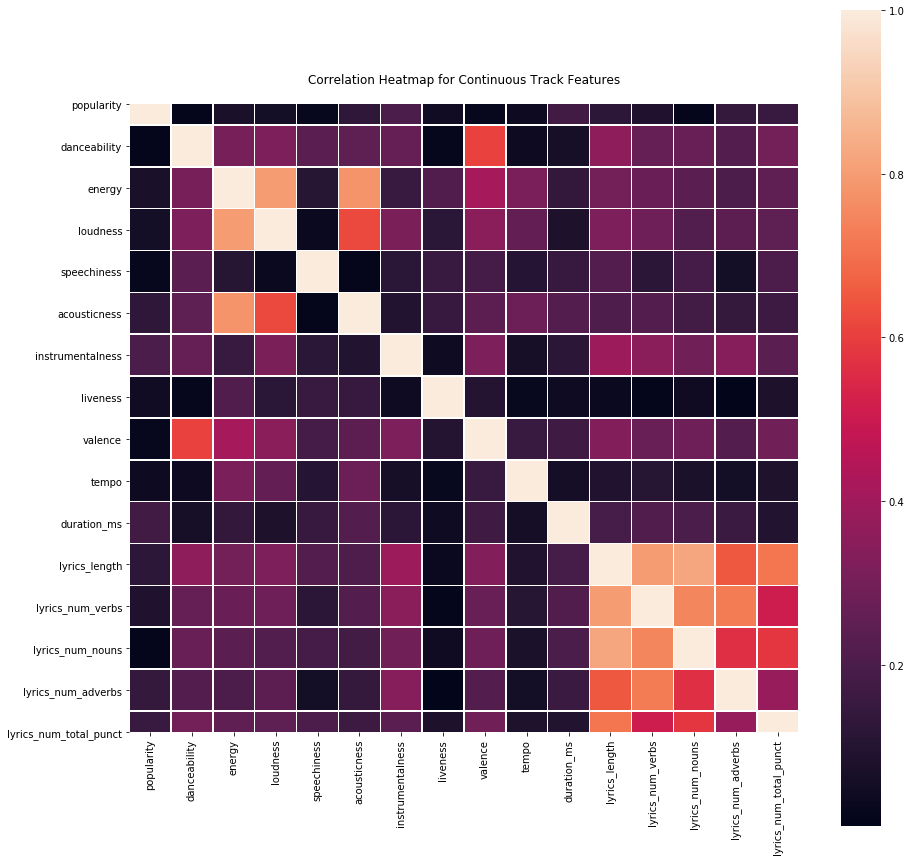

In [81]:
#Compare feature similarities 
#Compare the numerical continuous variables and their correlations via a heatmap
plt.figure(figsize=(15,15))
sns.heatmap(abs(df[cont_cols].corr()), square=True, linewidths=.5, annot=False)
plt.title('Correlation Heatmap for Continuous Track Features\n')
plt.show()

We can see here that some of the features are highly correlated with each other, which means we will probably need to remove some of them to ensure accurate clustering without over-complicating the model.

Another point to note is that, while we had converted `album_release_year` into several unique dummy categoricals for each unique year, we don't need to do that after all. The year can be treated as a continuous variable, representative of the age of the song, with higher year representing 'newer' songs. 

In [16]:
bin_months = bin_cat_cols[2015:2027]
bin_years = bin_cat_cols[2027:2078]
bin_lyrics = bin_cat_cols[:2000]

In [17]:
df = df.drop(bin_years, axis=1)
df, str_cat_cols, bin_cat_cols, cat_cols, cont_cols = catSorting(df)

## Initial Clustering: Determine Less-Useful Features
For the purposes of this project, we have elected to use a total of 40 unique clusters, then remove any clusters that contain fewer than 10 songs. That way, we can give more targeted recommendations based on users' input.

In [18]:
#Normalize data via Min-Max Scaling
X_std = pd.DataFrame()

for cat_lst in [cont_cols, ['album_release_year'], bin_cat_cols]:
    for cat in cat_lst:
        normed = []
        xmax = df[cat].max()
        xmin = df[cat].min()
        for item in df[cat]:
            normed.append((item-xmin)/(xmax-xmin))

        X_std[cat.split('Winsorized ')[-1]] = normed


In [19]:
#PCA transformation
from sklearn.decomposition import PCA
transformer = PCA(n_components=2)
X_pca = transformer.fit_transform(X_std)

X = np.array(list(zip(X_pca[:, 0], X_pca[:, 1]))).reshape(len(X_pca[:, 0]), 2) 

In [86]:
opt_nclust=40
cmp_pca = colorList(opt_nclust)

399 ms ± 30.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


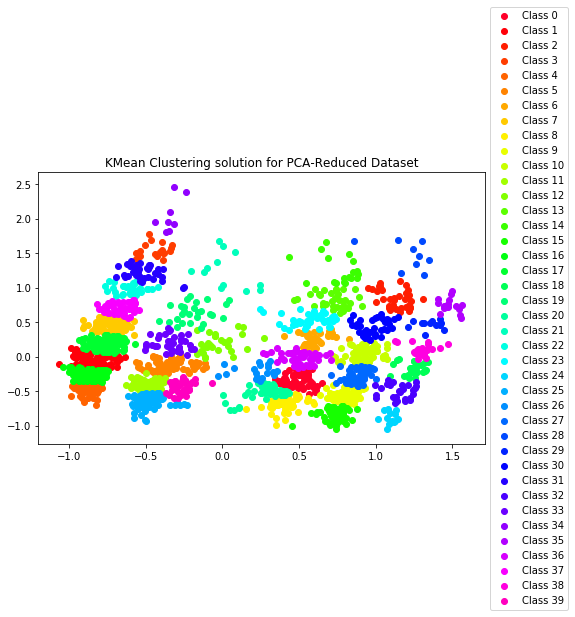

Silhoutte Score of the KMean Clustering solution on PCA-Reduced Dataset: 0.4004160728112459


In [87]:
KMeansPlot(opt_nclust, X_pca, cmp_pca, 'PCA')

Earlier in this process, we converted the categorical variables into one-hot encoded dummy features, to improve the modeling. One thing we didn't do is remove one of the dummies, because it over-complicates the model, as the last dummy can be represented by the information of all the rest of them. So, here we remove any features that provide redundant information.

In [20]:
drop_cols = ['album_type_compilation', 'key_A#/Bb', 'time_signature_1.0', 'album_name_cat_Deluxe Edition', 'album_name_cat_Original Motion Picture Soundtrack / Deluxe Edition', 'album_name_cat_Original Motion Picture Soundtrack/Deluxe Edition', 'track_name_cat_Soundtrack Version', 'album_release_month_January']
X_std2 = X_std.drop(drop_cols, axis=1)
X_std2.head()

popularity  danceability    energy  loudness  speechiness  acousticness  \
0    0.593023      0.797082  0.673308  0.742721     0.025428      0.782128   
1    0.500000      0.379182  0.209907  0.623835     0.032740      0.771084   
2    0.523256      0.435121  0.347621  0.714877     0.023246      0.802208   
3    0.430233      0.177361  0.180756  0.598752     0.012769      0.883534   
4    0.372093      0.329823  0.166683  0.578553     0.026629      0.839357   

   instrumentalness  liveness   valence     tempo  ...  album_name_cat_Deluxe  \
0          0.028673  0.179634  0.745402  0.348738  ...                    0.0   
1          0.000000  0.427331  0.331809  0.311426  ...                    0.0   
2          0.275510  0.120356  0.808791  0.924812  ...                    0.0   
3          0.000002  0.318302  0.312065  0.253199  ...                    0.0   
4          0.000011  0.319361  0.375455  0.326830  ...                    0.0   

   album_name_cat_Music from the TV Series  \
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      0.0   

   album_name_cat_Original Motion Picture Soundtrack  \
0                                                1.0   
1                                                0.0   
2                                                1.0   
3                                                0.0   
4                                                1.0   

   album_name_cat_Original Soundtrack  \
0                                 0.0   
1                                 0.0   
2                                 0.0   
3                                 0.0   
4                                 0.0   

   album_name_cat_Original TV Movie Soundtrack  \
0                                          0.0   
1                                          0.0   
2                                          0.0   
3                                          0.0   
4                                          0.0   

   album_name_cat_Original Television Soundtrack  \
0                                            0.0   
1                                            0.0   
2                                            0.0   
3                                            0.0   
4                                            0.0   

   album_name_cat_Studio Cast Recording  track_name_cat_Reprise  \
0                                   0.0                     0.0   
1                                   0.0                     0.0   
2                                   0.0                     0.0   
3                                   0.0                     0.0   
4                                   0.0                     0.0   

   track_name_cat_Score  track_name_cat_Soundtrack  
0                   0.0                        0.0  
1                   0.0                        1.0  
2                   0.0                        0.0  
3                   0.0                        1.0  
4                   0.0                        0.0  

[5 rows x 2054 columns]

In [21]:
X_std2, str_cat_cols2, bin_cat_cols2, cat_cols2, cont_cols2 = catSorting(X_std2)

By running a KMeans clustering on several versions of this dataset (each containing only one of the continuous features being analyzed), we can determine which ones result in the lowest Silhouette Scores, and therefore, which ones we should remove to optimize our clustering.

In [22]:
for col in cont_cols2:
    X_std3 = X_std2[list(set([col] + ['album_release_year'] + [item for item in bin_cat_cols2 if item not in list(set(bin_months + bin_lyrics))]))]
    X_pca = transformer.fit_transform(X_std3)    

    X = np.array(list(zip(X_pca[:, 0], X_pca[:, 1]))).reshape(len(X_pca[:, 0]), 2)

    # Calculate error values for a k value of 40
    kmeans = KMeans(n_clusters=40).fit(X)
    predictions = kmeans.predict(X)
    silhouette_avg = metrics.silhouette_score(X, predictions)
    
    print(col, '\nSilhouette Score: ', silhouette_avg)
    print('\n')
    

popularity 
Silhouette Score:  0.43630827227644964


danceability 
Silhouette Score:  0.5490593809237838


energy 
Silhouette Score:  0.38541273269969756


loudness 
Silhouette Score:  0.5826192247145973


speechiness 
Silhouette Score:  0.5890107250731726


acousticness 
Silhouette Score:  0.44934274772047933


instrumentalness 
Silhouette Score:  0.4732942766117296


liveness 
Silhouette Score:  0.5889556555905553


valence 
Silhouette Score:  0.47115592838656795


tempo 
Silhouette Score:  0.5815764208469626


duration_ms 
Silhouette Score:  0.5830773926115487


lyrics_length 
Silhouette Score:  0.5851253056516202


lyrics_num_verbs 
Silhouette Score:  0.5806064070967661


lyrics_num_nouns 
Silhouette Score:  0.5905945936062965


lyrics_num_adverbs 
Silhouette Score:  0.5791394327916239


lyrics_num_total_punct 
Silhouette Score:  0.5648436185045375




As you can see, the features that resulted in the lowest Silhouette Scores were: `popularity`, `energy`, `acousticness`, `instrumentalness`, and `valence`. Therefore, those are the features that we will remove from the dataset before proceeding with the unsupervised clustering.

In [23]:
X_std_fin = X_std2.drop(['popularity', 'energy', 'acousticness', 'instrumentalness', 'valence'], axis=1)
X_std_fin.columns

Index(['danceability', 'loudness', 'speechiness', 'liveness', 'tempo',
       'duration_ms', 'lyrics_length', 'lyrics_num_verbs', 'lyrics_num_nouns',
       'lyrics_num_adverbs',
       ...
       'album_name_cat_Deluxe', 'album_name_cat_Music from the TV Series',
       'album_name_cat_Original Motion Picture Soundtrack',
       'album_name_cat_Original Soundtrack',
       'album_name_cat_Original TV Movie Soundtrack',
       'album_name_cat_Original Television Soundtrack',
       'album_name_cat_Studio Cast Recording', 'track_name_cat_Reprise',
       'track_name_cat_Score', 'track_name_cat_Soundtrack'],
      dtype='object', length=2049)

## Test PCA-Reduced Dataset to Determine Clustering Method

In [24]:
#PCA transformation
from sklearn.decomposition import SparsePCA
transformer = PCA(n_components=2)
X_pca = transformer.fit_transform(X_std_fin)

X = np.array(list(zip(X_pca[:, 0], X_pca[:, 1]))).reshape(len(X_pca[:, 0]), 2) 

In [25]:
#Generate colors cmap
opt_nclust = 40
cmp_pca = colorList(opt_nclust)

394 ms ± 29.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


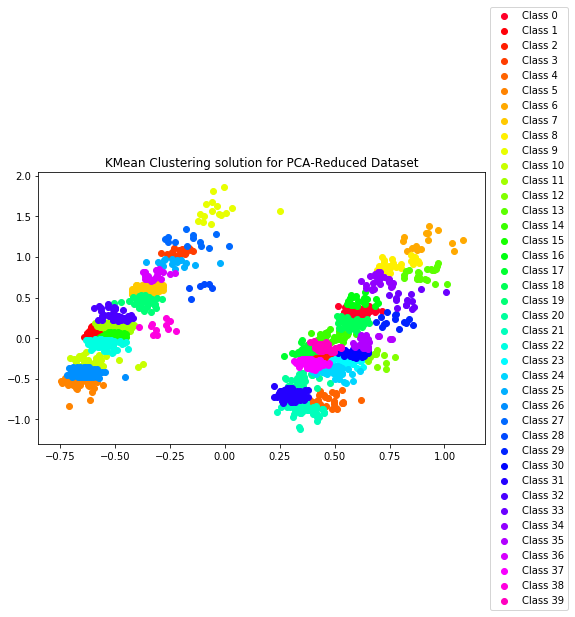

Silhoutte Score of the KMean Clustering solution on PCA-Reduced Dataset: 0.37587234791053015


In [95]:
#Plot KMeans-colored labels
KMeansPlot(opt_nclust, X_pca, cmp_pca, 'PCA')

105 ms ± 10.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


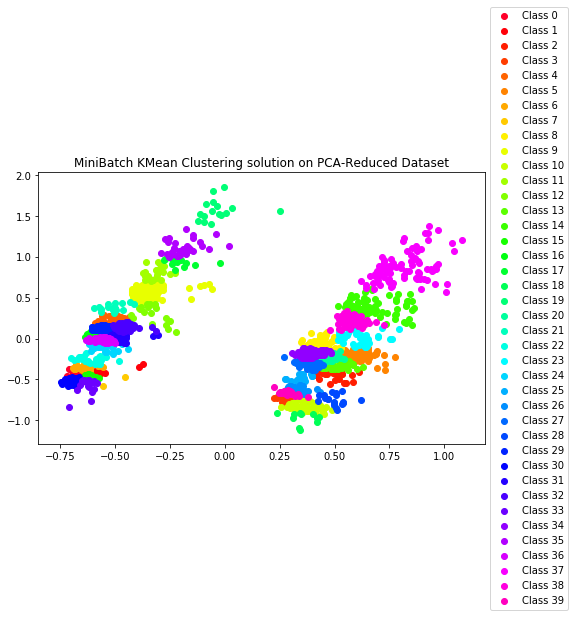

Silhoutte Score of the MiniBatchKMean Clustering solution on PCA-Reduced Dataset: 0.31543401034924345


In [96]:
MiniBatchKMeansPlot(opt_nclust, X_pca, cmp_pca, 'PCA')

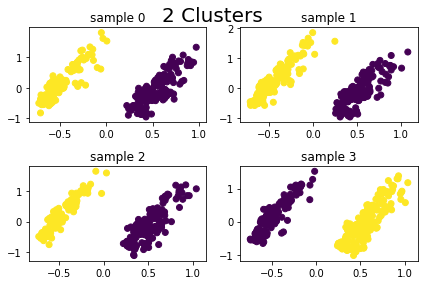

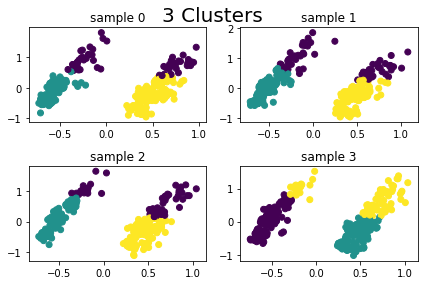

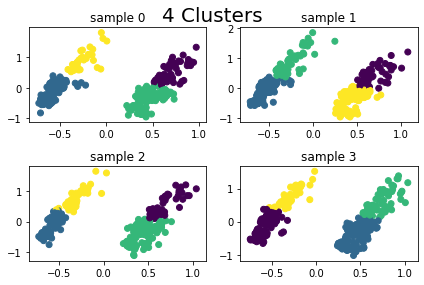

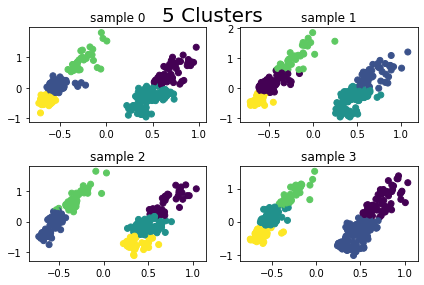

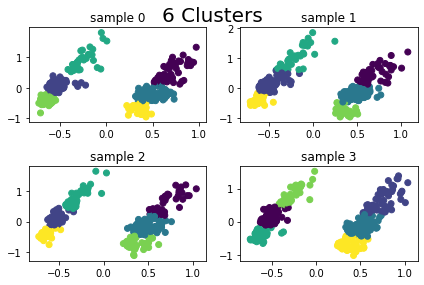

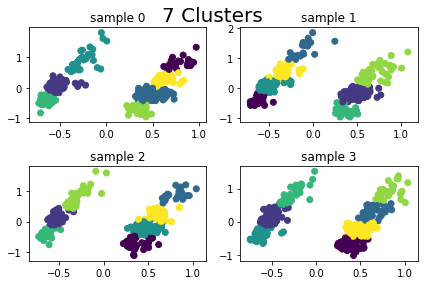

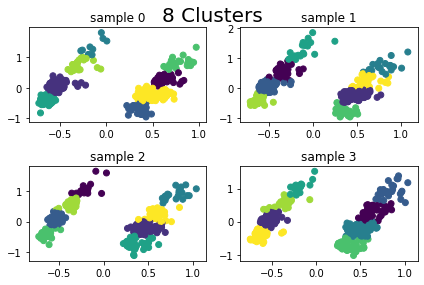

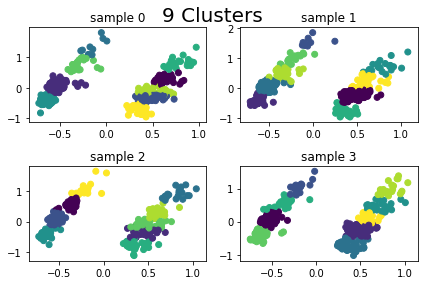

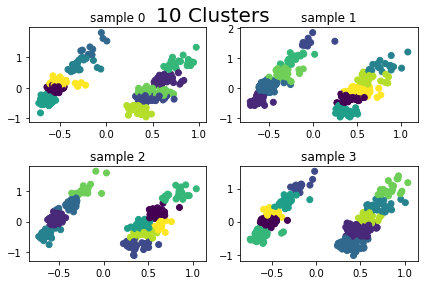

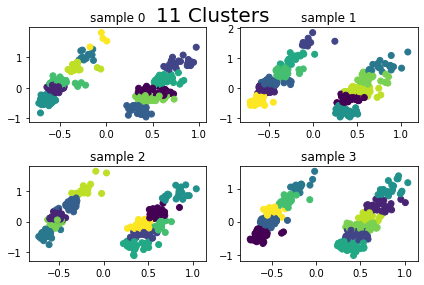

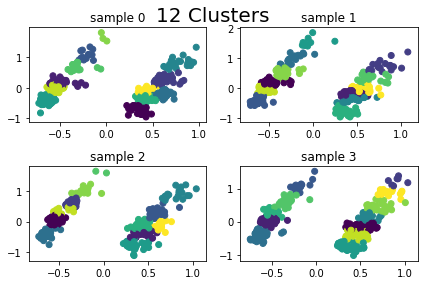

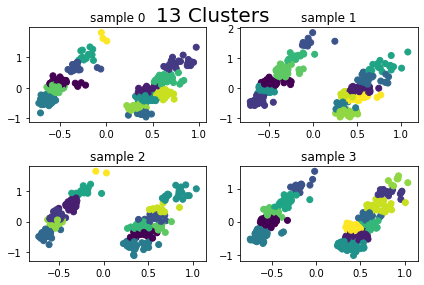

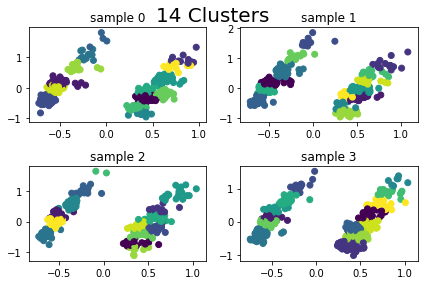

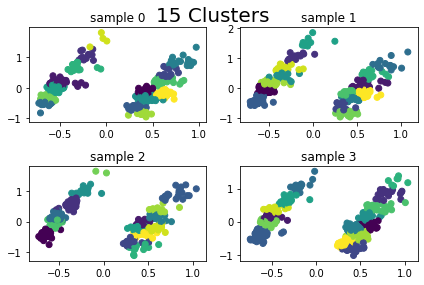

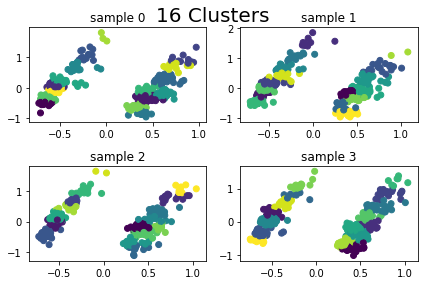

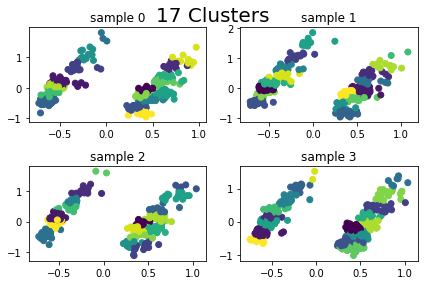

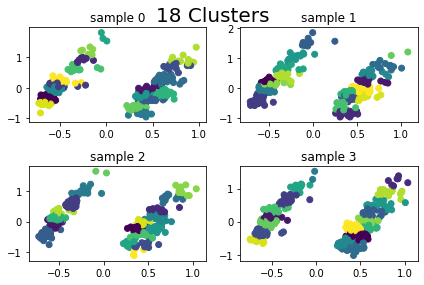

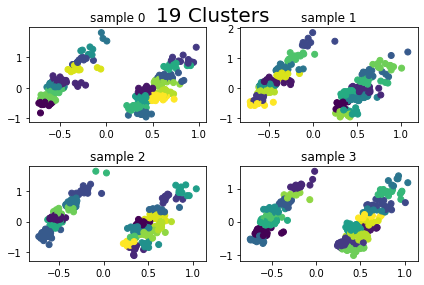

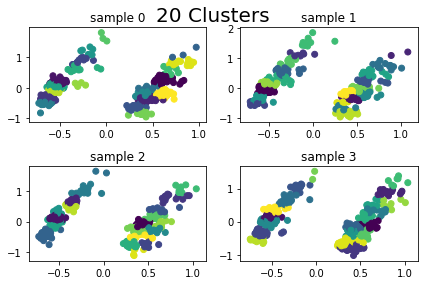

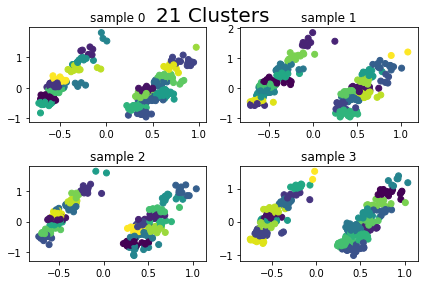

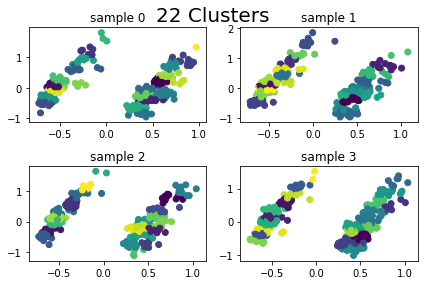

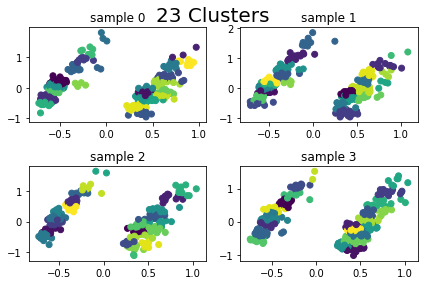

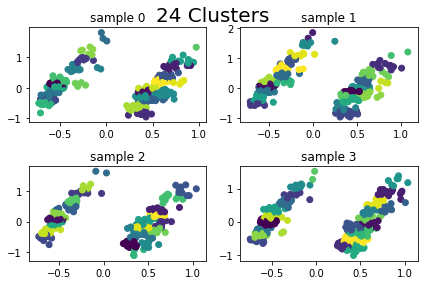

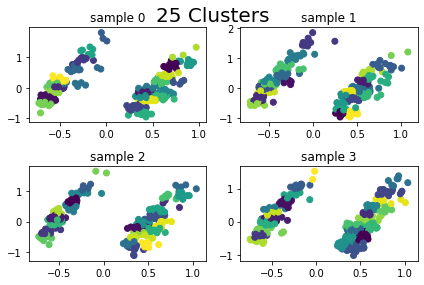

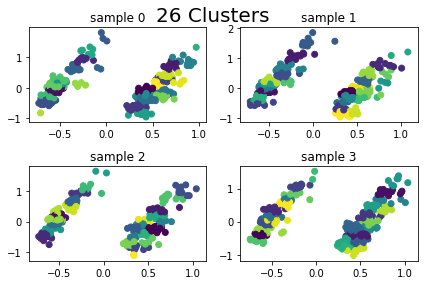

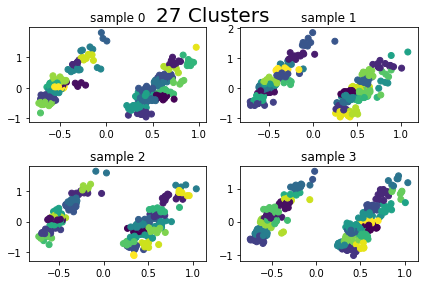

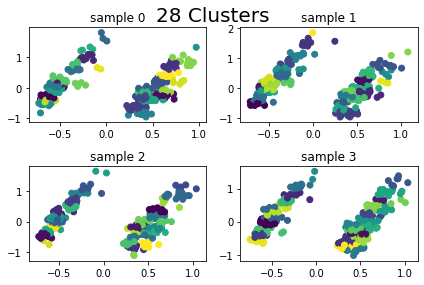

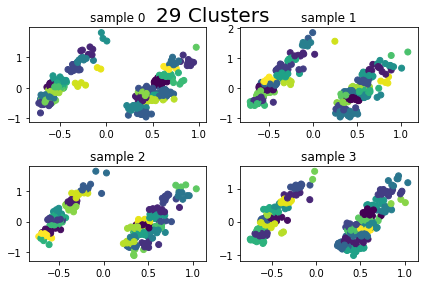

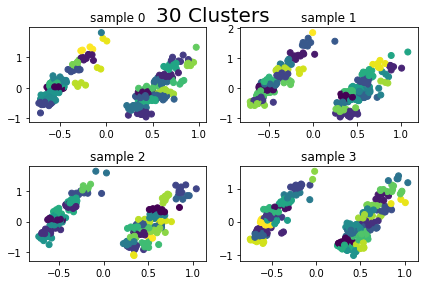

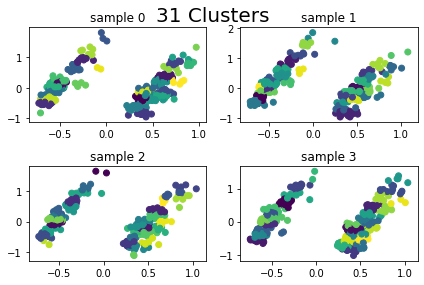

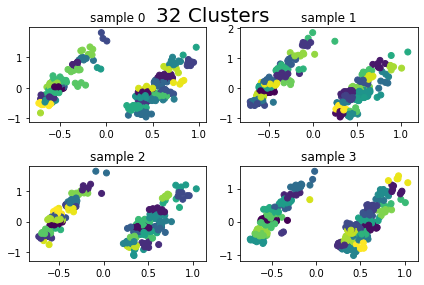

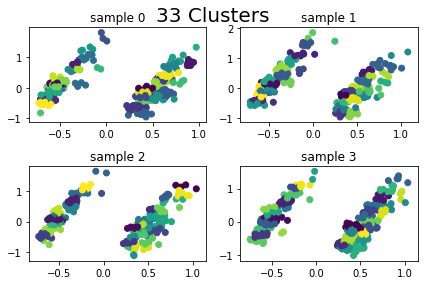

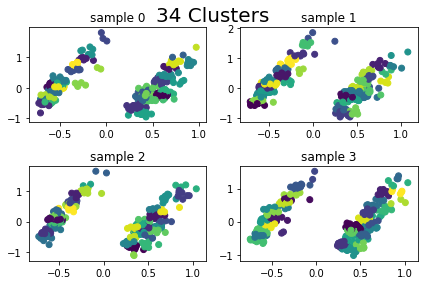

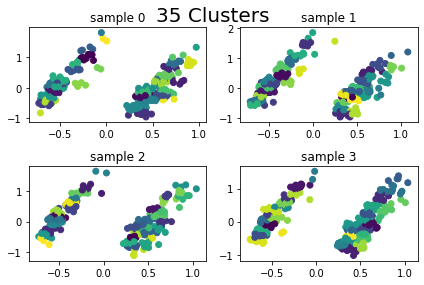

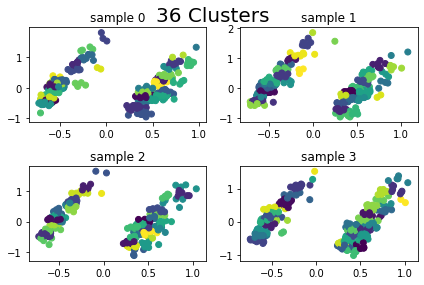

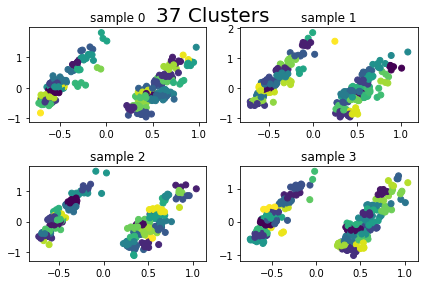

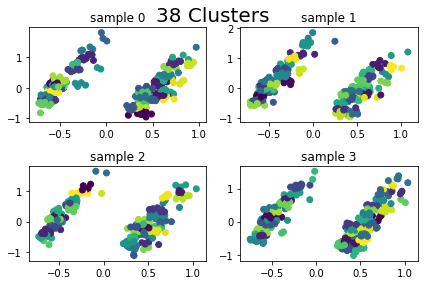

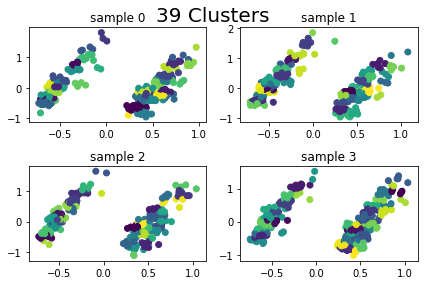

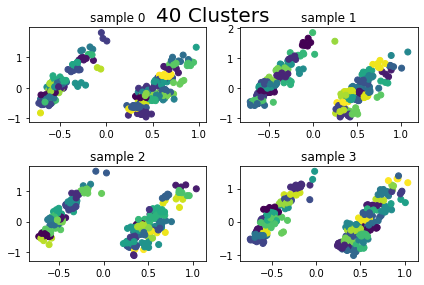




KMean Clustering on PCA-Reduced Dataset - Sub-Sample Silhouette Scores for k-value of 40
Sub-Sample # 1 :  0.3695055367399085
Sub-Sample # 2 :  0.4083299896247757
Sub-Sample # 3 :  0.3770001249636101
Sub-Sample # 4 :  0.3859387776837297


In [97]:
dataSplitComparisons(X, X_pca, opt_nclust, 'PCA')

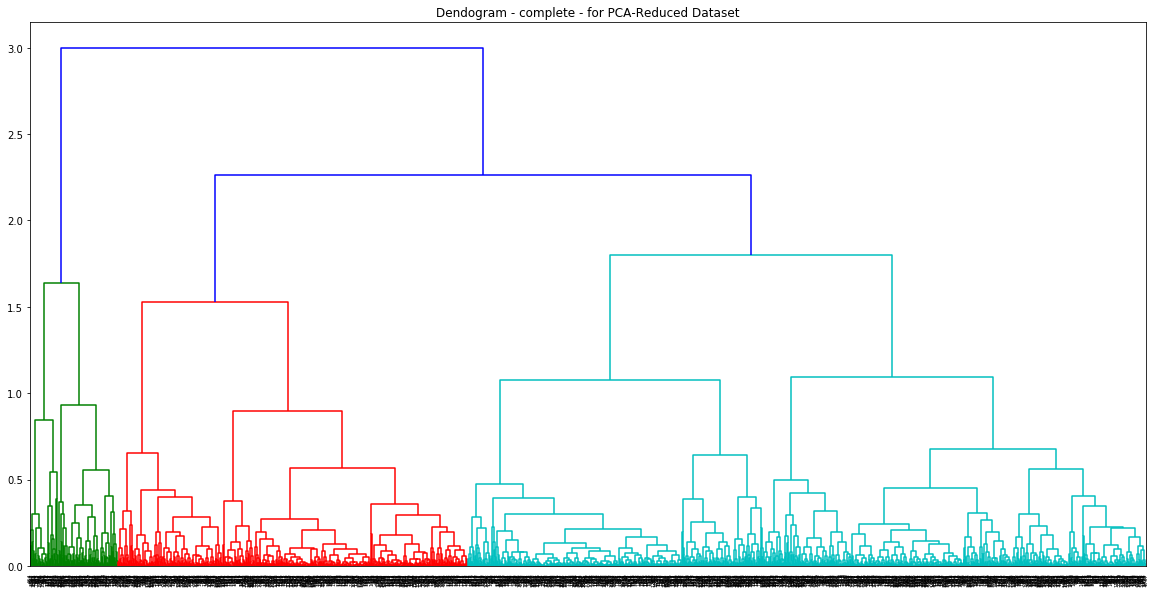

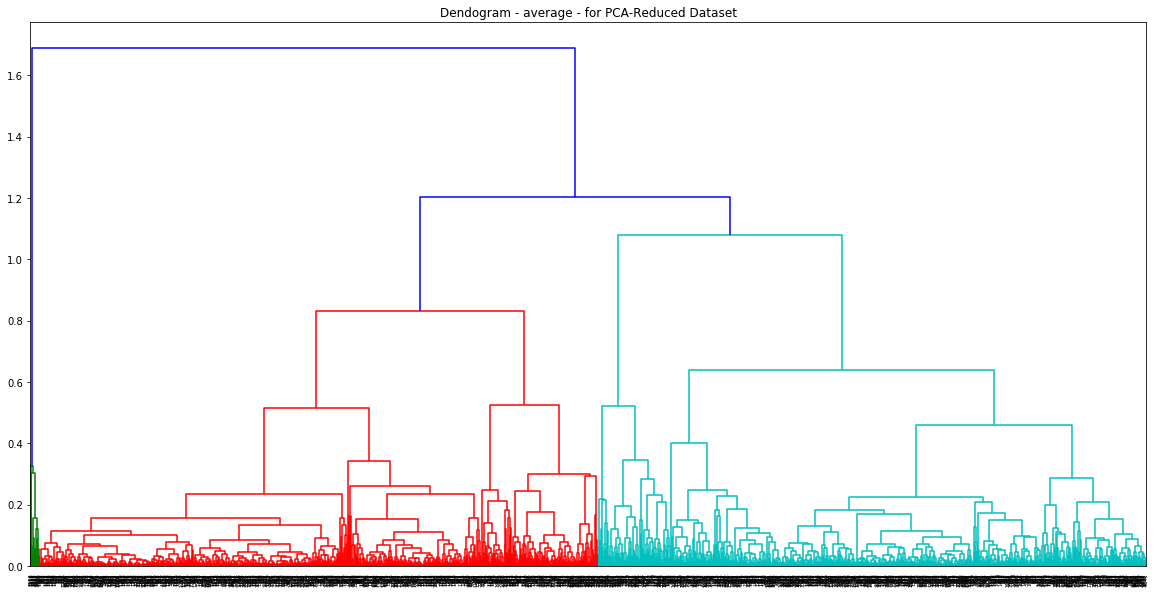

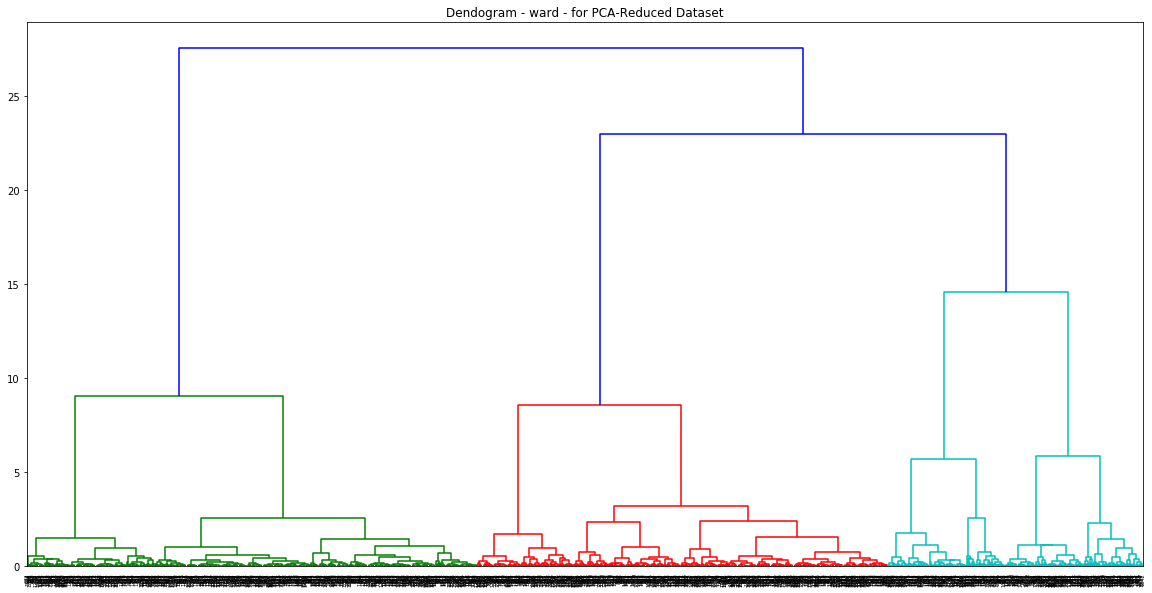

In [98]:
dendogramPlots(X, 'PCA')

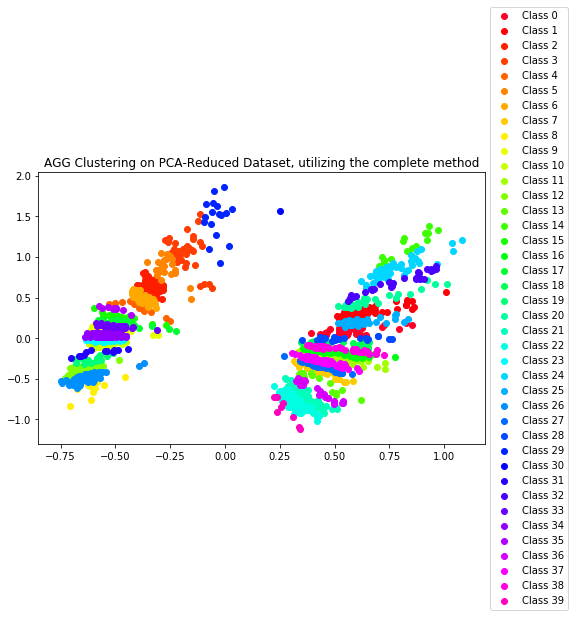

Silhoutte Score of the Agglomerative Clustering solution for PCA-Reduced Dataset, utilizing the complete method: 0.6244788206816918

-----------------------------------------------------------------------------------------



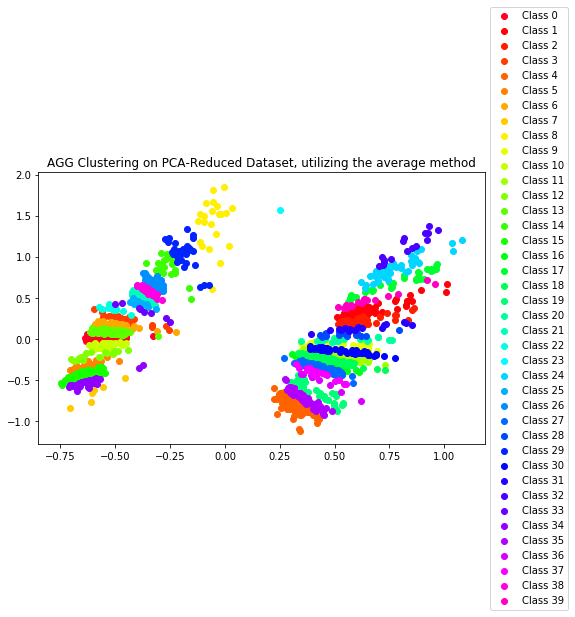

Silhoutte Score of the Agglomerative Clustering solution for PCA-Reduced Dataset, utilizing the average method: 0.64612273398136

-----------------------------------------------------------------------------------------



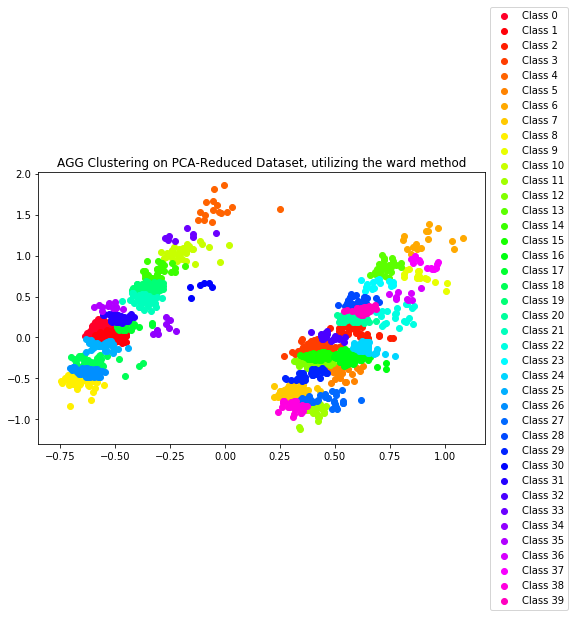

Silhoutte Score of the Agglomerative Clustering solution for PCA-Reduced Dataset, utilizing the ward method: 0.3480358969702735

-----------------------------------------------------------------------------------------



In [99]:
aggClustering(X, X_pca, opt_nclust, cmp_pca, 'PCA')

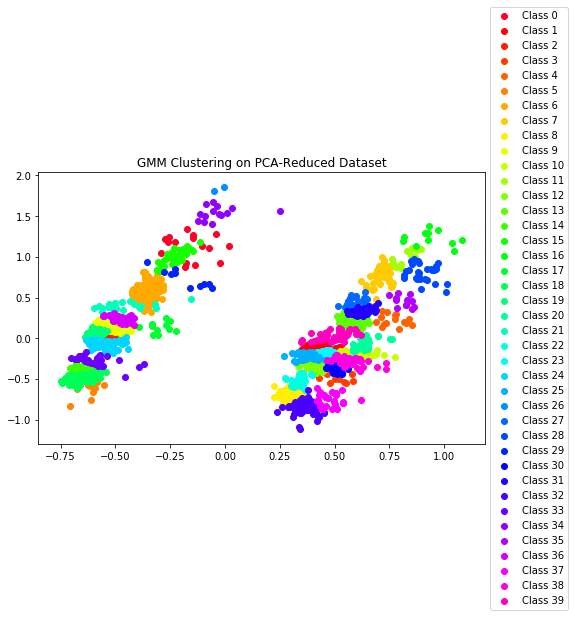

Silhouette Score for GMM Clustering on PCA-Reduced Dataset: 0.3229594823605904


In [100]:
gmmClustering(X, X_pca, opt_nclust, cmp_pca, 'PCA')

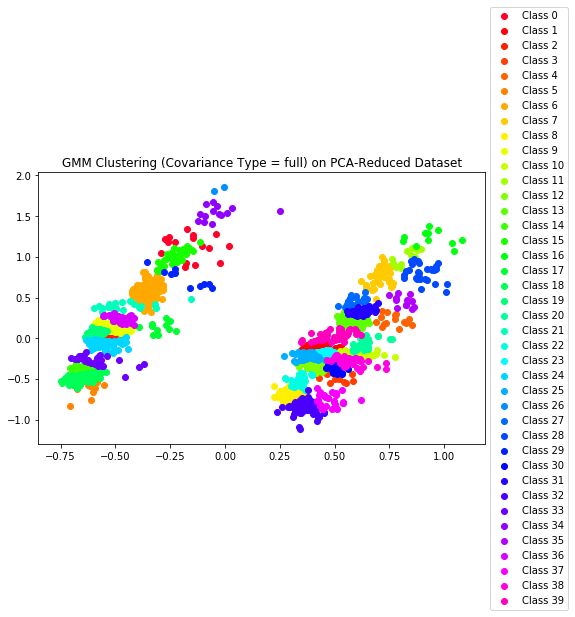

Silhouette Score for GMM (Covariance Type = full) on PCA-Reduced Dataset: 0.3229594823605904

-----------------------------------------------------------------------------------------



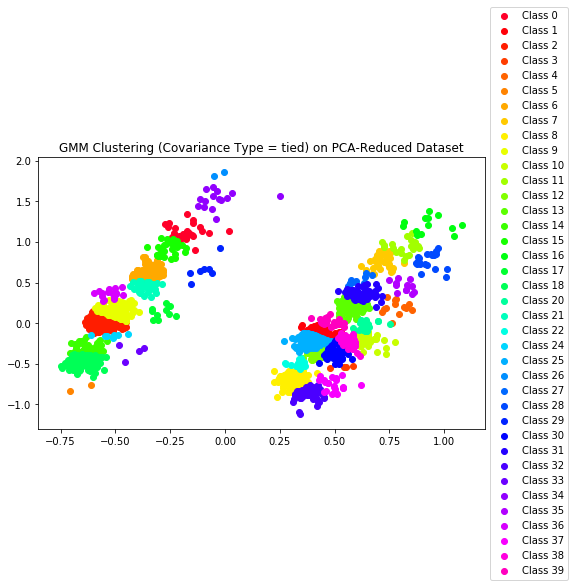

Silhouette Score for GMM (Covariance Type = tied) on PCA-Reduced Dataset: 0.34024256947252046

-----------------------------------------------------------------------------------------



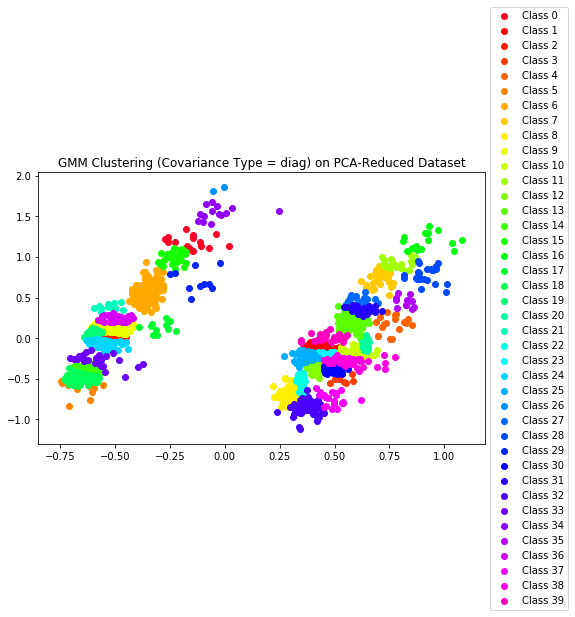

Silhouette Score for GMM (Covariance Type = diag) on PCA-Reduced Dataset: 0.31982899073696214

-----------------------------------------------------------------------------------------



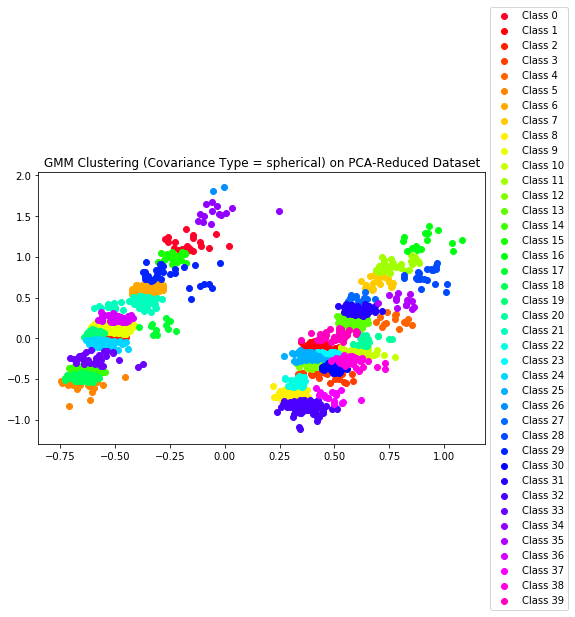

Silhouette Score for GMM (Covariance Type = spherical) on PCA-Reduced Dataset: 0.3478715097427757

-----------------------------------------------------------------------------------------



In [101]:
gmmCovClustering(X, X_pca, opt_nclust, cmp_pca, 'PCA')

The method with the highest Silhouette Score was Agglomerative Clustering. Now, we'll run a loop to determine which dimensionality reduction technique (PCA, t-SNE, or UMAP) and parameters achieve the best score.

In [27]:
#PCA
transformer = PCA(n_components=2)
X_pca = transformer.fit_transform(X_std2)
X = np.array(list(zip(X_pca[:, 0], X_pca[:, 1]))).reshape(len(X_pca[:, 0]), 2)

silScores = {}
silScores['Description'] = ['PCA - {} Agglomerative Clustering'.format('complete')]

agg_cluster = AgglomerativeClustering(linkage='complete', 
                                          affinity='cosine',
                                          n_clusters=opt_nclust)
# Fit model
clusters = agg_cluster.fit_predict(X)

silScores['Score'] = [metrics.silhouette_score(X, clusters, metric='cosine')]

affinities = ['cosine', 'euclidean']
linkages = ['average', 'ward']
for i in range(len(linkages)):
    # Defining the agglomerative clustering
    agg_cluster = AgglomerativeClustering(linkage=linkages[i], 
                                          affinity=affinities[i],
                                          n_clusters=opt_nclust)
    
    # Fit model
    clusters = agg_cluster.fit_predict(X)
    silScores['Description'].extend(['PCA - {} Agglomerative Clustering'.format(linkages[i])])
    silScores['Score'].extend([metrics.silhouette_score(X, clusters, metric=affinities[i])])


#UMAP
import umap
affinities = ['cosine', 'cosine', 'euclidean']
linkages = ['complete', 'average', 'ward']
for neighbor in [5, 10, 15, 20, 25]:
    for dist in [0.01, 0.25, 0.65, 1.0]:
        #Computing the UMAP components
        umap_transformer = umap.UMAP(n_neighbors=neighbor,
                          min_dist=dist,
                          metric='correlation')

        X_umap = umap_transformer.fit_transform(X_std2)
        X = np.array(list(zip(X_umap[:, 0], X_umap[:, 1]))).reshape(len(X_umap[:, 0]), 2)

        for i in range(len(linkages)):
            # Defining the agglomerative clustering
            agg_cluster = AgglomerativeClustering(linkage=linkages[i], 
                                                  affinity=affinities[i],
                                                  n_clusters=opt_nclust)

            # Fit model
            clusters = agg_cluster.fit_predict(X)
            silScores['Description'].extend(['UMAP - neighbors = {} and distance = {} - {} Agglomerative Clustering'.format(neighbor, dist, linkages[i])])
            silScores['Score'].extend([metrics.silhouette_score(X, clusters, metric=affinities[i])])
            

#TSNE
from sklearn.manifold import TSNE            
for perp in [120, 140, 160, 180, 200]:
    tsne = TSNE(n_components=2, verbose=1, perplexity=perp, n_iter=300)
    X_tsne = tsne.fit_transform(X_std2)
    X = np.array(list(zip(X_tsne[:, 0], X_tsne[:, 1]))).reshape(len(X_tsne[:, 0]), 2)
    
    for i in range(len(linkages)):
        # Defining the agglomerative clustering
        agg_cluster = AgglomerativeClustering(linkage=linkages[i], 
                                              affinity=affinities[i],
                                              n_clusters=opt_nclust)

        # Fit model
        clusters = agg_cluster.fit_predict(X)
        silScores['Description'].extend(['TSNE - perplexity = {} - {} Agglomerative Clustering'.format(perp, linkages[i])])
        silScores['Score'].extend([metrics.silhouette_score(X, clusters, metric=affinities[i])])


[t-SNE] Computing 361 nearest neighbors...
[t-SNE] Indexed 1807 samples in 0.252s...
[t-SNE] Computed neighbors for 1807 samples in 9.810s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1807
[t-SNE] Computed conditional probabilities for sample 1807 / 1807
[t-SNE] Mean sigma: 0.892686
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.310364
[t-SNE] KL divergence after 300 iterations: 1.738115
[t-SNE] Computing 421 nearest neighbors...
[t-SNE] Indexed 1807 samples in 0.224s...
[t-SNE] Computed neighbors for 1807 samples in 9.988s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1807
[t-SNE] Computed conditional probabilities for sample 1807 / 1807
[t-SNE] Mean sigma: 0.909285
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.048653
[t-SNE] KL divergence after 300 iterations: 1.647263
[t-SNE] Computing 481 nearest neighbors...
[t-SNE] Indexed 1807 samples in 0.212s...
[t-SNE] Computed neighbors for 1807 samples in 

In [28]:
silScores

{'Description': ['PCA - complete Agglomerative Clustering',
  'PCA - average Agglomerative Clustering',
  'PCA - ward Agglomerative Clustering',
  'UMAP - neighbors = 5 and distance = 0.01 - complete Agglomerative Clustering',
  'UMAP - neighbors = 5 and distance = 0.01 - average Agglomerative Clustering',
  'UMAP - neighbors = 5 and distance = 0.01 - ward Agglomerative Clustering',
  'UMAP - neighbors = 5 and distance = 0.25 - complete Agglomerative Clustering',
  'UMAP - neighbors = 5 and distance = 0.25 - average Agglomerative Clustering',
  'UMAP - neighbors = 5 and distance = 0.25 - ward Agglomerative Clustering',
  'UMAP - neighbors = 5 and distance = 0.65 - complete Agglomerative Clustering',
  'UMAP - neighbors = 5 and distance = 0.65 - average Agglomerative Clustering',
  'UMAP - neighbors = 5 and distance = 0.65 - ward Agglomerative Clustering',
  'UMAP - neighbors = 5 and distance = 1.0 - complete Agglomerative Clustering',
  'UMAP - neighbors = 5 and distance = 1.0 - averag

The best Silhouette Score (0.708) is achieved with UMAP dimensionality reduction (neighbors = 5 and distance = 0.01) and average Agglomerative Clustering on `X_std_fin`.

## Viusualize Best 40-Group Unsupervised Clustering

In [29]:
#Compute UMAP components
umap_transformer = umap.UMAP(n_neighbors=5,
                          min_dist=0.01,
                          metric='correlation')

X_umap = umap_transformer.fit_transform(X_std_fin)
X = np.array(list(zip(X_umap[:, 0], X_umap[:, 1]))).reshape(len(X_umap[:, 0]), 2)

In [30]:
#Generate colors cmap
opt_nclust = 40
cmp_umap = colorList(opt_nclust)

326 ms ± 8.72 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


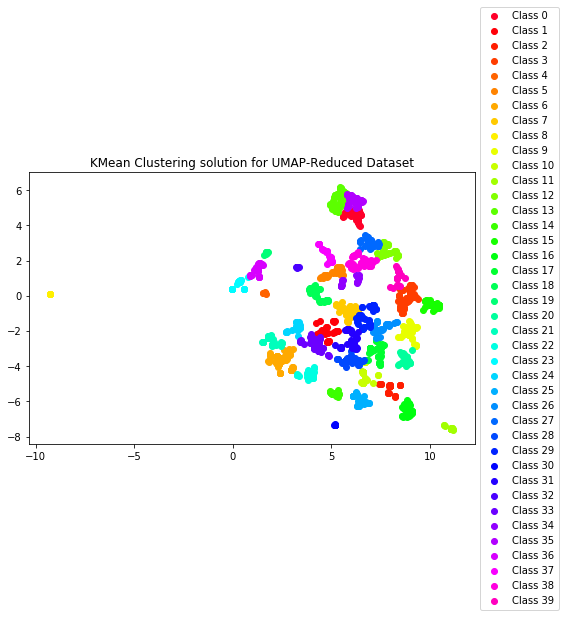

Silhoutte Score of the KMean Clustering solution on UMAP-Reduced Dataset: 0.5590890049934387


In [31]:
KMeansPlot(opt_nclust, X_umap, cmp_umap, 'UMAP')

126 ms ± 16.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


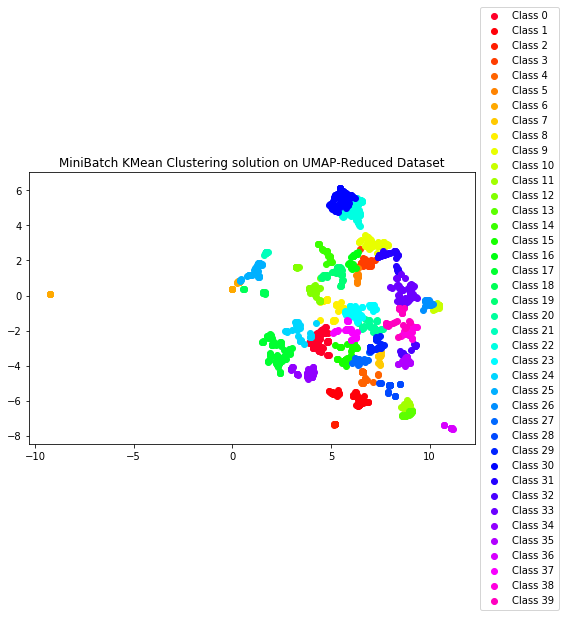

Silhoutte Score of the MiniBatchKMean Clustering solution on UMAP-Reduced Dataset: 0.4638947546482086


In [32]:
MiniBatchKMeansPlot(opt_nclust, X_umap, cmp_umap, 'UMAP')

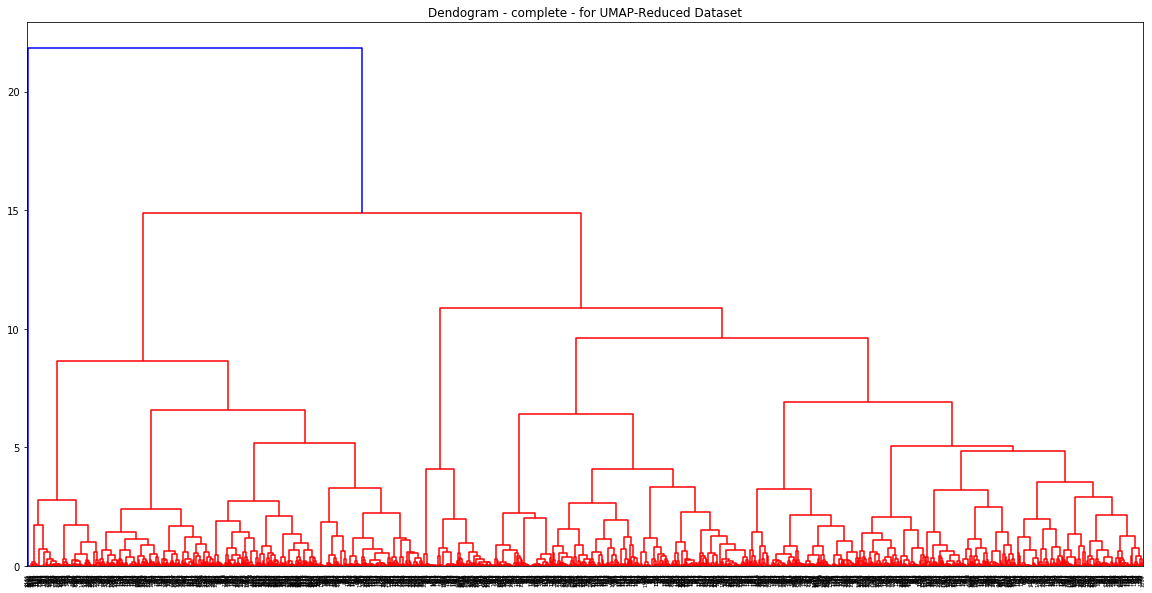

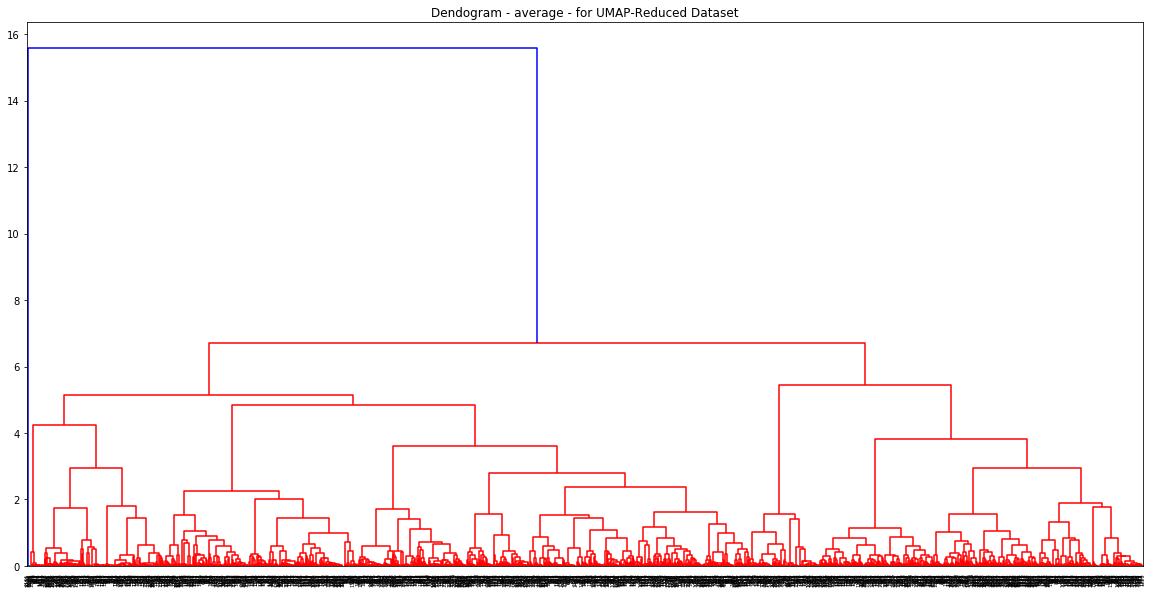

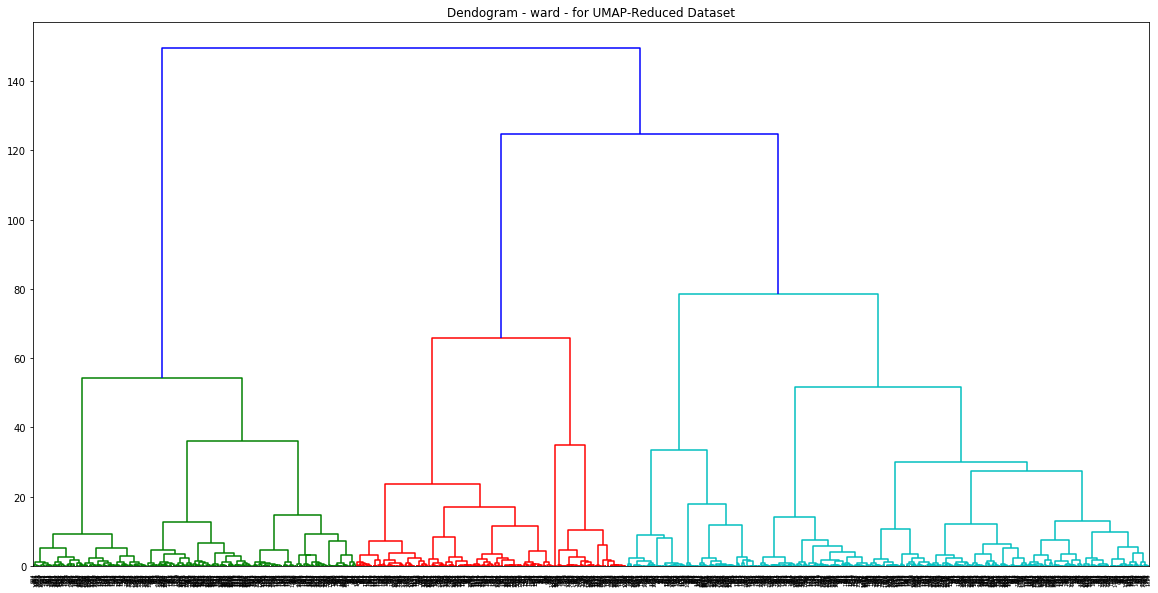

In [33]:
dendogramPlots(X, 'UMAP')

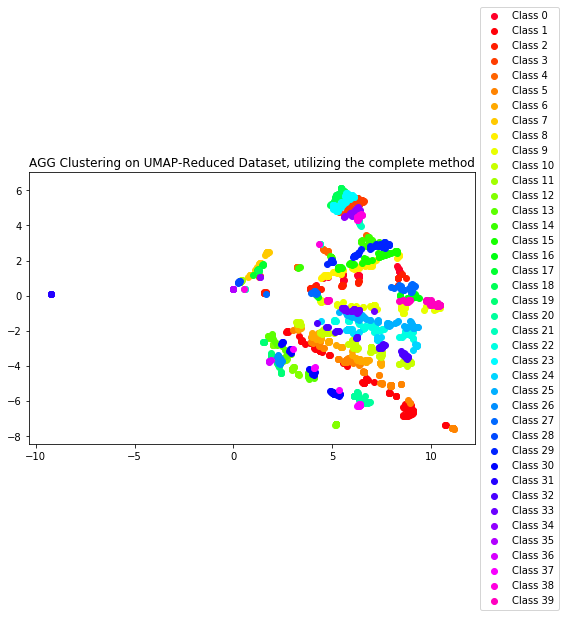

Silhoutte Score of the Agglomerative Clustering solution for UMAP-Reduced Dataset, utilizing the complete method: 0.7006143927574158

-----------------------------------------------------------------------------------------



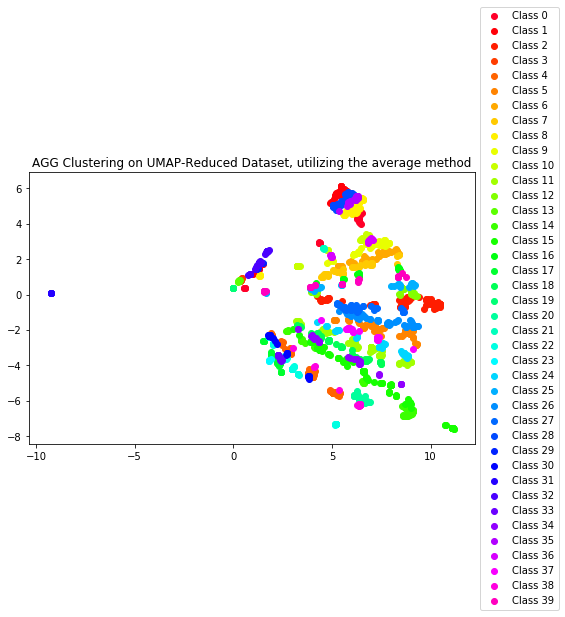

Silhoutte Score of the Agglomerative Clustering solution for UMAP-Reduced Dataset, utilizing the average method: 0.7171803712844849

-----------------------------------------------------------------------------------------



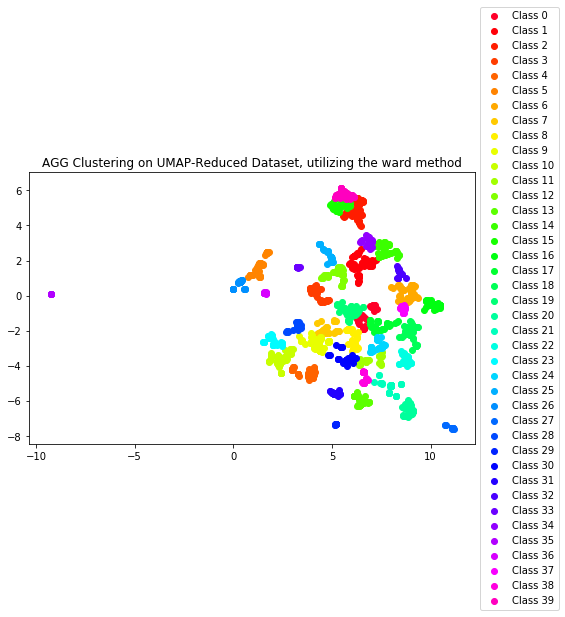

Silhoutte Score of the Agglomerative Clustering solution for UMAP-Reduced Dataset, utilizing the ward method: 0.5529153943061829

-----------------------------------------------------------------------------------------



In [34]:
aggClustering(X, X_umap, opt_nclust, cmp_umap, 'UMAP')

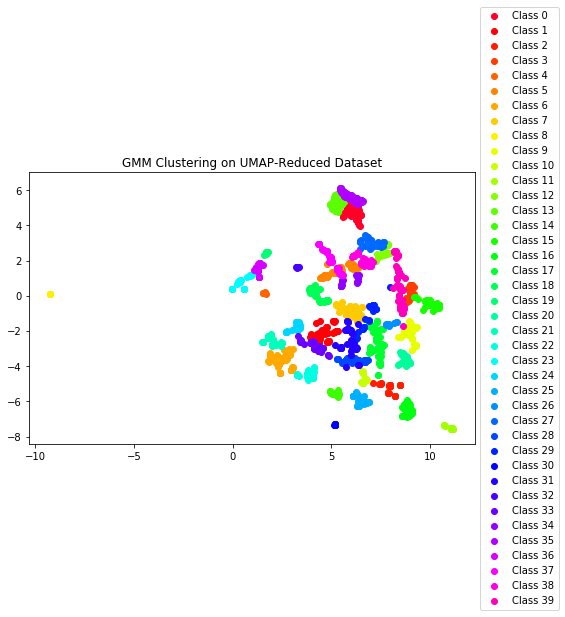

Silhouette Score for GMM Clustering on UMAP-Reduced Dataset: 0.4857691824436188


In [35]:
gmmClustering(X, X_umap, opt_nclust, cmp_umap, 'UMAP')

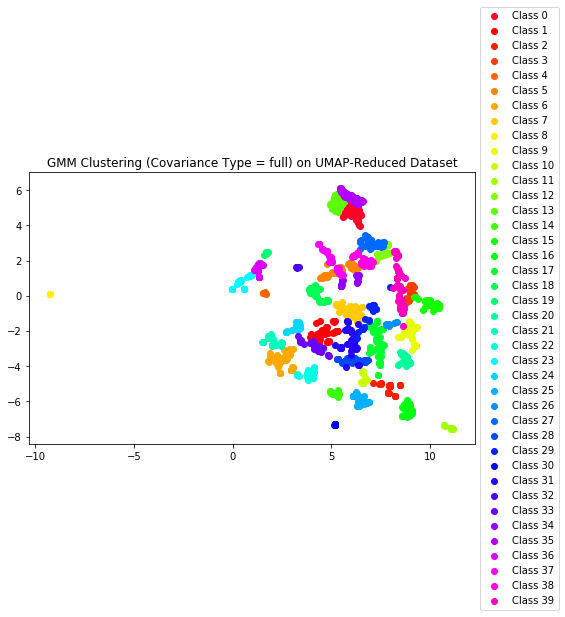

Silhouette Score for GMM (Covariance Type = full) on UMAP-Reduced Dataset: 0.4857691824436188

-----------------------------------------------------------------------------------------



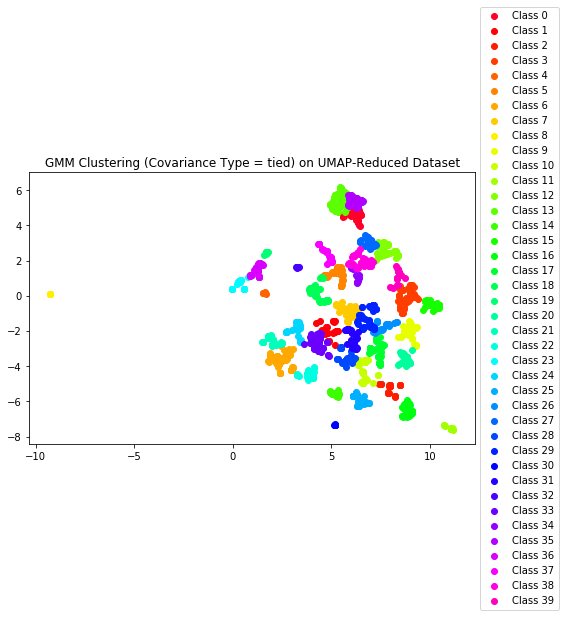

Silhouette Score for GMM (Covariance Type = tied) on UMAP-Reduced Dataset: 0.5530368089675903

-----------------------------------------------------------------------------------------



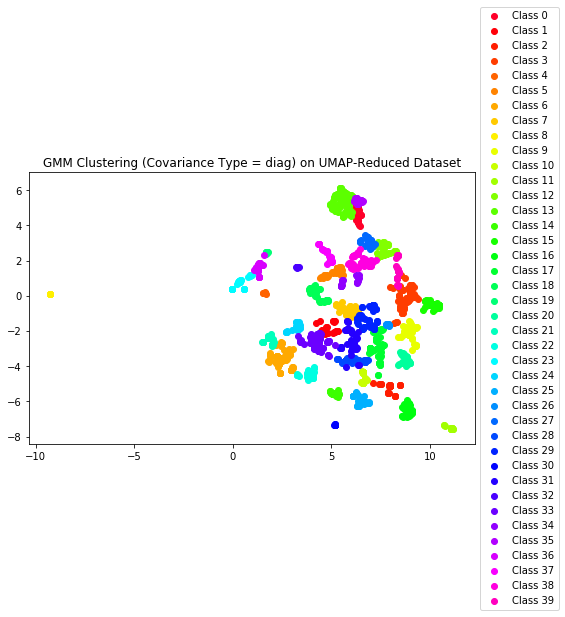

Silhouette Score for GMM (Covariance Type = diag) on UMAP-Reduced Dataset: 0.5254607796669006

-----------------------------------------------------------------------------------------



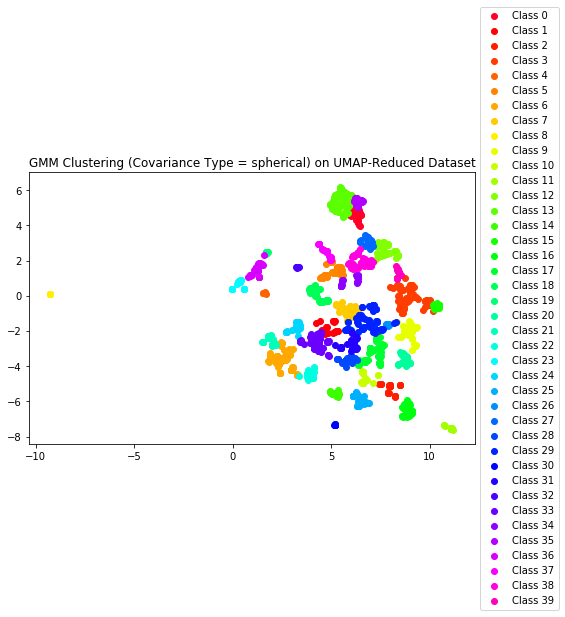

Silhouette Score for GMM (Covariance Type = spherical) on UMAP-Reduced Dataset: 0.5151129961013794

-----------------------------------------------------------------------------------------



In [36]:
gmmCovClustering(X, X_umap, opt_nclust, cmp_umap, 'UMAP')

## Create Clusters and Label

In [37]:
col_list = ['cluster', 'count']
for col in list(X_std_fin.columns):
    col_list.append(col)

In [38]:
#Computing the UMAP components
umap_transformer = umap.UMAP(n_neighbors=5,
                  min_dist=0.01,
                  metric='correlation')

X_umap = umap_transformer.fit_transform(X_std_fin)
X = np.array(list(zip(X_umap[:, 0], X_umap[:, 1]))).reshape(len(X_umap[:, 0]), 2)

km = KMeans(n_clusters=40, random_state=42)
km.fit(X_std_fin)
labels = km.labels_
cluster_centers = km.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
km_clusters = pd.DataFrame(cluster_centers, columns = X_std_fin.columns)
km_clusters['cluster'] = ['KM{}'.format(l) for l in labels_unique]
km_clusters['count'] = [list(km.labels_).count(x) for x in labels_unique]
cols = col_list
clusters = km_clusters[cols]

In [39]:
clusters

cluster  count  danceability  loudness  speechiness  liveness     tempo  \
0      KM0      1      0.447187  0.866941     0.049874  0.282312  0.634058   
1      KM1     93      0.507407  0.790727     0.036011  0.181697  0.446706   
2      KM2    108      0.559370  0.781232     0.073119  0.206607  0.430101   
3      KM3     76      0.474495  0.765324     0.033275  0.186718  0.457554   
4      KM4     28      0.487053  0.735425     0.058874  0.267927  0.429194   
5      KM5     31      0.277182  0.654549     0.037335  0.182355  0.344724   
6      KM6     89      0.535439  0.790022     0.092994  0.189853  0.446615   
7      KM7     37      0.559925  0.792010     0.079668  0.190617  0.454541   
8      KM8     96      0.355021  0.663841     0.050183  0.148749  0.428434   
9      KM9     82      0.545831  0.762370     0.069591  0.187149  0.437870   
10    KM10     76      0.535365  0.817678     0.068111  0.150740  0.501989   
11    KM11     36      0.476223  0.727501     0.063407  0.195253  0.463044   
12    KM12     66      0.483266  0.804894     0.037255  0.203007  0.481205   
13    KM13      2      0.414829  0.801274     0.019481  0.107124  0.493901   
14    KM14     19      0.599591  0.835952     0.063195  0.209362  0.430022   
15    KM15     27      0.487161  0.667241     0.064680  0.151539  0.400345   
16    KM16     48      0.466153  0.706102     0.086094  0.195882  0.400964   
17    KM17     35      0.536157  0.790673     0.079865  0.223596  0.462413   
18    KM18     77      0.556843  0.767327     0.056046  0.201385  0.422486   
19    KM19      1      0.688494  0.860624     0.282986  0.127765  0.864873   
20    KM20    108      0.514310  0.791898     0.057829  0.211871  0.441354   
21    KM21     77      0.374283  0.666878     0.037109  0.148283  0.452881   
22    KM22      1      0.610618  0.813696     0.006657  0.090822  0.489149   
23    KM23     33      0.469722  0.715766     0.083458  0.148936  0.410011   
24    KM24     85      0.577105  0.813967     0.059756  0.166129  0.458940   
25    KM25     68      0.519482  0.770836     0.050780  0.174050  0.460647   
26    KM26     51      0.543301  0.795543     0.067214  0.224941  0.456177   
27    KM27     32      0.317426  0.664059     0.089091  0.194863  0.353202   
28    KM28     13      0.493086  0.727820     0.046483  0.175408  0.413090   
29    KM29     63      0.514774  0.806386     0.064866  0.224398  0.496106   
30    KM30      6      0.473511  0.790984     0.017844  0.219011  0.284498   
31    KM31      1      0.748821  0.758062     0.439048  0.033344  0.722518   
32    KM32     46      0.494828  0.765489     0.077898  0.187709  0.457987   
33    KM33     45      0.491841  0.780529     0.064224  0.122256  0.387555   
34    KM34     22      0.543660  0.826362     0.072986  0.180096  0.426725   
35    KM35      1      0.780630  0.863915     0.282986  0.030486  0.295130   
36    KM36     24      0.440560  0.747024     0.074603  0.210177  0.449756   
37    KM37     17      0.482157  0.722464     0.037369  0.219933  0.387288   
38    KM38      3      0.668751  0.770821     0.056022  0.251191  0.415142   
39    KM39     83      0.495580  0.698996     0.065114  0.176985  0.410691   

    duration_ms  lyrics_length  lyrics_num_verbs  ...  album_name_cat_Deluxe  \
0      0.217337       0.219300          0.309091  ...               0.000000   
1      0.254159       0.193591          0.189296  ...               0.032258   
2      0.261983       0.234200          0.199621  ...               0.027778   
3      0.236173       0.160068          0.143361  ...               0.013158   
4      0.215252       0.169855          0.142208  ...               0.000000   
5      0.188650       0.059888          0.058211  ...               0.064516   
6      0.250130       0.209490          0.185138  ...               0.067416   
7      0.248219       0.234764          0.164742  ...               0.027027   
8      0.212499       0.149875          0.130919  ...               0.020833   
9   

We are only retaining the clusters that contain at least 20 songs. In this way, No matter what cluster is assigned by our supervised learning model, we can suggest at least 10 similar songs from the users' input.

In [47]:
bad_clusters = [int(i.replace('KM', '')) for i in list(clusters[clusters['count']<20]['cluster'])]
bad_clusters

[0, 13, 14, 19, 22, 28, 30, 31, 35, 37, 38]

In [50]:
drop_cols = ['album_type_compilation', 'key_A#/Bb', 'time_signature_1.0', 'album_name_cat_Deluxe Edition', 'album_name_cat_Original Motion Picture Soundtrack / Deluxe Edition', 'album_name_cat_Original Motion Picture Soundtrack/Deluxe Edition', 'track_name_cat_Soundtrack Version', 'album_release_month_January']

df_fin = df.copy()
df_fin = df_fin.drop(list(set(drop_cols + ['popularity', 'energy', 'acousticness', 'instrumentalness', 'valence'])), axis=1)
df_fin['label'] = list(labels)
for clust in bad_clusters:
    df_fin = df_fin[df_fin['label']!=clust]
    
df_fin = df_fin.reset_index(drop=True)
df_fin.head()

album_type                                         album_name  \
0  compilation  Snow White and the Seven Dwarfs (Original Moti...   
1       single                        Songs and Story: Snow White   
2  compilation  Snow White and the Seven Dwarfs (Original Moti...   
3  compilation                                Princess Collection   
4  compilation  Snow White and the Seven Dwarfs (Original Moti...   

        artists_name                                         track_name  \
0   The Dwarf Chorus                                           Heigh-Ho   
1  Adriana Caselotti  Some Day My Prince Will Come - From "Snow Whit...   
2  Adriana Caselotti                             Whistle While You Work   
3  Adriana Caselotti  I'm Wishing / One Song - From "Snow White and ...   
4  Adriana Caselotti           Animal Friends / With a Smile and a Song   

   danceability  key  loudness  mode_Major  speechiness  liveness  ...  \
0         0.789  0.0   -10.508         1.0       0.0470     0.183  ...   
1         0.408  7.0   -14.987         1.0       0.0537     0.417  ...   
2         0.459  7.0   -11.557         1.0       0.0450     0.127  ...   
3         0.224  2.0   -15.932         1.0       0.0354     0.314  ...   
4         0.363  7.0   -16.693         0.0       0.0481     0.315  ...   

   lyric_lung  lyric_hand  lyric_porcelain lyric_dote  lyrics_length  \
0         0.0         0.0              0.0        0.0            991   
1         0.0         0.0              0.0        0.0            815   
2         0.0         0.0              0.0        0.0            389   
3         0.0         0.0              0.0        0.0            831   
4         0.0         0.0              0.0        0.0           1152   

   lyrics_num_verbs  lyrics_num_nouns  lyrics_num_adverbs  \
0                45                30                  10   
1                23                13                  17   
2                19                11                  10   
3                35                23                   7   
4                38                34                  21   

  lyrics_num_total_punct  label  
0                     62      9  
1                     12      8  
2                      0     16  
3                      6     39  
4                     30      8  

[5 rows x 2060 columns]

## Save Finalized, Labelled Dataset to CSV File

In [ ]:
df_fin.to_csv('./clustered_kids_df.csv', index=False)

## Final Dataset Visualization and Analysis

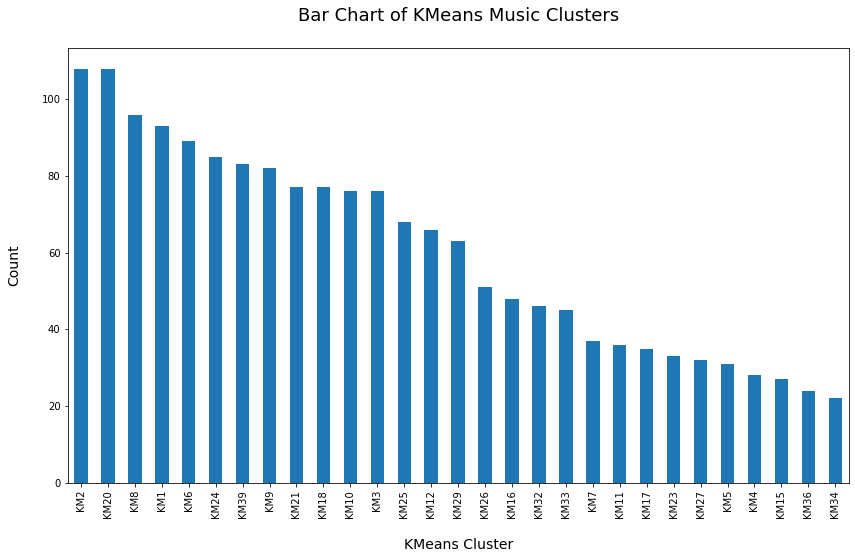

In [15]:
ax = df_fin['label'].value_counts().plot(kind='bar', figsize=(14,8), fontsize = 10)
ax.set_title("Bar Chart of KMeans Music Clusters\n", fontsize=18)
ax.set_xlabel("\nKMeans Cluster", fontsize=14)
labels = ax.get_xticklabels()
ax.set_xticklabels(['KM'+str(item.get_text()) for item in labels], rotation=90)
ax.set_ylabel("Count\n", fontsize=14)
plt.show()

In [16]:
df_fin, str_cat_cols, bin_cat_cols, cat_cols, cont_cols = catSorting(df_fin)

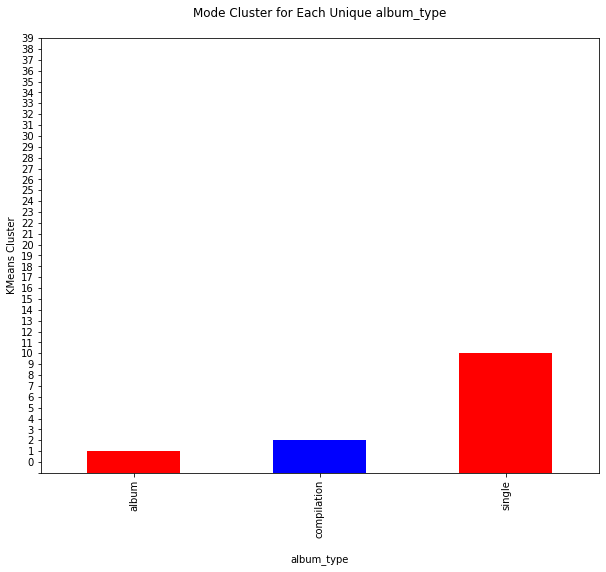

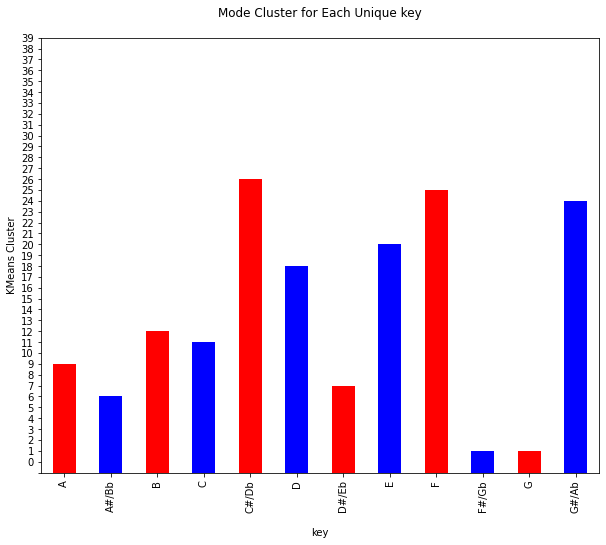

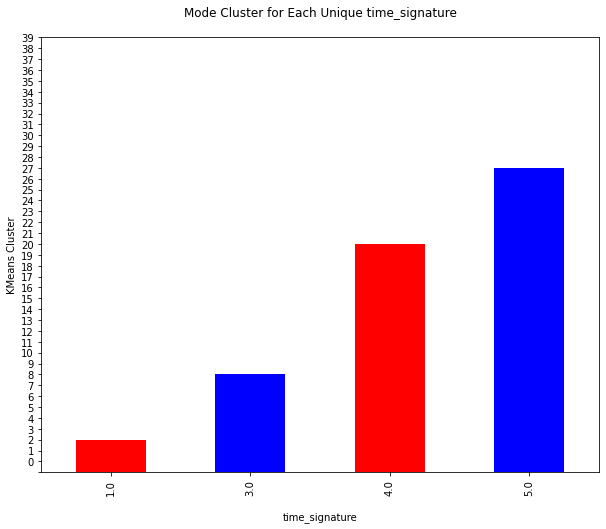

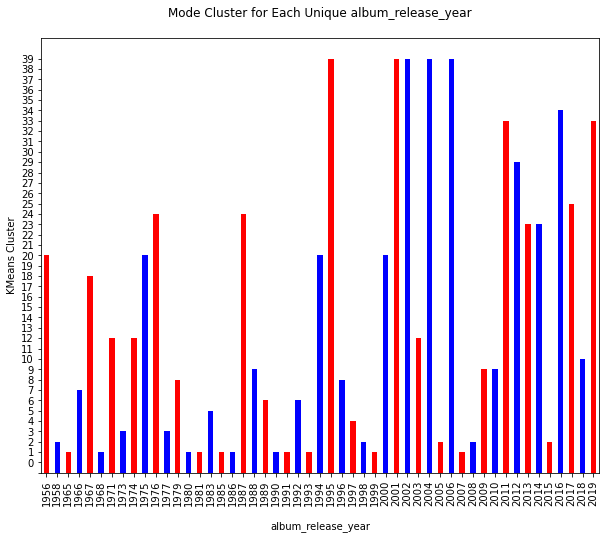

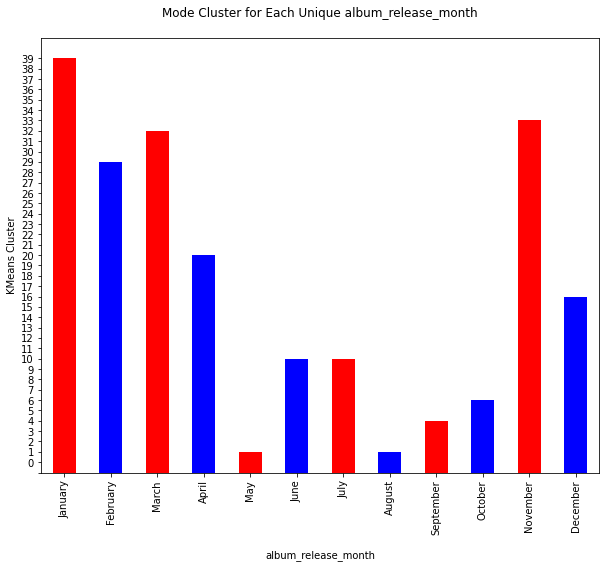

In [17]:
#Analyze all of the categorical variables, with respect to cluster label
str_cols = ['album_type', 'str_key','time_signature','album_release_year', 'str_release_month']
str_cols = [list(np.unique(df_fin[str_cols[0]])), list(np.unique(df_fin[str_cols[1]])), list(np.unique(df_fin[str_cols[2]])), list(np.unique(df_fin[str_cols[3]])), ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'] ]
cols = list(['album_type']+cat_cols[:-1])

for i in range(len(cols)):
    #Bar chart with cluster label on the y-axis and categorical variable on the x-axis
    inds = [str(j) for j in list(df_fin.groupby(cols[i]).label.apply(lambda x: x.mode()[0]).index)]
    values = [item + 1 for item in list(df_fin.groupby(cols[i]).label.apply(lambda x: x.mode()[0]).values)]
    ax = pd.Series(values, inds).plot(kind='bar', figsize=(10,8), fontsize = 10, color=('red','blue'))
    plt.title('Mode Cluster for Each Unique ' + cols[i] + '\n')
    plt.ylabel('KMeans Cluster')
    ax.set_yticks(list(range(41)))
    ax.set_yticklabels([''] + list(range(0,40)))
    plt.xlabel('\n' + cols[i])
    ax.set_xticks(list(range(len(str_cols[i]))))
    ax.set_xticklabels(str_cols[i], rotation='vertical')
    
    plt.show()

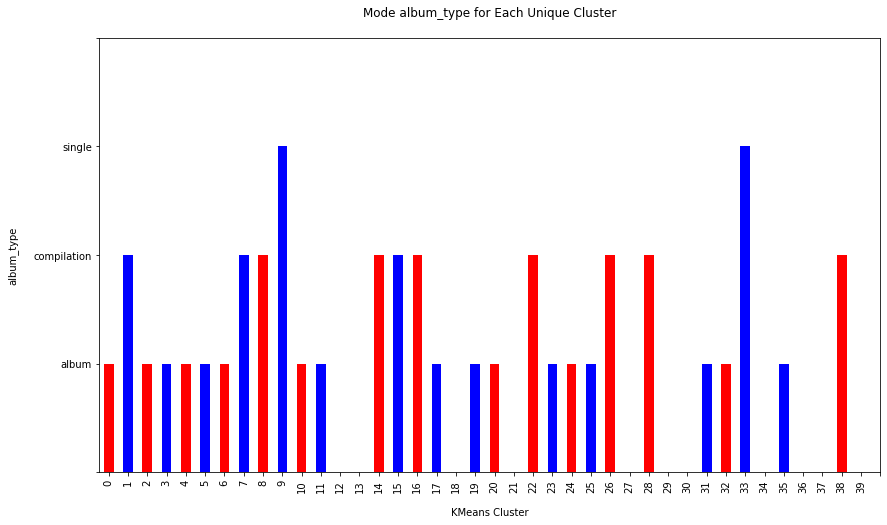

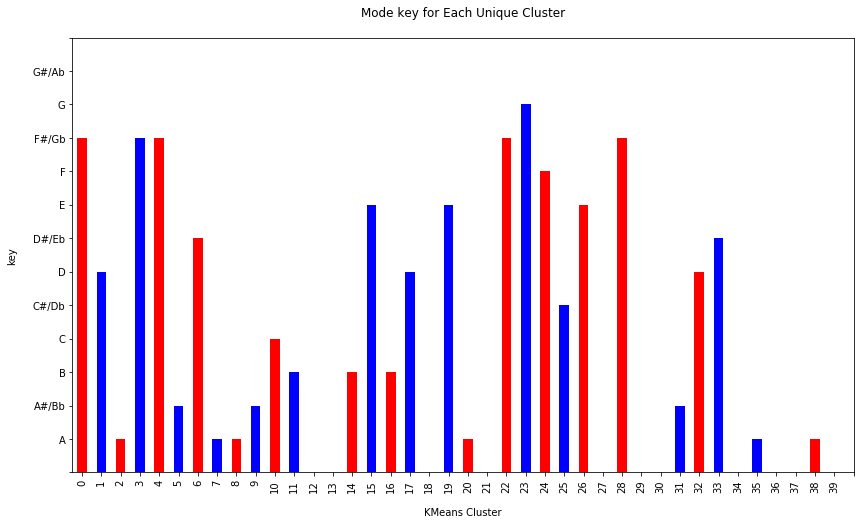

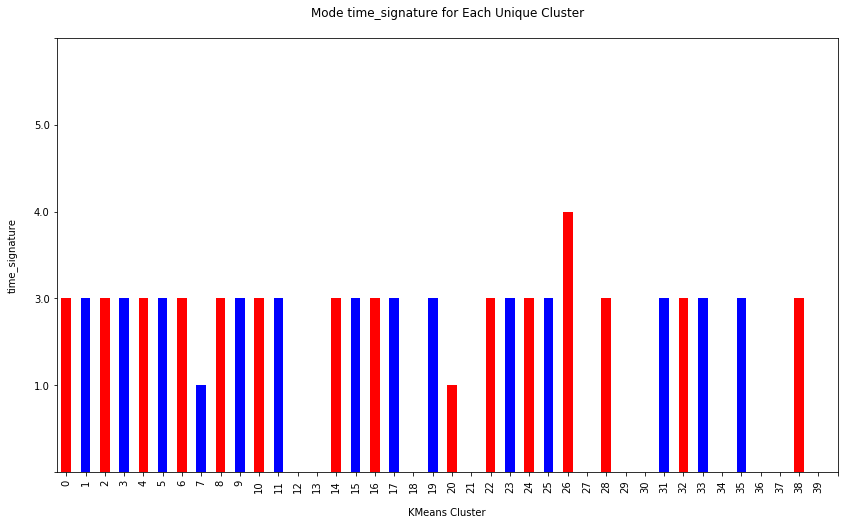

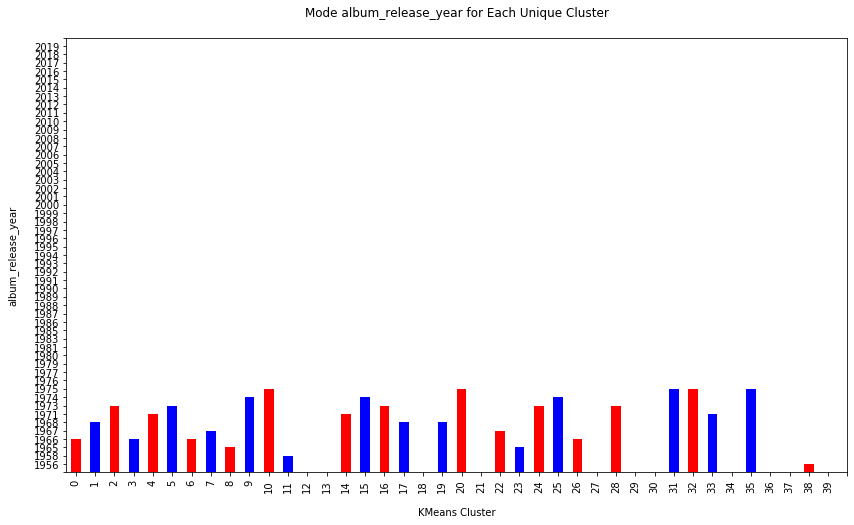

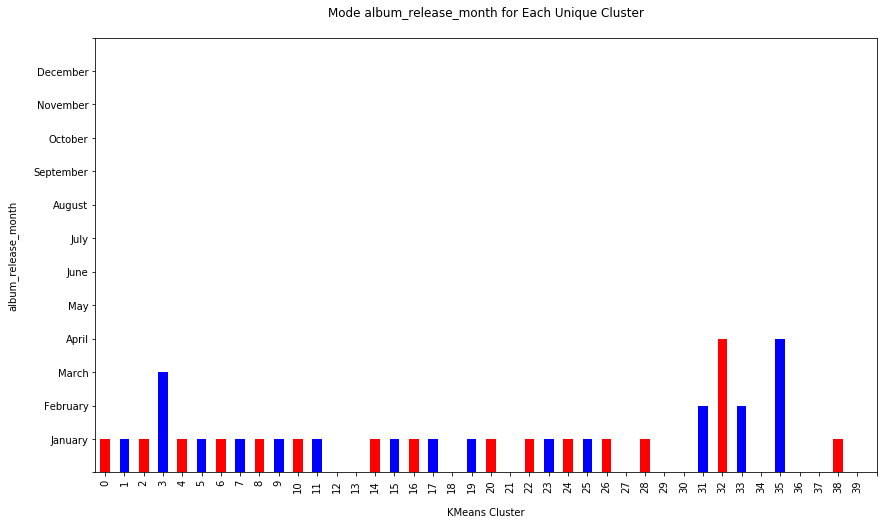

In [56]:
#Analyze all of the categorical variables, with respect to cluster label
str_cols = ['album_type', 'str_key','time_signature','album_release_year', 'str_release_month']
str_cols = [list(np.unique(df_fin[str_cols[0]])), list(np.unique(df_fin[str_cols[1]])), list(np.unique(df_fin[str_cols[2]])), list(np.unique(df_fin[str_cols[3]])), ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'] ]
cols = list(['album_type']+cat_cols[:-1])

for i in range(len(cols)):
    #Bar chart with cluster label on the y-axis and categorical variable on the x-axis
    ser = df_fin.groupby('label')[cols[i]].apply(lambda x: x.mode()[0])
    inds = list(range(1,41))
    uni_vals = list(np.unique(ser.values))
    values = []
    for k in list(range(1,41)):
        if k in list(ser.index):
            values.append(uni_vals.index(ser[k])+1)
        else:
            values.append(0)
    ax = pd.Series(values, inds).plot(kind='bar', figsize=(14,8), fontsize = 10, color=('red','blue'))
    plt.title('Mode ' + cols[i] + ' for Each Unique Cluster\n')
    plt.xlabel('\nKMeans Cluster')
    ax.set_xticks(list(range(41)))
    ax.set_xticklabels([str(i) for i in list(range(0,40))])
    plt.ylabel(cols[i] + '\n' )
    ax.set_yticks(list(range(len(str_cols[i])+2)))
    ax.set_yticklabels(['']+str_cols[i], rotation='horizontal')
    
    plt.show()

The `album_release_month` feature may be problematic in that the vast majority of songs/labels have been assigned the month of January, likely due to missing information. Additionally, the majority of the songs/clusters have a time signature of 3.0 and most clusters have an `album_type` of `album`. However, it is important to note that the different categories generally have unique mode clusters, which is good for the purposes of keeping the clusters seperate and unique.

## Test Various Supervised Learning Models

### Remove Outliers

In [18]:
import math
#Determine extent of outliers using Tukey's method
outlier_loc = []
top_outlier_percent = []
bottom_outlier_percent = []

for col in list(cont_cols):
    q75, q25 = np.percentile(df_fin[col], [75 ,25])
    iqr = q75 - q25

    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    
    if (len((np.where(df_fin[col] > max_val))[0]) > 0):
        if (len((np.where(df_fin[col] < min_val))[0]) > 0):
            loc_now = 'both ends'
        else:
            loc_now = 'top'
    else:
        loc_now = 'bottom'
    
    outlier_loc.append(loc_now)
    print("Percentage of outliers in {}, located at {} of range: {}".format(col, loc_now, len((np.where((df_fin[col] > max_val) |(df_fin[col] < min_val))[0]))/len(df_fin)))
    
    top_percent = len((np.where((df_fin[col] > max_val))[0]))/len(df_fin)
    #Get values to the closest whole percent
    top_outlier_percent.append(math.ceil(top_percent*100)/100)
    
    bottom_percent = len((np.where((df_fin[col] < min_val))[0]))/len(df_fin)
    #Get values to the closest whole percent
    bottom_outlier_percent.append(math.ceil(bottom_percent*100)/100)


Percentage of outliers in danceability, located at bottom of range: 0.0
Percentage of outliers in loudness, located at bottom of range: 0.02066590126291619
Percentage of outliers in speechiness, located at top of range: 0.12801377726750862
Percentage of outliers in liveness, located at top of range: 0.05797933409873708
Percentage of outliers in tempo, located at top of range: 0.005166475315729047
Percentage of outliers in duration_ms, located at both ends of range: 0.03616532721010333
Percentage of outliers in lyrics_length, located at top of range: 0.02812858783008037
Percentage of outliers in lyrics_num_verbs, located at top of range: 0.023536165327210104
Percentage of outliers in lyrics_num_nouns, located at top of range: 0.03559127439724455
Percentage of outliers in lyrics_num_adverbs, located at top of range: 0.025832376578645237
Percentage of outliers in lyrics_num_total_punct, located at top of range: 0.06888633754305395


In [19]:
#Show calculated outlier parameters to be used for winsorization
out_df = pd.DataFrame()

out_df['variable name'] = list(cont_cols)
out_df['top outliers'] = top_outlier_percent
out_df['bottom outliers'] = bottom_outlier_percent
out_df['outlier location'] = outlier_loc

out_df

variable name  top outliers  bottom outliers outlier location
0             danceability          0.00             0.00           bottom
1                 loudness          0.00             0.03           bottom
2              speechiness          0.13             0.00              top
3                 liveness          0.06             0.00              top
4                    tempo          0.01             0.00              top
5              duration_ms          0.04             0.01        both ends
6            lyrics_length          0.03             0.00              top
7         lyrics_num_verbs          0.03             0.00              top
8         lyrics_num_nouns          0.04             0.00              top
9       lyrics_num_adverbs          0.03             0.00              top
10  lyrics_num_total_punct          0.07             0.00              top

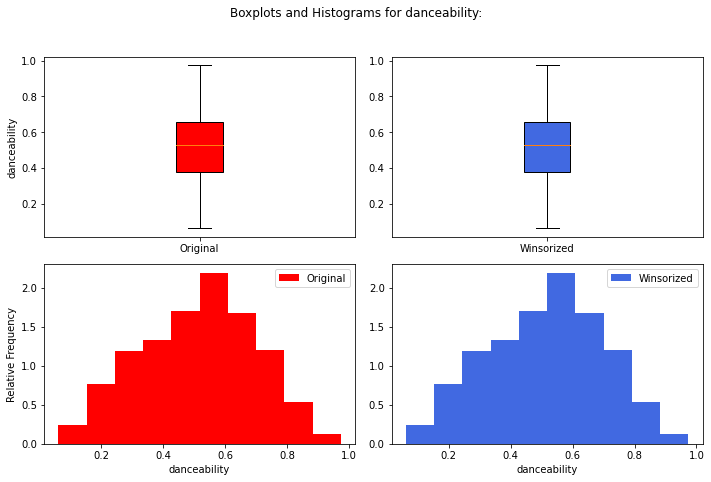

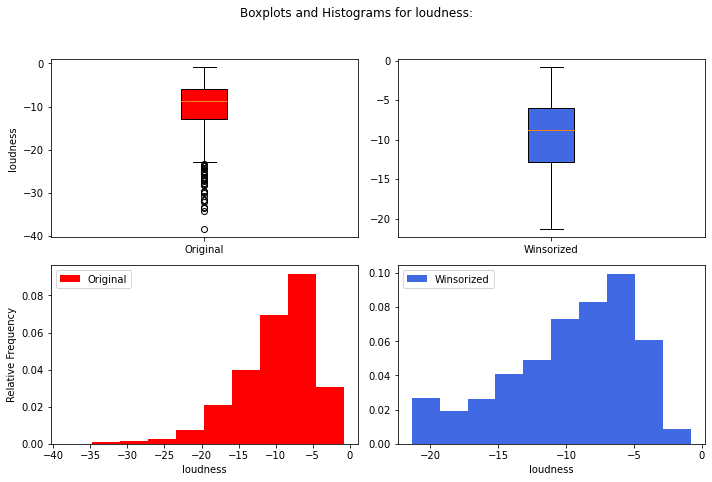

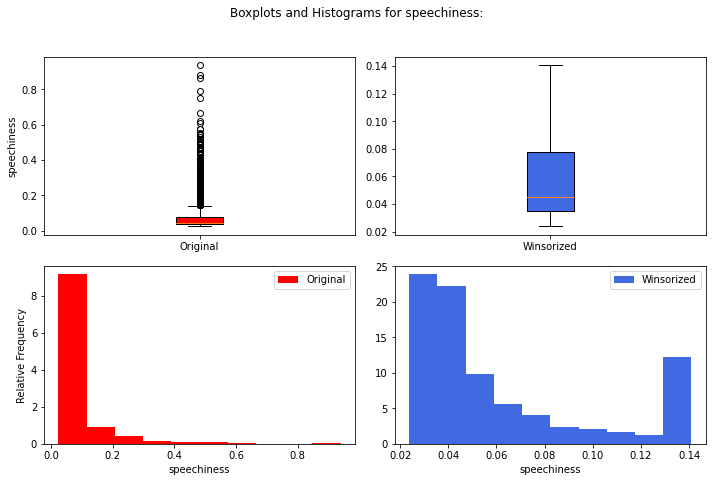

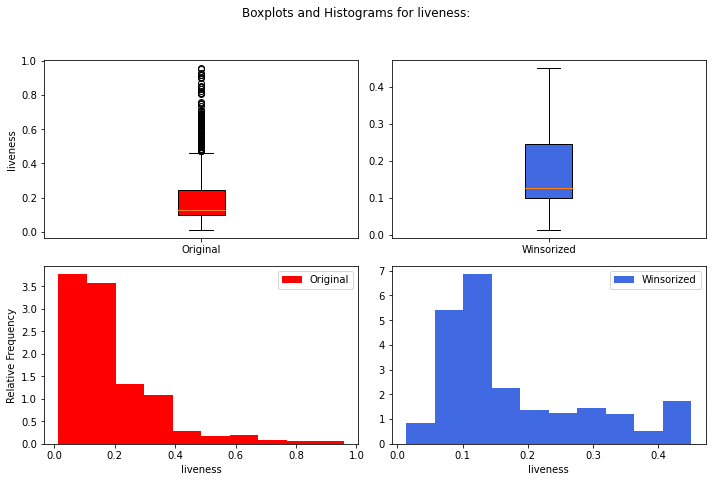

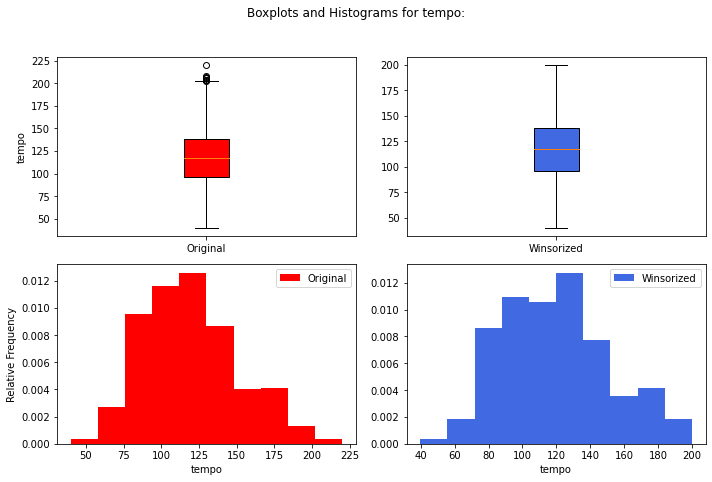

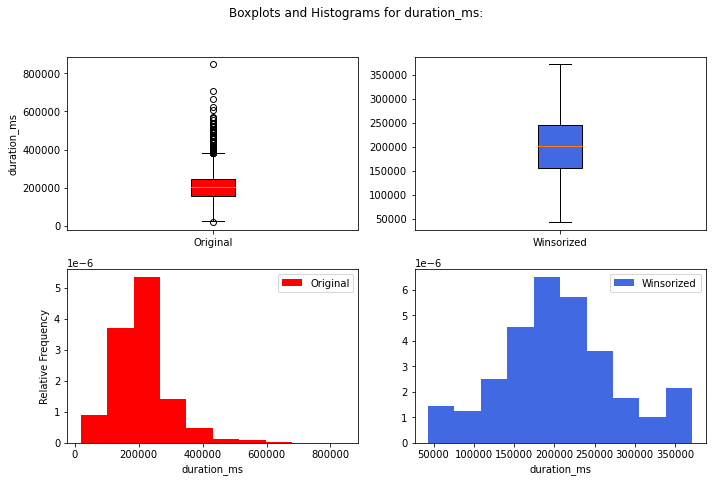

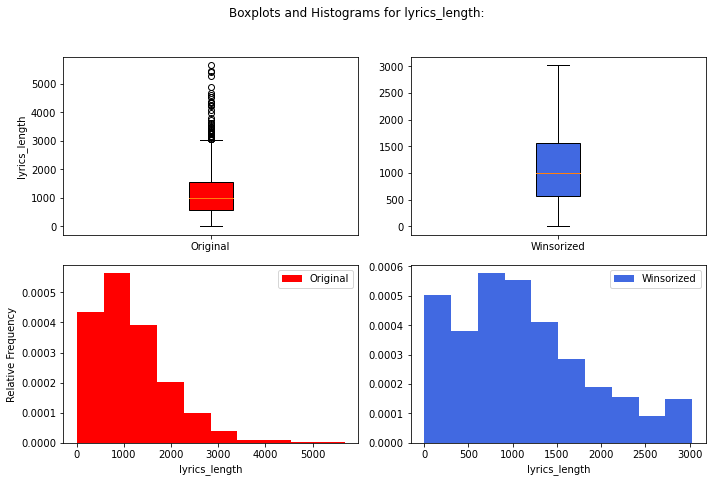

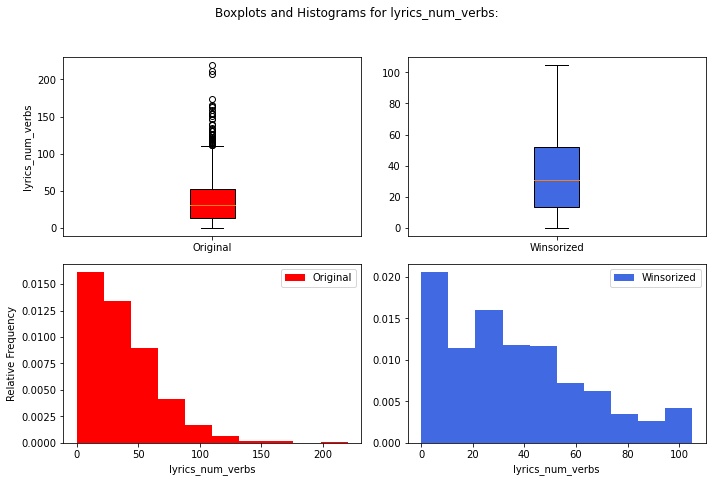

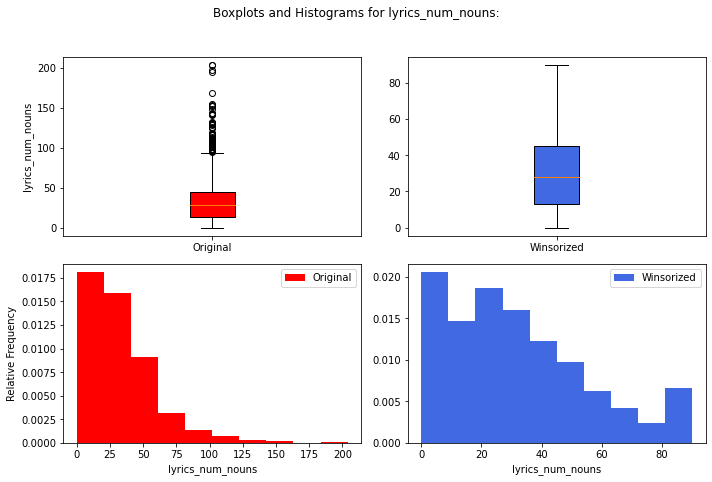

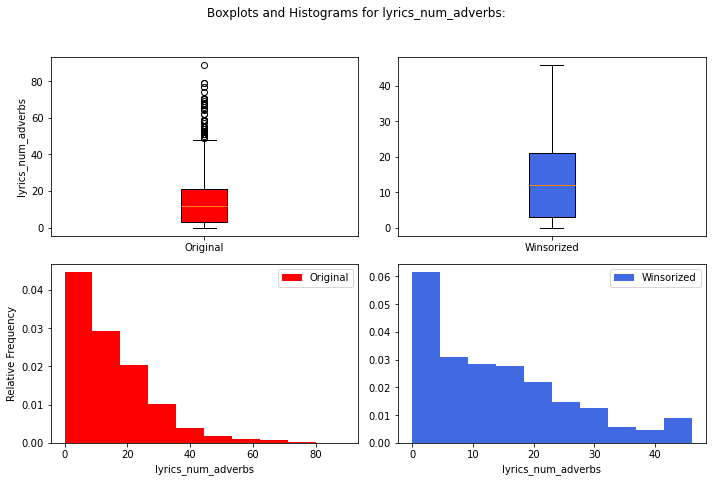

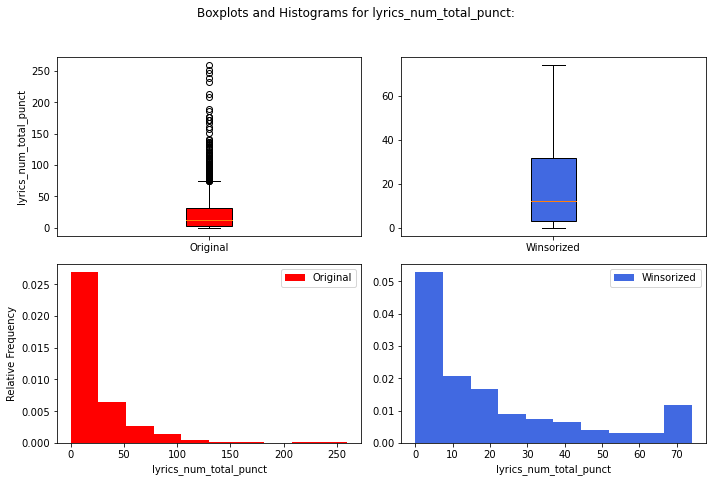

In [23]:
#Transform/remove the outliers, using winsorize()
from scipy.stats.mstats import winsorize

winsorized_cols = pd.DataFrame()

cols = cont_cols
for i in range(len(cols)):
    winsorized_cols[cols[i]] = winsorize(df_fin[cols[i]], (bottom_outlier_percent[i], top_outlier_percent[i]))

#Analyze the effects of winsorization on boxplots/histograms:
for col in cols:
    plt.figure(figsize=(10,7))
    plt.subplot(2,2,1)
    box = plt.boxplot([df_fin[col]], patch_artist=True, labels = ['Original'])
    plt.ylabel(col)
    colors = ['red']
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    plt.subplot(2,2,2)
    box = plt.boxplot([winsorized_cols[col]], patch_artist=True, labels = ['Winsorized'])
    colors = ['royalblue']
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)


    plt.subplot(2,2,3)
    plt.hist([df_fin[col]], color='red', label = ['Original'], density=True)
    plt.xlabel(col)
    plt.ylabel('Relative Frequency')
    plt.legend()  

    plt.subplot(2,2,4)
    plt.hist([winsorized_cols[col]], color='royalblue', label = ['Winsorized'], density=True)
    plt.xlabel(col)
    plt.legend()
    
    
    plt.suptitle('Boxplots and Histograms for ' + col + ':')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    

In [24]:
#Correlation analysis after outlier removal
df_fin2 = winsorized_cols.copy()
df_fin2.columns = [str('Winsorized ' + item) for item in list(cont_cols)]

for col in list(['label', 'artists_name', 'track_name', 'album_release_year']+bin_cat_cols):
    df_fin2[col] = df_fin[col]

### Train-Test Split

In [25]:
from sklearn.model_selection import train_test_split
win_conts = df_fin2.columns.drop(bin_cat_cols).drop(['label', 'artists_name', 'track_name', 'album_release_year'])

features = df_fin2.columns.drop(['label','artists_name','track_name'])
target = 'label'

X = df_fin2[features]
Y = df_fin2[target]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [26]:
#Normalize data
norm_df = pd.DataFrame()
for cat in win_conts:
    normed = []
    for item in X_train[cat]:
        xmax = X_train[cat].max()
        xmin = X_train[cat].min()
        normed.append((item-xmin)/(xmax-xmin))

    norm_df[cat.split('Winsorized ')[-1]] = normed

for col in norm_df.columns:
    X_train[col] = norm_df[col]

X_train = X_train.drop(win_conts, axis=1)



#Normalize data
norm_df = pd.DataFrame()
for cat in win_conts:
    normed = []
    for item in X_test[cat]:
        xmax = X_test[cat].max()
        xmin = X_test[cat].min()
        normed.append((item-xmin)/(xmax-xmin))

    norm_df[cat.split('Winsorized ')[-1]] = normed

for col in norm_df.columns:
    X_test[col] = norm_df[col]

X_test = X_test.drop(win_conts, axis=1)

### Analysis Functions

In [27]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# For evaluating our ML results
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve, auc

In [28]:
# Making the Confusion Matrix
def confusion_matrix_c(y_test,y_pred):
    cm = confusion_matrix(y_test, y_pred)
    class_label = ['KM'+str(item) for item in list(np.unique(y_test))]
    df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
    plt.figure(figsize=(13,10))
    sns.heatmap(df_cm, annot=True, fmt='d')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Cluster")
    plt.ylabel("True Cluster")
    plt.show()


### Logistic Regression Classification

Logistic Regression Train Accuracy:  0.6992103374012921
Logistic Regression Test Accuracy:  0.4068767908309456


Multinomial Logistic Regression Train Accuracy:  1.0
Multinomial Logistic Regression Test Accuracy:  0.7535816618911175


              precision    recall  f1-score   support

           1       0.56      0.83      0.67        18
           2       0.83      0.71      0.77        21
           3       0.81      0.81      0.81        16
           4       0.50      0.20      0.29         5
           5       0.67      0.80      0.73         5
           6       0.76      1.00      0.87        13
           7       0.83      0.56      0.67         9
           8       0.96      0.92      0.94        24
           9       0.73      0.73      0.73        15
          10       0.73      0.79      0.76        14
          11       1.00      1.00      1.00         7
          12       0.86      0.92      0.89        13
          15       1.00      0.67      0.80         6
        

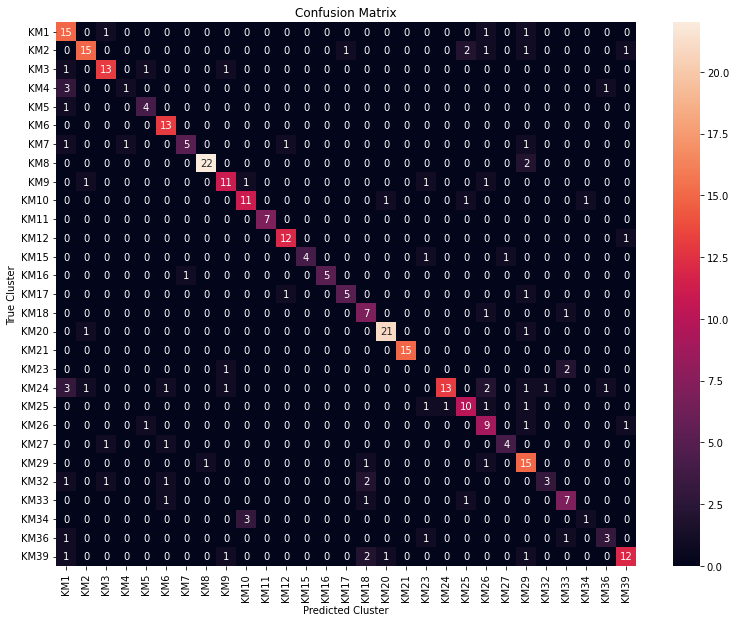

In [29]:
#Logistic Regression Classifier
from sklearn import linear_model

# Train multi-classification model with logistic regression
lr = linear_model.LogisticRegression()
lr.fit(X_train, y_train)

# Train multinomial logistic regression
mul_lr = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg')
mul_lr.fit(X_train, y_train)

#y_pred_lr= lr.predict(X_test)
print ('Logistic Regression Train Accuracy: ', metrics.accuracy_score(y_train, lr.predict(X_train)))
print ('Logistic Regression Test Accuracy: ', metrics.accuracy_score(y_test, lr.predict(X_test)))
print('\n')

y_pred_mullr= mul_lr.predict(X_test)
print ('Multinomial Logistic Regression Train Accuracy: ', metrics.accuracy_score(y_train, mul_lr.predict(X_train)))
print ('Multinomial Logistic Regression Test Accuracy: ', metrics.accuracy_score(y_test, mul_lr.predict(X_test)))

#Stats
print('\n')
print(classification_report(y_test, y_pred_mullr))

# Confusion Matrix
confusion_matrix_c(y_test, y_pred_mullr)


### Naive-Bayes Classifier

Train Accuracy: 0.5211773151471644
Test Accuracy: 0.21203438395415472


              precision    recall  f1-score   support

           1       0.22      0.61      0.33        18
           2       0.27      0.29      0.28        21
           3       0.33      0.25      0.29        16
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         5
           6       0.07      0.15      0.10        13
           7       0.00      0.00      0.00         9
           8       0.25      0.71      0.37        24
           9       0.00      0.00      0.00        15
          10       0.25      0.07      0.11        14
          11       0.00      0.00      0.00         7
          12       0.00      0.00      0.00        13
          15       0.00      0.00      0.00         6
          16       0.00      0.00      0.00         6
          17       0.00      0.00      0.00         7
          18       0.15      0.22      0.18         9
         

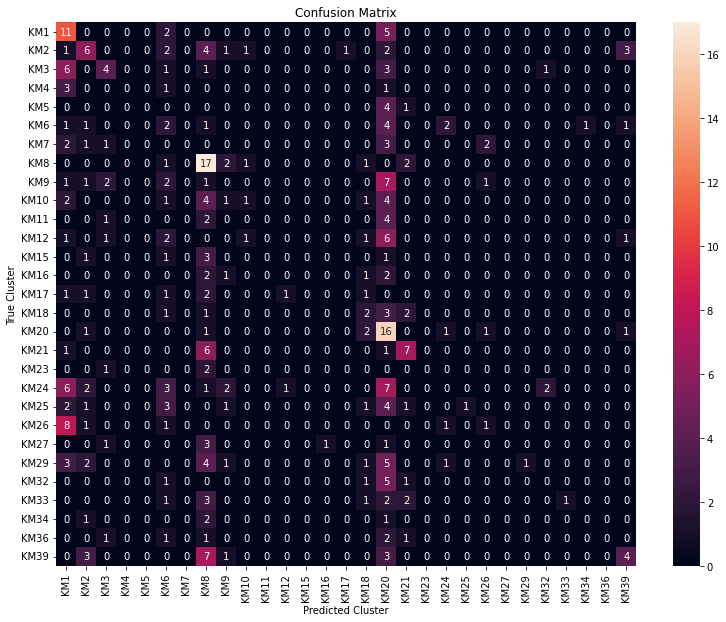

In [30]:
#Multinomial Naive Bayes Classifier

#Import Multinomial Naive Bayes model (used for categorical predictions)
from sklearn.naive_bayes import MultinomialNB

#Create a Multinomial Classifier
mnb = MultinomialNB()

#Train the model using the training sets
mnb.fit(X_train, y_train)

#Predict the response for test dataset
y_pred_mnb = mnb.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Train Accuracy:",metrics.accuracy_score(y_train, mnb.predict(X_train)))
print("Test Accuracy:",metrics.accuracy_score(y_test, y_pred_mnb))

#Stats
print('\n')
print(classification_report(y_test, y_pred_mnb))

#Confusion Matrix
confusion_matrix_c(y_test, y_pred_mnb) 


### K-Nearest Neighbors

In [31]:
# try K=1 through K=25 and record testing accuracy
from sklearn.neighbors import KNeighborsClassifier
k_range = range(1, 26)

scores = []

# We use a loop through the range 1 to 26
# We append the scores in the dictionary
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred_knn = knn.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, y_pred_knn))

print(scores)

[0.17765042979942694, 0.16045845272206305, 0.166189111747851, 0.1833810888252149, 0.19197707736389685, 0.20630372492836677, 0.19484240687679083, 0.1977077363896848, 0.1833810888252149, 0.17765042979942694, 0.16045845272206305, 0.16905444126074498, 0.16332378223495703, 0.14613180515759314, 0.14613180515759314, 0.15472779369627507, 0.14613180515759314, 0.12893982808022922, 0.12607449856733524, 0.12320916905444126, 0.1174785100286533, 0.12320916905444126, 0.1318051575931232, 0.14613180515759314, 0.13753581661891118]


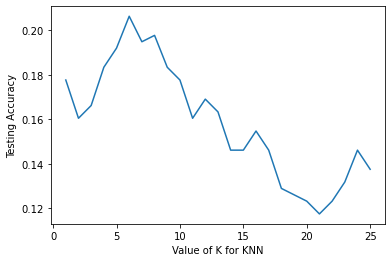

In [32]:
# plot the relationship between K and testing accuracy
# plt.plot(x_axis, y_axis)
plt.figure()
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')
plt.show()

Train Accuracy: 0.42569992821249103
Test Accuracy: 0.19484240687679083
              precision    recall  f1-score   support

           1       0.09      0.28      0.14        18
           2       0.16      0.38      0.23        21
           3       0.09      0.12      0.11        16
           4       0.07      0.20      0.10         5
           5       0.08      0.20      0.11         5
           6       0.18      0.31      0.23        13
           7       0.00      0.00      0.00         9
           8       0.36      0.33      0.35        24
           9       0.20      0.13      0.16        15
          10       0.33      0.36      0.34        14
          11       0.50      0.14      0.22         7
          12       0.67      0.15      0.25        13
          15       0.50      0.17      0.25         6
          16       0.12      0.17      0.14         6
          17       0.00      0.00      0.00         7
          18       0.08      0.11      0.09         9
          

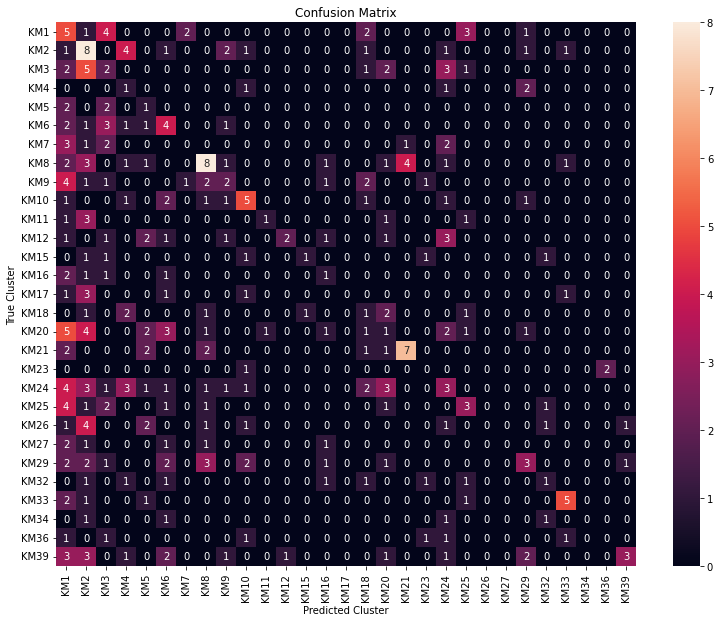

In [33]:
#KNN Classifier (K=7)
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print("Train Accuracy:", metrics.accuracy_score(y_train, knn.predict(X_train)))
print("Test Accuracy:", metrics.accuracy_score(y_test, y_pred_knn))

#Stats
print(classification_report(y_test, y_pred_knn))

#Confusion Matrix
confusion_matrix_c(y_test, y_pred_knn) 


### Support Vector Machine and Kernel SVC

Train Accuracy: 1.0
Test Accuracy: 0.7822349570200573
              precision    recall  f1-score   support

           1       0.56      0.83      0.67        18
           2       0.86      0.86      0.86        21
           3       0.93      0.81      0.87        16
           4       0.50      0.40      0.44         5
           5       0.57      0.80      0.67         5
           6       0.81      1.00      0.90        13
           7       0.55      0.67      0.60         9
           8       0.95      0.88      0.91        24
           9       0.85      0.73      0.79        15
          10       0.85      0.79      0.81        14
          11       1.00      0.86      0.92         7
          12       0.85      0.85      0.85        13
          15       1.00      0.83      0.91         6
          16       0.83      0.83      0.83         6
          17       0.50      0.43      0.46         7
          18       0.70      0.78      0.74         9
          20       0.94    

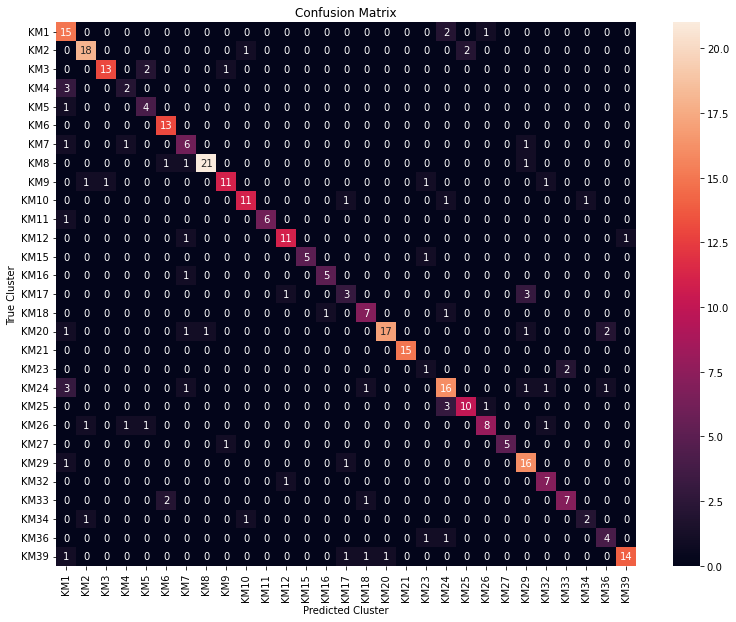

In [34]:
#Support Vector Machine
from sklearn.svm import SVC
svc = SVC(kernel = 'linear',random_state = 42,probability=True)
svc.fit(X_train,y_train)

# Predicting the Test set results 
y_pred_svc= svc.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Train Accuracy:",metrics.accuracy_score(y_train, svc.predict(X_train)))
print("Test Accuracy:",metrics.accuracy_score(y_test, y_pred_svc))

#Stats
print(classification_report(y_test,y_pred_svc))
 
#Confusion Matrix
confusion_matrix_c(y_test, y_pred_svc) 


Train Accuracy: 0.0624551328068916
Test Accuracy: 0.06017191977077364
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        18
           2       0.06      1.00      0.11        21
           3       0.00      0.00      0.00        16
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        13
           7       0.00      0.00      0.00         9
           8       0.00      0.00      0.00        24
           9       0.00      0.00      0.00        15
          10       0.00      0.00      0.00        14
          11       0.00      0.00      0.00         7
          12       0.00      0.00      0.00        13
          15       0.00      0.00      0.00         6
          16       0.00      0.00      0.00         6
          17       0.00      0.00      0.00         7
          18       0.00      0.00      0.00         9
          2

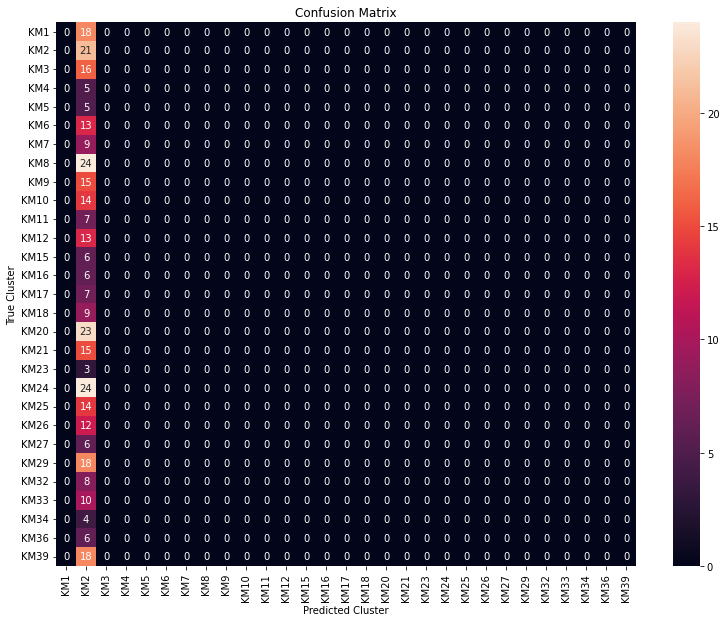

In [35]:
from sklearn.svm import SVC
# Kernel SVM
ksvc = SVC(kernel = 'rbf',random_state = 42,probability=True)
ksvc.fit(X_train,y_train)

# Predicting the Test set results
y_pred_ksvc= ksvc.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Train Accuracy:",metrics.accuracy_score(y_train, ksvc.predict(X_train)))
print("Test Accuracy:",metrics.accuracy_score(y_test, y_pred_ksvc))

#Stats
print(classification_report(y_test,y_pred_ksvc))

#Confusion Matrix
confusion_matrix_c(y_test, y_pred_ksvc) 


### Decision Tree

In [36]:
#Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

# GridSearchCV
from sklearn.model_selection import GridSearchCV
param_grid={'max_depth':range(1,51,2) ,
            'max_features':range(1,51,2)}
dt_g=DecisionTreeClassifier(random_state = 42)
dt_cv=GridSearchCV(dt_g,param_grid,cv=10,scoring='accuracy',n_jobs=-1)
dt_cv.fit(X_train,y_train)

print("Best parameters:",dt_cv.best_params_)
print("Accuracy :",dt_cv.best_score_)

Best parameters: {'max_depth': 41, 'max_features': 45}
Accuracy : 0.3418293936279547


Train Accuracy: 0.9734386216798278
Test Accuracy: 0.3209169054441261


              precision    recall  f1-score   support

           1       0.38      0.67      0.48        18
           2       0.14      0.24      0.17        21
           3       0.64      0.56      0.60        16
           4       0.29      0.40      0.33         5
           5       0.33      0.20      0.25         5
           6       0.22      0.31      0.26        13
           7       0.75      0.33      0.46         9
           8       0.26      0.21      0.23        24
           9       0.85      0.73      0.79        15
          10       0.27      0.29      0.28        14
          11       0.00      0.00      0.00         7
          12       0.27      0.23      0.25        13
          15       0.29      0.33      0.31         6
          16       0.18      0.50      0.26         6
          17       0.00      0.00      0.00         7
          18       0.25      0.33      0.29         9
          

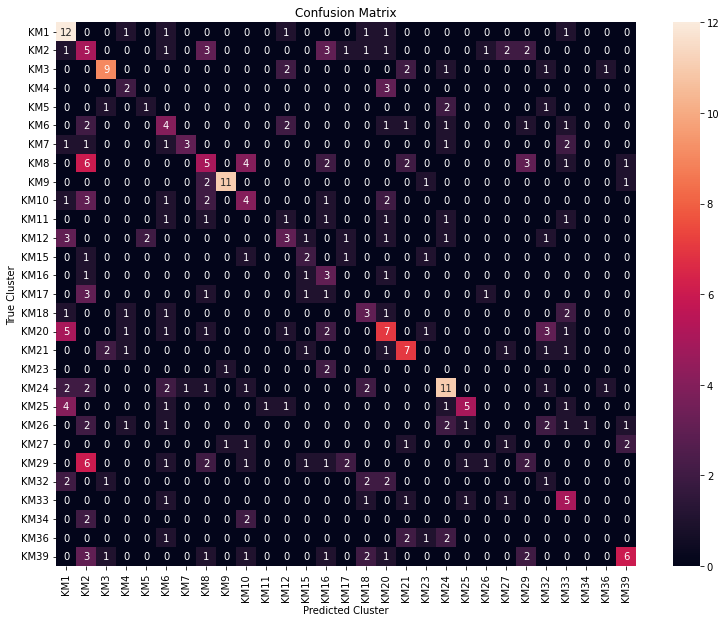

In [37]:
dt = DecisionTreeClassifier(max_depth=dt_cv.best_params_['max_depth'],max_features=dt_cv.best_params_['max_features'],random_state = 42)
dt.fit(X_train,y_train)

# Predicting the Test set results
y_pred_dt= dt.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Train Accuracy:",metrics.accuracy_score(y_train, dt.predict(X_train)))
print("Test Accuracy:",metrics.accuracy_score(y_test, y_pred_dt))
print('\n')

#Stats
print(classification_report(y_test,y_pred_dt))

#Confusion Matrix
confusion_matrix_c(y_test, y_pred_dt) 


### Random Forest

In [38]:
#Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# GridSearchCV
param_grid={'max_depth':range(1,51,2),
            'max_features':range(1,51,2)}
rf_g=RandomForestClassifier(random_state=42)
rf_cv=GridSearchCV(rf_g,param_grid,cv=10,scoring='f1_micro',n_jobs=-1)
rf_cv.fit(X_train,y_train)

print("Best parameters:",rf_cv.best_params_)
print("Accuracy :",rf_cv.best_score_)

Best parameters: {'max_depth': 41, 'max_features': 47}
Accuracy : 0.8549948612538539


Train Accuracy: 1.0
Test Accuracy: 0.8624641833810889


              precision    recall  f1-score   support

           1       0.71      0.94      0.81        18
           2       0.79      0.71      0.75        21
           3       0.94      1.00      0.97        16
           4       1.00      0.20      0.33         5
           5       0.80      0.80      0.80         5
           6       0.81      1.00      0.90        13
           7       1.00      1.00      1.00         9
           8       1.00      1.00      1.00        24
           9       0.88      1.00      0.94        15
          10       0.74      1.00      0.85        14
          11       1.00      1.00      1.00         7
          12       0.87      1.00      0.93        13
          15       1.00      0.83      0.91         6
          16       1.00      0.67      0.80         6
          17       1.00      0.86      0.92         7
          18       0.90      1.00      0.95         9
          20       0.82  

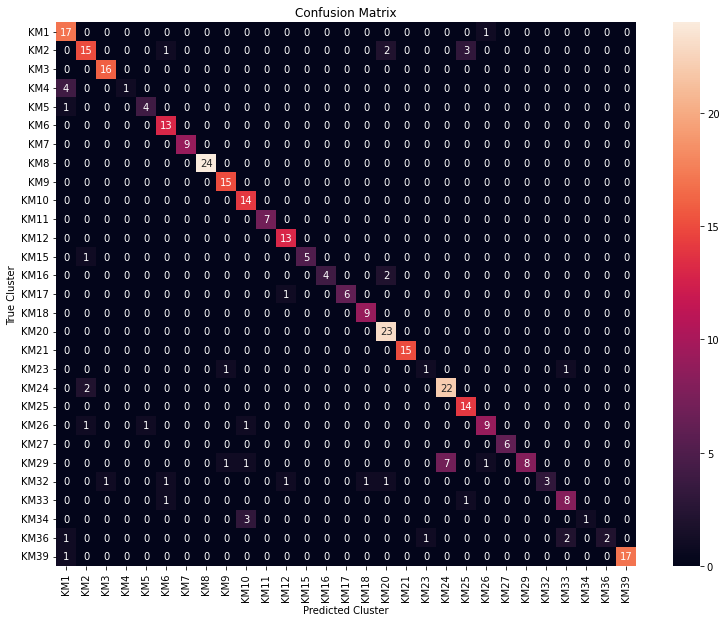

In [39]:
rf = RandomForestClassifier(max_depth=rf_cv.best_params_['max_depth'],max_features=rf_cv.best_params_['max_features'],n_estimators=250,random_state=42)
rf.fit(X_train,y_train)

# Predicting the Test set results
y_pred_rf = rf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Train Accuracy:",metrics.accuracy_score(y_train, rf.predict(X_train)))
print("Test Accuracy:",metrics.accuracy_score(y_test, y_pred_rf))
print('\n')

#Stats
print(classification_report(y_test,y_pred_rf))

#Confusion Matrix
confusion_matrix_c(y_test, y_pred_rf) 


The Random Forest model has the highest test accuracy (85%) compared to the other potential models. Therefore, we used Random Forest to create the ideal Supervised Learning model. Then, we save the model as a pickle file, which can be loaded into our final classification program. 

### Sanity Check: Is the Model Overfitting?

In [40]:
for i in range(1, 21):
    rf = RandomForestClassifier(max_depth=rf_cv.best_params_['max_depth'] - i, max_features=rf_cv.best_params_['max_features'] - i, n_estimators=250,random_state=42)
    rf.fit(X_train,y_train)

    # Predicting the Test set results
    y_pred_rf = rf.predict(X_test)

    # Model Accuracy, how often is the classifier correct?
    print('Random Forest Model with max_depth = {} and max_features = {}\n'.format(rf_cv.best_params_['max_depth'] - i, rf_cv.best_params_['max_features'] - i))
    print("Train Accuracy:",metrics.accuracy_score(y_train, rf.predict(X_train)))
    print("Test Accuracy:",metrics.accuracy_score(y_test, y_pred_rf))
    print('\n\n')


Random Forest Model with max_depth = 40 and max_features = 46

Train Accuracy: 1.0
Test Accuracy: 0.8595988538681948



Random Forest Model with max_depth = 39 and max_features = 45

Train Accuracy: 1.0
Test Accuracy: 0.8567335243553008



Random Forest Model with max_depth = 38 and max_features = 44

Train Accuracy: 1.0
Test Accuracy: 0.839541547277937



Random Forest Model with max_depth = 37 and max_features = 43

Train Accuracy: 1.0
Test Accuracy: 0.839541547277937



Random Forest Model with max_depth = 36 and max_features = 42

Train Accuracy: 1.0
Test Accuracy: 0.8681948424068768



Random Forest Model with max_depth = 35 and max_features = 41

Train Accuracy: 1.0
Test Accuracy: 0.8424068767908309



Random Forest Model with max_depth = 34 and max_features = 40

Train Accuracy: 1.0
Test Accuracy: 0.8739255014326648



Random Forest Model with max_depth = 33 and max_features = 39

Train Accuracy: 1.0
Test Accuracy: 0.839541547277937



Random Forest Model with max_depth = 32 and

Based on these outputs, I don't believe this model is having significant overfitting issues. Yes, by reducing the `max_depth` and `max_features`, we generally cause a reduction in both train and test scores for the Random Forest model. However, the reductions in accuracy are not very significant. Additionally, even when the train score drops below 100%, thereby reducing concerns about overfitting, the test scores for this model (~75%) are still higher than those for any of the other models tested. Therefore, I feel confident that this model is the proper one to use for the purposed of this classification project.

In [41]:
features = df_fin.columns.drop(str_cat_cols + cat_cols)
target = 'label'

X = df_fin[['album_release_year'] + list(features)]
Y = df_fin[target]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [42]:
#Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# GridSearchCV
param_grid={'max_depth':range(1,51,2),
            'max_features':range(1,51,2)}
rf_g=RandomForestClassifier(random_state=42)
rf_cv=GridSearchCV(rf_g,param_grid,cv=10,scoring='f1_micro',n_jobs=-1)
rf_cv.fit(X_train,y_train)

print("Best parameters:",rf_cv.best_params_)
print("Accuracy :",rf_cv.best_score_)

Best parameters: {'max_depth': 49, 'max_features': 45}
Accuracy : 0.8535662898252825


Train Accuracy: 1.0
Test Accuracy: 0.8481375358166189


              precision    recall  f1-score   support

           1       0.78      1.00      0.88        18
           2       0.79      0.71      0.75        21
           3       0.94      1.00      0.97        16
           4       1.00      0.40      0.57         5
           5       0.80      0.80      0.80         5
           6       0.81      1.00      0.90        13
           7       0.90      1.00      0.95         9
           8       1.00      1.00      1.00        24
           9       0.88      1.00      0.94        15
          10       0.74      1.00      0.85        14
          11       1.00      0.71      0.83         7
          12       0.87      1.00      0.93        13
          15       1.00      0.17      0.29         6
          16       0.60      0.50      0.55         6
          17       1.00      0.86      0.92         7
          18       0.75      1.00      0.86         9
          20       0.82  

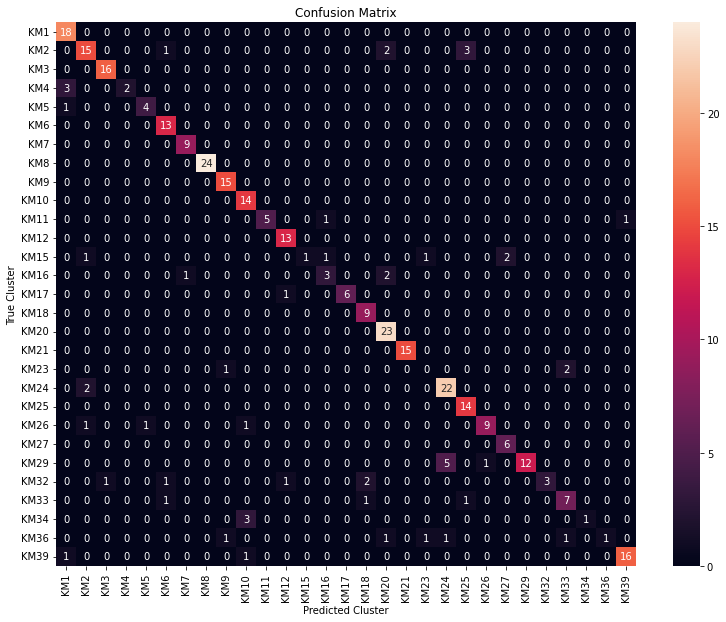

In [43]:
# Logistic Regression
rf = RandomForestClassifier(max_depth=rf_cv.best_params_['max_depth'],max_features=rf_cv.best_params_['max_features'],n_estimators=250,random_state=42)
rf.fit(X_train,y_train)

# Predicting the Test set results
y_pred_rf = rf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Train Accuracy:",metrics.accuracy_score(y_train, rf.predict(X_train)))
print("Test Accuracy:",metrics.accuracy_score(y_test, y_pred_rf))
print('\n')

#Stats
print(classification_report(y_test,y_pred_rf))

#Confusion Matrix
confusion_matrix_c(y_test, y_pred_rf) 



## Save Random Forest Model as Pickle File

In [44]:
rf = RandomForestClassifier(max_depth=rf_cv.best_params_['max_depth'],max_features=rf_cv.best_params_['max_features'],n_estimators=250,random_state=42)
rf.fit(X_train,y_train)

import pickle
import os 
dest = os.path.join('musicclassifier', 'pkl_objects')
if not os.path.exists(dest):
    os.makedirs(dest)

pickle.dump(rf, open(os.path.join(dest, 'classifier.pkl'), 'wb'), protocol=4)

## Final Steps:
Now that we have our final dataset and optimized classification model, we can run our final classification program, outlined in the file titled `app.py`, which runs the model as a Flask application, utilizing the other files located within this GitHub repository. If you'd like to run the script on your own computer, you must fill in your own token values for Spotipy's `client_id` and `client_secret`, as well as LyricGenius' `genius_token`. However, I have also deployed my application, hosted on Render's site, which can be accessed at: https://drplaylist-disney.onrender.com/.

Although I elected to model this product using only Disney songs, this platform could one day be expanded to work for any songs. The main area of improvement I'll need to focus on is speeding up the classification process, since it doesn't currently run as quickly as I'd like it to, and with many more songs, it would probably take even longer to run.